#Finding an Edge in Sports Betting

##Pre-Model Work

link to main data set - https://github.com/nflverse/nfl_data_py

###Set Up

In [1]:
!pip install nfl_data_py

In [2]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from collections import defaultdict

In [4]:
#all data entries have a spread_line value and game margin (target variable)
#game margin is defined as home team points minus away team points, so it can be negative
match_df = nfl.import_schedules([year for year in range(2009, 2025)])

#check for nan values
print(match_df.shape)
pd.set_option("display.max_columns", None)
matches_df = match_df.dropna(subset=['spread_line', 'result'])
print(match_df.shape)

#move the result and the spread line towards the front of the df for visibility
spread_line = match_df.pop('spread_line')
match_df.insert(1, spread_line.name, spread_line)

game_margin = match_df.pop('result')
match_df.insert(1, 'game_margin', game_margin)

match_df

(4345, 46)
(4345, 46)


game_id  game_margin  spread_line  season game_type  week  \
2646  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
2647  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2648   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
2649  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
2650  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   
...               ...          ...          ...     ...       ...   ...   
6986   2024_20_LA_PHI          6.0          7.0    2024       DIV    20   
6987  2024_20_BAL_BUF          2.0         -1.5    2024       DIV    20   
6988  2024_21_WAS_PHI         32.0          6.0    2024       CON    21   
6989   2024_21_BUF_KC          3.0          1.5    2024       CON    21   
6990   2024_22_KC_PHI         18.0         -1.5    2024        SB    22   

         gameday   weekday gametime away_team  away_score home_team  \
2646  2009-09-10  Thursday    20:30       TEN        10.0       PIT   
2647  2009-09-13    Sunday    13:00       MIA         7.0       ATL   
2648  2009-09-13    Sunday    13:00        KC        24.0       BAL   
2649  2009-09-13    Sunday    13:00       PHI        38.0       CAR   
2650  2009-09-13    Sunday    13:00       DEN        12.0       CIN   
...          ...       ...      ...       ...         ...       ...   
6986  2025-01-19    Sunday    15:00        LA        22.0       PHI   
6987  2025-01-19    Sunday    18:30       BAL        25.0       BUF   
6988  2025-01-26    Sunday    15:00       WAS        23.0       PHI   
6989  2025-01-26    Sunday    18:30       BUF        29.0        KC   
6990  2025-02-09    Sunday    18:30        KC        22.0       PHI   

      home_score location  total  overtime  old_game_id     gsis  \
2646        13.0     Home   23.0       1.0   2009091000  54467.0   
2647        19.0     Home   26.0       0.0   2009091300  54468.0   
2648        38.0     Home   62.0       0.0   2009091301  54469.0   
2649        10.0     Home   48.0       0.0   2009091302  54470.0   
2650         7.0     Home   19.0       0.0   2009091303  54471.0   
...          ...      ...    ...       ...          ...      ...   
6986        28.0     Home   50.0       0.0   2025011900  59837.0   
6987        27.0     Home   52.0       0.0   2025011901  59838.0   
6988        55.0     Home   78.0       0.0   2025012600  59839.0   
6989        32.0     Home   61.0       0.0   2025012601  59840.0   
6990        40.0  Neutral   62.0       0.0   2025020900  59841.0   

     nfl_detail_id           pfr     pff         espn  ftn  away_rest  \
2646           NaN  200909100pit  1395.0  290910023.0  NaN          7   
2647           NaN  200909130atl  1396.0  290913001.0  NaN          7   
2648           NaN  200909130rav  1398.0  290913033.0  NaN          7   
2649           NaN  200909130car  1404.0  290913029.0  NaN          7   
2650           NaN  200909130cin  1403.0  290913004.0  NaN          7   
...            ...           ...     ...          ...  ...        ...   
6986           NaN  202501190phi     NaN  401671937.0  NaN          6   
6987           NaN  202501190buf     NaN  401671886.0  NaN          8   
6988           NaN  202501260phi     NaN  401671888.0  NaN          8   
6989           NaN  202501260kan     NaN  401671887.0  NaN          7   
6990           NaN  202502090phi     NaN  401671889.0  NaN         14   

      home_rest  away_moneyline  home_moneyline  away_spread_odds  \
2646          7           228.0          -260.0            -116.0   
2647          7           190.0          -210.0            -104.0   
2648          7           570.0          -700.0            -112.0   
2649          7          -125.0           115.0            -120.0   
2650          7           196.0          -222.0            -104.0   
...         ...             ...             ...               ...   
6986          7           260.0          -325.0            -112.0   
6987          

##Data Cleaning / Data Manipulation

###Adding is_playoff and is_final_week features, shows if a match is a playoff game, final game of regular season or neither.

In [5]:
#add a feature to include if a match is a playoff or regular season event -> regular season games tend to have more noise, if teams get super far behind in the regular season they may pull their starters, but in the playoffs all teams try the hardest they possibly can
match_df['is_playoff'] = match_df['game_type'] != 'REG'
match_df

game_id  game_margin  spread_line  season game_type  week  \
2646  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
2647  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2648   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
2649  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
2650  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   
...               ...          ...          ...     ...       ...   ...   
6986   2024_20_LA_PHI          6.0          7.0    2024       DIV    20   
6987  2024_20_BAL_BUF          2.0         -1.5    2024       DIV    20   
6988  2024_21_WAS_PHI         32.0          6.0    2024       CON    21   
6989   2024_21_BUF_KC          3.0          1.5    2024       CON    21   
6990   2024_22_KC_PHI         18.0         -1.5    2024        SB    22   

         gameday   weekday gametime away_team  away_score home_team  \
2646  2009-09-10  Thursday    20:30       TEN        10.0       PIT   
2647  2009-09-13    Sunday    13:00       MIA         7.0       ATL   
2648  2009-09-13    Sunday    13:00        KC        24.0       BAL   
2649  2009-09-13    Sunday    13:00       PHI        38.0       CAR   
2650  2009-09-13    Sunday    13:00       DEN        12.0       CIN   
...          ...       ...      ...       ...         ...       ...   
6986  2025-01-19    Sunday    15:00        LA        22.0       PHI   
6987  2025-01-19    Sunday    18:30       BAL        25.0       BUF   
6988  2025-01-26    Sunday    15:00       WAS        23.0       PHI   
6989  2025-01-26    Sunday    18:30       BUF        29.0        KC   
6990  2025-02-09    Sunday    18:30        KC        22.0       PHI   

      home_score location  total  overtime  old_game_id     gsis  \
2646        13.0     Home   23.0       1.0   2009091000  54467.0   
2647        19.0     Home   26.0       0.0   2009091300  54468.0   
2648        38.0     Home   62.0       0.0   2009091301  54469.0   
2649        10.0     Home   48.0       0.0   2009091302  54470.0   
2650         7.0     Home   19.0       0.0   2009091303  54471.0   
...          ...      ...    ...       ...          ...      ...   
6986        28.0     Home   50.0       0.0   2025011900  59837.0   
6987        27.0     Home   52.0       0.0   2025011901  59838.0   
6988        55.0     Home   78.0       0.0   2025012600  59839.0   
6989        32.0     Home   61.0       0.0   2025012601  59840.0   
6990        40.0  Neutral   62.0       0.0   2025020900  59841.0   

     nfl_detail_id           pfr     pff         espn  ftn  away_rest  \
2646           NaN  200909100pit  1395.0  290910023.0  NaN          7   
2647           NaN  200909130atl  1396.0  290913001.0  NaN          7   
2648           NaN  200909130rav  1398.0  290913033.0  NaN          7   
2649           NaN  200909130car  1404.0  290913029.0  NaN          7   
2650           NaN  200909130cin  1403.0  290913004.0  NaN          7   
...            ...           ...     ...          ...  ...        ...   
6986           NaN  202501190phi     NaN  401671937.0  NaN          6   
6987           NaN  202501190buf     NaN  401671886.0  NaN          8   
6988           NaN  202501260phi     NaN  401671888.0  NaN          8   
6989           NaN  202501260kan     NaN  401671887.0  NaN          7   
6990           NaN  202502090phi     NaN  401671889.0  NaN         14   

      home_rest  away_moneyline  home_moneyline  away_spread_odds  \
2646          7           228.0          -260.0            -116.0   
2647          7           190.0          -210.0            -104.0   
2648          7           570.0          -700.0            -112.0   
2649          7          -125.0           115.0            -120.0   
2650          7           196.0          -222.0            -104.0   
...         ...             ...             ...               ...   
6986          7           260.0          -325.0            -112.0   
6987          

In [6]:
#add a feature to include if a match is the last week of the regular season - teams tend to rest starters either to prepare for the playoffs or because they are already out of playoff contention

#gather up the final week of the regular season from 2000 to 2024...keeps code flexible but from knowledge 2000 through 2020 is 17 weeks and the last 4 years are 18 weeks. In the future they may extend the season further
final_week = (match_df[match_df['is_playoff'] == False].groupby('season')['week'].max().reset_index().rename(columns={'week': 'final_week_of_reg_szn'}))
final_week.head()

season  final_week_of_reg_szn
0    2009                     17
1    2010                     17
2    2011                     17
3    2012                     17
4    2013                     17

In [7]:
#merge on the season, then create feature to flag for the final week of the regular season
match_df = match_df.merge(final_week, on='season', how='left')
match_df['is_final_week'] = (match_df['is_playoff'] == False) & (match_df['week'] == match_df['final_week_of_reg_szn'])

match_df

game_id  game_margin  spread_line  season game_type  week  \
0     2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
1     2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2      2009_01_KC_BAL         14.0         13.0    2009       REG     1   
3     2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
4     2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   
...               ...          ...          ...     ...       ...   ...   
4340   2024_20_LA_PHI          6.0          7.0    2024       DIV    20   
4341  2024_20_BAL_BUF          2.0         -1.5    2024       DIV    20   
4342  2024_21_WAS_PHI         32.0          6.0    2024       CON    21   
4343   2024_21_BUF_KC          3.0          1.5    2024       CON    21   
4344   2024_22_KC_PHI         18.0         -1.5    2024        SB    22   

         gameday   weekday gametime away_team  away_score home_team  \
0     2009-09-10  Thursday    20:30       TEN        10.0       PIT   
1     2009-09-13    Sunday    13:00       MIA         7.0       ATL   
2     2009-09-13    Sunday    13:00        KC        24.0       BAL   
3     2009-09-13    Sunday    13:00       PHI        38.0       CAR   
4     2009-09-13    Sunday    13:00       DEN        12.0       CIN   
...          ...       ...      ...       ...         ...       ...   
4340  2025-01-19    Sunday    15:00        LA        22.0       PHI   
4341  2025-01-19    Sunday    18:30       BAL        25.0       BUF   
4342  2025-01-26    Sunday    15:00       WAS        23.0       PHI   
4343  2025-01-26    Sunday    18:30       BUF        29.0        KC   
4344  2025-02-09    Sunday    18:30        KC        22.0       PHI   

      home_score location  total  overtime  old_game_id     gsis  \
0           13.0     Home   23.0       1.0   2009091000  54467.0   
1           19.0     Home   26.0       0.0   2009091300  54468.0   
2           38.0     Home   62.0       0.0   2009091301  54469.0   
3           10.0     Home   48.0       0.0   2009091302  54470.0   
4            7.0     Home   19.0       0.0   2009091303  54471.0   
...          ...      ...    ...       ...          ...      ...   
4340        28.0     Home   50.0       0.0   2025011900  59837.0   
4341        27.0     Home   52.0       0.0   2025011901  59838.0   
4342        55.0     Home   78.0       0.0   2025012600  59839.0   
4343        32.0     Home   61.0       0.0   2025012601  59840.0   
4344        40.0  Neutral   62.0       0.0   2025020900  59841.0   

     nfl_detail_id           pfr     pff         espn  ftn  away_rest  \
0              NaN  200909100pit  1395.0  290910023.0  NaN          7   
1              NaN  200909130atl  1396.0  290913001.0  NaN          7   
2              NaN  200909130rav  1398.0  290913033.0  NaN          7   
3              NaN  200909130car  1404.0  290913029.0  NaN          7   
4              NaN  200909130cin  1403.0  290913004.0  NaN          7   
...            ...           ...     ...          ...  ...        ...   
4340           NaN  202501190phi     NaN  401671937.0  NaN          6   
4341           NaN  202501190buf     NaN  401671886.0  NaN          8   
4342           NaN  202501260phi     NaN  401671888.0  NaN          8   
4343           NaN  202501260kan     NaN  401671887.0  NaN          7   
4344           NaN  202502090phi     NaN  401671889.0  NaN         14   

      home_rest  away_moneyline  home_moneyline  away_spread_odds  \
0             7           228.0          -260.0            -116.0   
1             7           190.0          -210.0            -104.0   
2             7           570.0          -700.0            -112.0   
3             7          -125.0           115.0            -120.0   
4             7           196.0          -222.0            -104.0   
...         ...             ...             ...               ...   
4340          7           260.0          -325.0            -112.0   
4341          

In [8]:
#sanity check
season2023_df = match_df[match_df['season'] == 2023]
season2023_week18_df = season2023_df[season2023_df['week'] == 18]
season2023_week18_df.head()

game_id  game_margin  spread_line  season game_type  week  \
4031  2023_18_PIT_BAL         -7.0         -3.0    2023       REG    18   
4032  2023_18_HOU_IND         -4.0         -1.5    2023       REG    18   
4033   2023_18_TB_CAR         -9.0         -5.0    2023       REG    18   
4034  2023_18_CLE_CIN         17.0          7.5    2023       REG    18   
4035  2023_18_MIN_DET         10.0          3.5    2023       REG    18   

         gameday   weekday gametime away_team  away_score home_team  \
4031  2024-01-06  Saturday    16:30       PIT        17.0       BAL   
4032  2024-01-06  Saturday    20:15       HOU        23.0       IND   
4033  2024-01-07    Sunday    13:00        TB         9.0       CAR   
4034  2024-01-07    Sunday    13:00       CLE        14.0       CIN   
4035  2024-01-07    Sunday    13:00       MIN        20.0       DET   

      home_score location  total  overtime  old_game_id     gsis  \
4031        10.0     Home   27.0       0.0   2024010600  59430.0   
4032        19.0     Home   42.0       0.0   2024010601  59435.0   
4033         0.0     Home    9.0       0.0   2024010705  59431.0   
4034        31.0     Home   45.0       0.0   2024010701  59432.0   
4035        30.0     Home   50.0       0.0   2024010703  59433.0   

     nfl_detail_id           pfr  pff         espn  ftn  away_rest  home_rest  \
4031           NaN  202401060rav  NaN  401547639.0  NaN          6          6   
4032           NaN  202401060clt  NaN  401547644.0  NaN          6          6   
4033           NaN  202401070car  NaN  401547640.0  NaN          7          7   
4034           NaN  202401070cin  NaN  401547641.0  NaN         10          7   
4035           NaN  202401070det  NaN  401547642.0  NaN          7          8   

      away_moneyline  home_moneyline  away_spread_odds  home_spread_odds  \
4031          -155.0           130.0            -105.0            -115.0   
4032          -125.0           105.0            -110.0            -110.0   
4033          -245.0           200.0            -105.0            -115.0   
4034           285.0          -360.0            -115.0            -105.0   
4035           170.0          -205.0            -102.0            -118.0   

      total_line  under_odds  over_odds  div_game      roof    surface  temp  \
4031        34.0      -110.0     -110.0         1  outdoors      grass  38.0   
4032        47.5      -108.0     -112.0         1    closed  fieldturf   NaN   
4033        36.5      -110.0     -110.0         1  outdoors      grass  54.0   
4034        37.0      -112.0     -108.0         1  outdoors  fieldturf  38.0   
4035        47.5      -110.0     -110.0         1      dome  fieldturf   NaN   

      wind  away_qb_id  home_qb_id    away_qb_name     home_qb_name  \
4031  15.0  00-0034771  00-0035993   Mason Rudolph    Tyler Huntley   
4032   NaN  00-0039163  00-0035289     C.J. Stroud  Gardner Minshew   
4033  19.0  00-0034855  00-0039150  Baker Mayfield      Bryce Young   
4034  12.0  00-0032436  00-0035100    Jeff Driskel    Jake Browning   
4035   NaN  00-0033319  00-0033106    Nick Mullens       Jared Goff   

           away_coach      home_coach         referee stadium_id  \
4031      Mike Tomlin   John Harbaugh      Brad Allen      BAL00   
4032     DeMeco Ryans  Shane Steichen   Bill Vinovich      IND00   
4033      Todd Bowles     Chris Tabor  Clete Blakeman      CAR00   
4034  Kevin Stefanski      Zac Taylor        Alan Eck      CIN00   
4035  Kevin O'Connell    Dan Campbell     Brad Rogers      DET00   

                      stadium  is_playoff  final_week_of_reg_szn  \
4031         M&T Bank Stadium       False                     18   
4032        Lucas Oil Stadium       False                     18   
4033  Bank of America Stadium       False                     18   
4034           Paycor Stadium       False                     18   
4035               Ford Field       False                     18   

      is_final_week  
4031           True  
4032         

###Adding feature for qb change from one game to the next to approximate injury and adding features for recent team performance

some of the features we have are great, but from general understanding of sports betting, team performance is a factor that is missing from our current dataset

in addition, football is a violent sport, injuries are a key factor that can impact the result and spread of a game

important to remember there are definetly edge cases where a key player gets
hurt in the middle of the game that we can not account for in our predictions - this adds to the noise of the data

hard to find true injury values, there are just so many players to account for

to simlify this process we will look at if there was a QB switch from the preivous week to the current match. This could indicate the QB was injured in the previous game or is being benched.


In [9]:
#gather up home qbs and away qbs
home_qbs = match_df[['game_id', 'season', 'week', 'home_team', 'home_qb_name']].rename(
    columns={'home_team': 'team', 'home_qb_name': 'qb_name'}
)
away_qbs = match_df[['game_id', 'season', 'week', 'away_team', 'away_qb_name']].rename(
    columns={'away_team': 'team', 'away_qb_name': 'qb_name'}
)

#concat them into a dataset that is just team and qbs of those teams each match
team_matches = pd.concat([home_qbs, away_qbs])
team_matches = team_matches.sort_values(['team', 'season', 'week'])

#check if the qb from last week is the same as the week before, if yes then qb_switch is true else false
team_matches['qb_switch'] = (team_matches.groupby('team')['qb_name'].transform(lambda x: x != x.shift(1)).fillna(False))
#check to make sure week 1 is always false since it is the first week
team_matches.loc[team_matches['week'] == True, 'qb_switch'] = False

#merge the dataset back to main dataset and make it based on home or away team for the event
match_df = match_df.merge(team_matches[['game_id', 'team', 'qb_switch']], left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left').rename(columns={'qb_switch': 'home_qb_switch'}).drop(columns='team')
match_df = match_df.merge(team_matches[['game_id', 'team', 'qb_switch']], left_on=['game_id', 'away_team'], right_on=['game_id', 'team'], how='left').rename(columns={'qb_switch': 'away_qb_switch'}).drop(columns='team')

match_df.head()

game_id  game_margin  spread_line  season game_type  week  \
0  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
1  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
3  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
4  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   

      gameday   weekday gametime away_team  away_score home_team  home_score  \
0  2009-09-10  Thursday    20:30       TEN        10.0       PIT        13.0   
1  2009-09-13    Sunday    13:00       MIA         7.0       ATL        19.0   
2  2009-09-13    Sunday    13:00        KC        24.0       BAL        38.0   
3  2009-09-13    Sunday    13:00       PHI        38.0       CAR        10.0   
4  2009-09-13    Sunday    13:00       DEN        12.0       CIN         7.0   

  location  total  overtime  old_game_id     gsis nfl_detail_id           pfr  \
0     Home   23.0       1.0   2009091000  54467.0           NaN  200909100pit   
1     Home   26.0       0.0   2009091300  54468.0           NaN  200909130atl   
2     Home   62.0       0.0   2009091301  54469.0           NaN  200909130rav   
3     Home   48.0       0.0   2009091302  54470.0           NaN  200909130car   
4     Home   19.0       0.0   2009091303  54471.0           NaN  200909130cin   

      pff         espn  ftn  away_rest  home_rest  away_moneyline  \
0  1395.0  290910023.0  NaN          7          7           228.0   
1  1396.0  290913001.0  NaN          7          7           190.0   
2  1398.0  290913033.0  NaN          7          7           570.0   
3  1404.0  290913029.0  NaN          7          7          -125.0   
4  1403.0  290913004.0  NaN          7          7           196.0   

   home_moneyline  away_spread_odds  home_spread_odds  total_line  under_odds  \
0          -260.0            -116.0             107.0        35.5      -106.0   
1          -210.0            -104.0            -104.0        44.0      -103.0   
2          -700.0            -112.0             104.0        36.5      -103.0   
3           115.0            -120.0             111.0        43.5      -103.0   
4          -222.0            -104.0            -104.0        41.0      -112.0   

   over_odds  div_game      roof     surface  temp  wind  away_qb_id  \
0     -104.0         0  outdoors  dessograss  67.0   9.0  00-0003292   
1     -107.0         0      dome   fieldturf   NaN   NaN  00-0019559   
2     -107.0         0  outdoors   sportturf  76.0   5.0  00-0024300   
3     -107.0         0  outdoors       grass  82.0   5.0  00-0011022   
4      102.0         0  outdoors   fieldturf  73.0   7.0  00-0023541   

   home_qb_id     away_qb_name        home_qb_name      away_coach  \
0  00-0022924    Kerry Collins  Ben Roethlisberger     Jeff Fisher   
1  00-0026143  Chad Pennington           Matt Ryan    Tony Sparano   
2  00-0026158    Brodie Croyle          Joe Flacco      Todd Haley   
3  00-0004161   Donovan McNabb       Jake Delhomme       Andy Reid   
4  00-0021429       Kyle Orton       Carson Palmer  Josh McDaniels   

      home_coach         referee stadium_id                  stadium  \
0    Mike Tomlin      Bill Leavy      PIT00              Heinz Field   
1     Mike Smith    Walt Coleman      ATL00             Georgia Dome   
2  John Harbaugh  Gene Steratore      BAL00         M&T Bank Stadium   
3       John Fox  Jeff Triplette      CAR00  Bank of America Stadium   
4   Marvin Lewis    Jerome Boger      CIN00       Paul Brown Stadium   

   is_playoff  final_week_of_reg_szn  is_final_week  home_qb_switch  \
0       False                     17          False           False   
1       False                     17          False           False   
2       False                     17          False           False   
3       False                     17          False           False   
4       False                     17          False           Fals

In [10]:
#rolling recent team performance
#pull in pbp data to acculate team statistics coming into a match
#pull data in 1 season at a time due to storage

years = list(range(2009, 2025))
nfl.cache_pbp(years, downcast=True)

pbp_df = []
for year in years:
    pbp_szn = nfl.import_pbp_data([year])
    pbp_szn_run_pass = pbp_szn[pbp_szn['play_type'].isin(['run', 'pass']) & pbp_szn['posteam'].notna() & pbp_szn['defteam'].notna()]
    pbp_df.append(pbp_szn_run_pass)

pbp_run_pass = pd.concat(pbp_df, ignore_index=True)

2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.


/tmp/ipython-input-59156067.py:6: DeprecationWarning: Caching failed for 2024, skipping.
In nfl_data_py 1.0, this will raise an exception.
Failure: HTTP Error 404: Not Found
  nfl.cache_pbp(years, downcast=True)


2009 done.
Downcasting floats.
2010 done.
Downcasting floats.
2011 done.
Downcasting floats.
2012 done.
Downcasting floats.
2013 done.
Downcasting floats.
2014 done.
Downcasting floats.
2015 done.
Downcasting floats.
2016 done.
Downcasting floats.
2017 done.
Downcasting floats.
2018 done.
Downcasting floats.
2019 done.
Downcasting floats.
2020 done.
Downcasting floats.
2021 done.
Downcasting floats.
2022 done.
Downcasting floats.
2023 done.
Downcasting floats.
2024 done.
Downcasting floats.


In [11]:
#aggregate epa, yards, plays per team (offense)
off_stats = (pbp_run_pass.groupby(['game_id', 'posteam']).agg(avg_epa=('epa', 'mean'), avg_yards=('yards_gained', 'mean'), play_count=('play_id', 'count')).reset_index())
off_stats = off_stats.merge(match_df[['game_id', 'season', 'week']], on='game_id', how='left')

#make it a rolling window of previous 5 games (shows recent offense team performanace)
for feature in ['avg_epa', 'avg_yards', 'play_count']:
    off_stats[f'rolling_{feature}'] = (off_stats.sort_values(['posteam', 'season', 'week']).groupby('posteam')[feature].transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean()))
off_stats = off_stats.rename(columns={'posteam': 'team'})
off_stats

game_id team   avg_epa  avg_yards  play_count  season  week  \
0      2009_01_BUF_NE  BUF  0.194815   5.750000          48    2009     1   
1      2009_01_BUF_NE   NE  0.036275   5.582278          79    2009     1   
2      2009_01_CHI_GB  CHI -0.281624   5.176471          68    2009     1   
3      2009_01_CHI_GB   GB -0.073273   4.339622          53    2009     1   
4      2009_01_DAL_TB  DAL  0.342538   8.884615          52    2009     1   
...               ...  ...       ...        ...         ...     ...   ...   
8685   2024_21_BUF_KC   KC  0.269068   6.114754          61    2024    21   
8686  2024_21_WAS_PHI  PHI  0.398572   7.107692          65    2024    21   
8687  2024_21_WAS_PHI  WAS -0.088838   4.455696          79    2024    21   
8688   2024_22_KC_PHI   KC -0.341451   5.431373          51    2024    22   
8689   2024_22_KC_PHI  PHI  0.018603   5.208955          67    2024    22   

      rolling_avg_epa  rolling_avg_yards  rolling_play_count  
0                 NaN                NaN                 NaN  
1                 NaN                NaN                 NaN  
2                 NaN                NaN                 NaN  
3                 NaN                NaN                 NaN  
4                 NaN                NaN                 NaN  
...               ...                ...                 ...  
8685        -0.004269           4.823622                56.0  
8686         0.077039           5.350217                62.6  
8687         0.128645           5.663357                66.4  
8688         0.065030           5.189039                53.6  
8689         0.151505           5.819643                61.4  

[8690 rows x 10 columns]

In [12]:
#aggregate allowed epa, yards, plays
def_stats = (pbp_run_pass.groupby(['game_id', 'defteam']).agg(allowed_avg_epa=('epa', 'mean'), allowed_avg_yards=('yards_gained', 'mean'), allowed_play_count=('play_id', 'count')).reset_index())
def_stats = def_stats.merge(match_df[['game_id', 'season', 'week']], on='game_id', how='left')

#make it a rolling window of previous 5 games (shows recent defense team performance)
for feature in ['allowed_avg_epa', 'allowed_avg_yards', 'allowed_play_count']:
    def_stats[f'rolling_{feature}'] = (def_stats.sort_values(['defteam', 'season', 'week']).groupby('defteam')[feature].transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean()))
def_stats = def_stats.rename(columns={'defteam': 'team'})
def_stats

game_id team  allowed_avg_epa  allowed_avg_yards  \
0      2009_01_BUF_NE  BUF         0.036275           5.582278   
1      2009_01_BUF_NE   NE         0.194815           5.750000   
2      2009_01_CHI_GB  CHI        -0.073273           4.339622   
3      2009_01_CHI_GB   GB        -0.281624           5.176471   
4      2009_01_DAL_TB  DAL         0.171110           6.164383   
...               ...  ...              ...                ...   
8685   2024_21_BUF_KC   KC         0.156959           5.342857   
8686  2024_21_WAS_PHI  PHI        -0.088838           4.455696   
8687  2024_21_WAS_PHI  WAS         0.398572           7.107692   
8688   2024_22_KC_PHI   KC         0.018603           5.208955   
8689   2024_22_KC_PHI  PHI        -0.341451           5.431373   

      allowed_play_count  season  week  rolling_allowed_avg_epa  \
0                     79    2009     1                      NaN   
1                     48    2009     1                      NaN   
2                     53    2009     1                      NaN   
3                     68    2009     1                      NaN   
4                     73    2009     1                      NaN   
...                  ...     ...   ...                      ...   
8685                  70    2024    21                -0.005404   
8686                  79    2024    21                -0.126247   
8687                  65    2024    21                 0.046070   
8688                  67    2024    22                 0.130435   
8689                  51    2024    22                -0.130738   

      rolling_allowed_avg_yards  rolling_allowed_play_count  
0                           NaN                         NaN  
1                           NaN                         NaN  
2                           NaN                         NaN  
3                           NaN                         NaN  
4                           NaN                         NaN  
...                         ...                         ...  
8685                   5.379996                        65.0  
8686                   5.106755                        61.4  
8687                   5.977432                        63.0  
8688                   5.543483                        67.2  
8689                   4.841644                        64.4  

[8690 rows x 10 columns]

In [13]:
#merge data back into dataset
home_off = off_stats.rename(columns=lambda x: f'home_{x}' if x not in ['game_id', 'team'] else x)
away_off = off_stats.rename(columns=lambda x: f'away_{x}' if x not in ['game_id', 'team'] else x)

home_def = def_stats.rename(columns=lambda x: f'home_{x}' if x not in ['game_id', 'team'] else x)
away_def = def_stats.rename(columns=lambda x: f'away_{x}' if x not in ['game_id', 'team'] else x)

match_df = match_df.merge(home_off.drop(columns=['home_season', 'home_week']), left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_home_off')).drop(columns='team')
match_df = match_df.merge(away_off.drop(columns=['away_season', 'away_week']), left_on=['game_id', 'away_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_away_off')).drop(columns='team')

match_df = match_df.merge(home_def.drop(columns=['home_season', 'home_week']), left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_home_def')).drop(columns='team')
match_df = match_df.merge(away_def.drop(columns=['away_season', 'away_week']), left_on=['game_id', 'away_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_away_def')).drop(columns='team')

match_df.head()

game_id  game_margin  spread_line  season game_type  week  \
0  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
1  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
3  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
4  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   

      gameday   weekday gametime away_team  away_score home_team  home_score  \
0  2009-09-10  Thursday    20:30       TEN        10.0       PIT        13.0   
1  2009-09-13    Sunday    13:00       MIA         7.0       ATL        19.0   
2  2009-09-13    Sunday    13:00        KC        24.0       BAL        38.0   
3  2009-09-13    Sunday    13:00       PHI        38.0       CAR        10.0   
4  2009-09-13    Sunday    13:00       DEN        12.0       CIN         7.0   

  location  total  overtime  old_game_id     gsis nfl_detail_id           pfr  \
0     Home   23.0       1.0   2009091000  54467.0           NaN  200909100pit   
1     Home   26.0       0.0   2009091300  54468.0           NaN  200909130atl   
2     Home   62.0       0.0   2009091301  54469.0           NaN  200909130rav   
3     Home   48.0       0.0   2009091302  54470.0           NaN  200909130car   
4     Home   19.0       0.0   2009091303  54471.0           NaN  200909130cin   

      pff         espn  ftn  away_rest  home_rest  away_moneyline  \
0  1395.0  290910023.0  NaN          7          7           228.0   
1  1396.0  290913001.0  NaN          7          7           190.0   
2  1398.0  290913033.0  NaN          7          7           570.0   
3  1404.0  290913029.0  NaN          7          7          -125.0   
4  1403.0  290913004.0  NaN          7          7           196.0   

   home_moneyline  away_spread_odds  home_spread_odds  total_line  under_odds  \
0          -260.0            -116.0             107.0        35.5      -106.0   
1          -210.0            -104.0            -104.0        44.0      -103.0   
2          -700.0            -112.0             104.0        36.5      -103.0   
3           115.0            -120.0             111.0        43.5      -103.0   
4          -222.0            -104.0            -104.0        41.0      -112.0   

   over_odds  div_game      roof     surface  temp  wind  away_qb_id  \
0     -104.0         0  outdoors  dessograss  67.0   9.0  00-0003292   
1     -107.0         0      dome   fieldturf   NaN   NaN  00-0019559   
2     -107.0         0  outdoors   sportturf  76.0   5.0  00-0024300   
3     -107.0         0  outdoors       grass  82.0   5.0  00-0011022   
4      102.0         0  outdoors   fieldturf  73.0   7.0  00-0023541   

   home_qb_id     away_qb_name        home_qb_name      away_coach  \
0  00-0022924    Kerry Collins  Ben Roethlisberger     Jeff Fisher   
1  00-0026143  Chad Pennington           Matt Ryan    Tony Sparano   
2  00-0026158    Brodie Croyle          Joe Flacco      Todd Haley   
3  00-0004161   Donovan McNabb       Jake Delhomme       Andy Reid   
4  00-0021429       Kyle Orton       Carson Palmer  Josh McDaniels   

      home_coach         referee stadium_id                  stadium  \
0    Mike Tomlin      Bill Leavy      PIT00              Heinz Field   
1     Mike Smith    Walt Coleman      ATL00             Georgia Dome   
2  John Harbaugh  Gene Steratore      BAL00         M&T Bank Stadium   
3       John Fox  Jeff Triplette      CAR00  Bank of America Stadium   
4   Marvin Lewis    Jerome Boger      CIN00       Paul Brown Stadium   

   is_playoff  final_week_of_reg_szn  is_final_week  home_qb_switch  \
0       False                     17          False           False   
1       False                     17          False           False   
2       False                     17          False           False   
3       False                     17          False           False   
4       False                     17          False           Fals

In [14]:
#adding combination of the rolling stats (based off RF Regressor analysis), to reduce feature redundancy

#epa
#shows difference in home offense vs away defense
match_df['epa_home_off_away_def_rolling_diff'] = (match_df['home_rolling_avg_epa'] - match_df['away_rolling_allowed_avg_epa'])

#shows difference in away offense vs home defense
match_df['epa_home_def_away_off_rolling_diff'] = ( match_df['home_rolling_allowed_avg_epa'] - match_df['away_rolling_avg_epa'])


#avg yards
#shows difference in home offense vs away defense
match_df['avg_yards_home_off_away_def_rolling_diff'] = (match_df['home_rolling_avg_yards'] - match_df['away_rolling_allowed_avg_yards'])

#shows difference in away offense vs home defense
match_df['avg_yards_home_def_away_off_rolling_diff'] = (match_df['home_rolling_allowed_avg_yards'] - match_df['away_rolling_avg_yards'])


#play count
#shows difference in home offense vs away defense
match_df['play_count_home_off_away_def_rolling_diff'] = (match_df['home_rolling_play_count'] - match_df['away_rolling_allowed_play_count'])

#shows difference in away offense vs home defense
match_df['play_count_home_def_away_off_rolling_diff'] = (match_df['home_rolling_allowed_play_count'] - match_df['away_rolling_play_count'])


###Adding features for strengh of schedule (sos) before match

SOS shows if a teams recent performance is legit or just because they were playing bad opponents.

In [15]:
# Preprocessing: Long Format and Win Calculation
home_games = match_df[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']].copy()
home_games.columns = ['season', 'week', 'team', 'opponent', 'team_score', 'opp_score']

away_games = match_df[['season', 'week', 'away_team', 'home_team', 'away_score', 'home_score']].copy()
away_games.columns = ['season', 'week', 'team', 'opponent', 'team_score', 'opp_score']

long_df = pd.concat([home_games, away_games], ignore_index=True)
long_df.sort_values(by=['team', 'season', 'week'], inplace=True)

# Mark win/loss
long_df['team_win'] = (long_df['team_score'] > long_df['opp_score']).astype(int)

# Calculate win %
team_win_pct = long_df.copy()
team_win_pct['win_pct'] = team_win_pct.groupby('team')['team_win'].transform(
    lambda x: x.shift().expanding().mean()
)

# Merge opponent win % back into main df
opponent_win_pct = team_win_pct[['season', 'week', 'team', 'win_pct']].copy()
opponent_win_pct.columns = ['season', 'week', 'opponent', 'opponent_win_pct']

long_df = long_df.merge(opponent_win_pct, on=['season', 'week', 'opponent'], how='left')

# Recent SoS: Average of Last 3 Opponents' win %
long_df['recent_sos'] = long_df.groupby('team')['opponent_win_pct'].transform(
    lambda x: x.shift().rolling(3, min_periods=1).mean().fillna(0)
)

# Season SoS: Average of All Opponents' win % So Far
long_df['season_sos'] = long_df.groupby('team')['opponent_win_pct'].transform(
    lambda x: x.shift().expanding().mean().fillna(0)
)

# Merge SoS into match_df
sos_df = long_df[['season', 'week', 'team', 'recent_sos', 'season_sos']].copy()

# Merge for home team
match_df = match_df.merge(
    sos_df,
    left_on=['season', 'week', 'home_team'],
    right_on=['season', 'week', 'team'],
    how='left'
)
match_df.rename(columns={
    'recent_sos': 'home_recent_sos_opponent_avg',
    'season_sos': 'home_season_sos_opponent_avg'
}, inplace=True)
match_df.drop(columns=['team'], inplace=True, errors='ignore')

# Merge for away team
match_df = match_df.merge(
    sos_df,
    left_on=['season', 'week', 'away_team'],
    right_on=['season', 'week', 'team'],
    how='left'
)
match_df.rename(columns={
    'recent_sos': 'away_recent_sos_opponent_avg',
    'season_sos': 'away_season_sos_opponent_avg'
}, inplace=True)
match_df.drop(columns=['team'], inplace=True, errors='ignore')

# Fill missing values
match_df['home_recent_sos_opponent_avg'].fillna(0, inplace=True)
match_df['away_recent_sos_opponent_avg'].fillna(0, inplace=True)
match_df['home_season_sos_opponent_avg'].fillna(0, inplace=True)
match_df['away_season_sos_opponent_avg'].fillna(0, inplace=True)

# SoS Differentials: calculate difference between home and away -- positive means home is favored
match_df['sos_diff'] = match_df['home_recent_sos_opponent_avg'] - match_df['away_recent_sos_opponent_avg']
match_df['season_sos_diff'] = match_df['home_season_sos_opponent_avg'] - match_df['away_season_sos_opponent_avg']


###Adding features for allpro data

All pro data is an attempt to represent which team has the best roster. We can only use previous allpro data (not current match season's all pro data) so it is not perfect. We also do not account for injury. This is imperfect, but it will show us which team has the 'better' roster in a given match.

In [16]:
# All pro feature csv
# GitHub raw CSV link
url = 'https://raw.githubusercontent.com/joscho11/BettingEdge/refs/heads/main/nfl_allpro_1997_2024.csv'
allpro_df = pd.read_csv(url)


In [17]:
# parquet to call on quicker/easier for the features
for year in range(2006, 2025):
    pbp_szn = pbp_run_pass[pbp_run_pass['season'] == year]
    pbp_szn.to_parquet(f"pbp_run_pass_{year}.parquet")


In [18]:
allpro_df.head()

Pos        Player Team  Year     Side
0  QB   Steve Young  SFO  1997  offense
1  FB  Mike Alstott  TAM  1997  offense
2  FB   Charles Way  NYG  1997  offense
3   T   James Hasty  KAN  1997  offense
4   T   Chuck Smith  ATL  1997  offense

In [19]:
# Format All-Pro dataset
allpro_df.rename(columns={'Year': 'Season'}, inplace=True)

# Apply team mapping to All-Pro data
team_map = {
    'STL': 'LAR',
    #'LAR': 'LA',
    'OAK': 'LV',
    'SD': 'LAC'
}
allpro_df['Team'] = allpro_df['Team'].replace(team_map)

In [20]:
# sanity check - missing S for position
allpro_counts = allpro_df.groupby(['Season', 'Team']).size().reset_index(name='allpro_count')
print(allpro_counts)

det_2023_allpros = allpro_df[(allpro_df['Team'] == 'DET') & (allpro_df['Season'] == 2023)]
print("\nAll-Pro Players for DET in 2023:")
print(det_2023_allpros['Player'].tolist())

     Season Team  allpro_count
0      1997  ARI             2
1      1997  ATL             1
2      1997  BAL             2
3      1997  BUF             2
4      1997  CAR             2
..      ...  ...           ...
736    2024  PIT             2
737    2024  SEA             1
738    2024  SFO             4
739    2024  TAM             1
740    2024  WAS             3

[741 rows x 3 columns]

All-Pro Players for DET in 2023:
['Amon-Ra St. Brown', 'Sam LaPorta', 'Penei Sewell', 'Frank Ragnow', 'Aidan Hutchinson']


In [21]:
#creating feature for all pro count on a team based on the previous 3 seasons weighted by recency

#collect results per season
all_games = []

#create a dict with the player, season, and team
player_team_season = allpro_df.set_index(['Player', 'Season'])['Team'].to_dict()

#for year in range(2000, 2025):
for year in range(2006, 2025):
    curr_year_data = []

    #look for players who were all pro in the last 3 season and add a weight based on how recent
    for yrs_back, weight in zip([1, 2, 3], [4, 2, 1]):
        prev_year = year - yrs_back
        df_prev = allpro_df[allpro_df['Season'] == prev_year].copy()
        df_prev['Weight'] = weight
        df_prev['Year'] = year
        curr_year_data.append(df_prev)

    comb = pd.concat(curr_year_data)

    #drop duplicates for players who were all pro in more than 1 of the last 3 seasons
    final_team_for_player = comb.sort_values('Weight', ascending=False).drop_duplicates(['Player', 'Year'])

    #group by year and team
    weighted_counts = (final_team_for_player.groupby(['Year', 'Team'])['Weight'].sum().reset_index(name='Weighted_AllPro_Last_3_Years'))

    all_games.append(weighted_counts)

weighted_allpro_df = pd.concat(all_games, ignore_index=True)

#merge with other features
match_df['season'] = match_df['season'].astype(int)

match_df = match_df.merge(weighted_allpro_df.rename(columns={'Team': 'home_team', 'Year': 'season'}), on=['season', 'home_team'], how='left').rename(columns={'Weighted_AllPro_Last_3_Years': 'home_allpro_last_3_years_weighted'})
match_df = match_df.merge(weighted_allpro_df.rename(columns={'Team': 'away_team', 'Year': 'season'}), on=['season', 'away_team'], how='left').rename(columns={'Weighted_AllPro_Last_3_Years': 'away_allpro_last_3_years_weighted'})
match_df = match_df.loc[:, ~match_df.columns.duplicated()]

#make na values 0
match_df['home_allpro_last_3_years_weighted'] = match_df['home_allpro_last_3_years_weighted'].fillna(0)
match_df['away_allpro_last_3_years_weighted'] = match_df['away_allpro_last_3_years_weighted'].fillna(0)

#add diff feature -> diff feature = (home all pro - away all pro)
match_df['diff_allpro_last_3_years_weighted'] = (match_df['home_allpro_last_3_years_weighted'] - match_df['away_allpro_last_3_years_weighted'])

In [22]:
##sanity check for all pro - w/ bad csv, can see if code works at least -> DET 2024 all pro value currently is 20, LAR all pro value is currently 19 (I think? Ramsey was traded to MIA in 2023) = diff should be 1
lions_2024 = match_df[(match_df['season'] == 2024) & ((match_df['home_team'] == 'DET') | (match_df['away_team'] == 'DET'))]
lions_2024[['game_id', 'home_team', 'away_team', 'home_allpro_last_3_years_weighted', 'away_allpro_last_3_years_weighted', 'diff_allpro_last_3_years_weighted']].head()


game_id home_team away_team  home_allpro_last_3_years_weighted  \
4074   2024_01_LA_DET       DET        LA                               20.0   
4080   2024_02_TB_DET       DET        TB                               20.0   
4102  2024_03_DET_ARI       ARI       DET                                1.0   
4123  2024_04_SEA_DET       DET       SEA                               20.0   
4149  2024_06_DET_DAL       DAL       DET                               33.0   

      away_allpro_last_3_years_weighted  diff_allpro_last_3_years_weighted  
4074                                0.0                               20.0  
4080                                0.0                               20.0  
4102                               20.0                              -19.0  
4123                               11.0                                9.0  
4149                               20.0                               13.0

In [23]:
#create feature that shows the all pro count from the last season on the team currently
prev_year_allpro = allpro_df.copy()

#move all pro count from previous season to match with current season
prev_year_allpro['season'] = prev_year_allpro['Season'] + 1
prev_year_counts = (prev_year_allpro.groupby(['season', 'Team'])['Player'].nunique().reset_index(name='allpro_prev_year'))

#merge
match_df = match_df.merge(prev_year_counts.rename(columns={'Team': 'home_team'}),on=['season', 'home_team'],how='left').rename(columns={'allpro_prev_year': 'home_allpro_prev_year'})
match_df = match_df.merge(prev_year_counts.rename(columns={'Team': 'away_team'}),on=['season', 'away_team'],how='left').rename(columns={'allpro_prev_year': 'away_allpro_prev_year'})

#na = 0
match_df['home_allpro_prev_year'] = match_df['home_allpro_prev_year'].fillna(0).astype(int)
match_df['away_allpro_prev_year'] = match_df['away_allpro_prev_year'].fillna(0).astype(int)

#add diff feature -> diff feature = (home all pro - away all pro)
match_df['diff_allpro_prev_year'] = (match_df['home_allpro_prev_year'] - match_df['away_allpro_prev_year'])

In [24]:
##sanity check for all pro - w/ bad csv, can see if code works at least -> DET 2024 all pro value currently is 5, LAR all pro value is currently 4 = diff should be 1
lions_2024 = match_df[(match_df['season'] == 2024) & ((match_df['home_team'] == 'DET') | (match_df['away_team'] == 'DET'))]
lions_2024[['game_id', 'home_team', 'away_team', 'home_allpro_prev_year', 'away_allpro_prev_year', 'diff_allpro_prev_year']].head()

game_id home_team away_team  home_allpro_prev_year  \
4074   2024_01_LA_DET       DET        LA                      5   
4080   2024_02_TB_DET       DET        TB                      5   
4102  2024_03_DET_ARI       ARI       DET                      0   
4123  2024_04_SEA_DET       DET       SEA                      5   
4149  2024_06_DET_DAL       DAL       DET                      8   

      away_allpro_prev_year  diff_allpro_prev_year  
4074                      0                      5  
4080                      0                      5  
4102                      5                     -5  
4123                      2                      3  
4149                      5                      3

In [25]:
offense_df = allpro_df[allpro_df['Side'] == 'offense'].copy()
defense_df = allpro_df[allpro_df['Side'] == 'defense'].copy()


In [26]:
def create_weighted_allpro_features(allpro_df):
    all_games = []
    for year in range(2006, 2025):
        curr_year_data = []
        # Look at previous 3 years with weights
        for yrs_back, weight in zip([1, 2, 3], [4, 2, 1]):
            prev_year = year - yrs_back
            df_prev = allpro_df[allpro_df['Season'] == prev_year].copy()
            df_prev['Weight'] = weight
            df_prev['Year'] = year
            curr_year_data.append(df_prev)
        # Combine data from previous years
        comb = pd.concat(curr_year_data)
        # Drop duplicates, keeping highest weight per player per year
        final_team_for_player = comb.sort_values('Weight', ascending=False).drop_duplicates(['Player', 'Year'])
        # Group by year & team and sum weights
        weighted_counts = (
            final_team_for_player.groupby(['Year', 'Team'])['Weight']
            .sum().reset_index(name='Weighted_AllPro_Last_3_Years')
        )
        all_games.append(weighted_counts)
    return pd.concat(all_games, ignore_index=True)


In [27]:
offense_features = create_weighted_allpro_features(offense_df)
defense_features = create_weighted_allpro_features(defense_df)


In [28]:
print("Offense All-Pro Count:", len(offense_df))
print("Defense All-Pro Count:", len(defense_df))
print("All-Pro Total"), len(allpro_df)


Offense All-Pro Count: 976
Defense All-Pro Count: 998
All-Pro Total


(None, 1974)

In [29]:
# Home & Away Offensive Features
match_df = match_df.merge(
    offense_features.rename(columns={'Team': 'home_team', 'Year': 'season'}),
    on=['season', 'home_team'],
    how='left'
).rename(columns={'Weighted_AllPro_Last_3_Years': 'home_offense_allpro_3_years'})

match_df = match_df.merge(
    offense_features.rename(columns={'Team': 'away_team', 'Year': 'season'}),
    on=['season', 'away_team'],
    how='left'
).rename(columns={'Weighted_AllPro_Last_3_Years': 'away_offense_allpro_3_years'})

# Home & Away Defensive Features
match_df = match_df.merge(
    defense_features.rename(columns={'Team': 'home_team', 'Year': 'season'}),
    on=['season', 'home_team'],
    how='left'
).rename(columns={'Weighted_AllPro_Last_3_Years': 'home_defense_allpro_3_years'})

match_df = match_df.merge(
    defense_features.rename(columns={'Team': 'away_team', 'Year': 'season'}),
    on=['season', 'away_team'],
    how='left'
).rename(columns={'Weighted_AllPro_Last_3_Years': 'away_defense_allpro_3_years'})

# Fill NaNs
match_df.fillna(0, inplace=True)


In [30]:
print("Offense weighted feature sample:")
print(offense_features.head())

print("Defense weighted feature sample:")
print(defense_features.head())


Offense weighted feature sample:
   Year Team  Weighted_AllPro_Last_3_Years
0  2006  ATL                             1
1  2006  BAL                             8
2  2006  CAR                            10
3  2006  CHI                             4
4  2006  CIN                             8
Defense weighted feature sample:
   Year Team  Weighted_AllPro_Last_3_Years
0  2006  ARI                             2
1  2006  ATL                             8
2  2006  BAL                             7
3  2006  BUF                             4
4  2006  CAR                             5


In [31]:
print("Match DF sample seasons & teams before merge:")
print(match_df[['season', 'home_team', 'away_team']].drop_duplicates().head())

print("Unique seasons in offense_features:", offense_features['Year'].unique())
print("Unique seasons in defense_features:", defense_features['Year'].unique())


Match DF sample seasons & teams before merge:
   season home_team away_team
0    2009       PIT       TEN
1    2009       ATL       MIA
2    2009       BAL        KC
3    2009       CAR       PHI
4    2009       CIN       DEN
Unique seasons in offense_features: [2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022 2023 2024]
Unique seasons in defense_features: [2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022 2023 2024]


In [32]:
# Difference between home and away for each unit
#match_df['diff_offense_allpro_3_years'] = match_df['home_offense_allpro_3_years'] - match_df['away_offense_allpro_3_years']
#match_df['diff_defense_allpro_3_years'] = match_df['home_defense_allpro_3_years'] - match_df['away_defense_allpro_3_years']

# Cross-match features (offense vs defense)
match_df['allpro_diff_home_off_away_def_3_years'] = match_df['home_offense_allpro_3_years'] - match_df['away_defense_allpro_3_years']
match_df['allpro_diff_home_def_away_off_3_years '] = match_df['home_defense_allpro_3_years'] - match_df['away_offense_allpro_3_years']


In [33]:
def create_prev_year_allpro_features(allpro_df):
    prev_year_allpro = allpro_df.copy()
    prev_year_allpro['season'] = allpro_df['Season'] + 1  # Shift to match upcoming season
    counts = (
        prev_year_allpro.groupby(['season', 'Team'])['Player']
        .nunique()
        .reset_index(name='AllPro_Prev_Year')
    )
    return counts



In [34]:
offense_prev_year = create_prev_year_allpro_features(offense_df)
defense_prev_year = create_prev_year_allpro_features(defense_df)


In [35]:
# Offense
match_df = match_df.merge(
    offense_prev_year.rename(columns={'Team': 'home_team'}),
    on=['season', 'home_team'],
    how='left'
).rename(columns={'AllPro_Prev_Year': 'home_offense_allpro_prev_year'})

match_df = match_df.merge(
    offense_prev_year.rename(columns={'Team': 'away_team'}),
    on=['season', 'away_team'],
    how='left'
).rename(columns={'AllPro_Prev_Year': 'away_offense_allpro_prev_year'})

# Defense
match_df = match_df.merge(
    defense_prev_year.rename(columns={'Team': 'home_team'}),
    on=['season', 'home_team'],
    how='left'
).rename(columns={'AllPro_Prev_Year': 'home_defense_allpro_prev_year'})

match_df = match_df.merge(
    defense_prev_year.rename(columns={'Team': 'away_team'}),
    on=['season', 'away_team'],
    how='left'
).rename(columns={'AllPro_Prev_Year': 'away_defense_allpro_prev_year'})

# Fill NaNs
match_df.fillna(0, inplace=True)


In [36]:
# Difference between home and away for each unit
#match_df['diff_offense_allpro_prev_year'] = match_df['home_offense_allpro_prev_year'] - match_df['away_offense_allpro_prev_year']
#match_df['diff_defense_allpro_prev_year'] = match_df['home_defense_allpro_prev_year'] - match_df['away_defense_allpro_prev_year']

# Cross-match features
match_df['allpro_diff_home_off_away_def_prev_year'] = match_df['home_offense_allpro_prev_year'] - match_df['away_defense_allpro_prev_year']
match_df['allpro_diff_home_def_away_off_prev_year'] = match_df['home_defense_allpro_prev_year'] - match_df['away_offense_allpro_prev_year']


###Adding feature for average scoring margin by week for NFL as a whole

This feature can help us understand trends from season to season on how close NFL games are. Are teams scoring more points? Less? This can impact differential between score per week through a season.

In [37]:
# feature to have average margin of victory for a season rolling by week
# Step 1: Compute weekly average absolute game margin
weekly_margin = (
    match_df.groupby(['season', 'week'])['game_margin']
    .apply(lambda x: x.abs().mean())  # average of abs game margins per week
    .reset_index(name='weekly_avg_abs_margin')
)

# Step 2: Compute rolling league-wide average of weekly margins (excluding current week)
weekly_margin['league_rolling_avg_abs_margin_by_week'] = (
    weekly_margin
    .groupby('season')['weekly_avg_abs_margin']
    .apply(lambda x: x.shift(1).expanding().mean())
)

# Step 3: Merge rolling feature into match_df
match_df = match_df.merge(
    weekly_margin[['season', 'week', 'league_rolling_avg_abs_margin_by_week']],
    on=['season', 'week'],
    how='left'
)


/tmp/ipython-input-1157054810.py:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: x.shift(1).expanding().mean())


###Adding features for recent QB performance - EX: Quarterback Rating (QBR)

QB name is great but it is way too specific of a category for this project. Using QB statistics gives a much better feature to generalize to various situations in our model. Let's create features that show QB performance prior to the event.

nfl_data_py only goes to 2023, that is fine since 2023 qbr data is used in 2024 matches

source - https://www.pro-football-reference.com/years/2024/passing.htm

In [38]:
#attempt to remove non-QB players based on how many plays at QB - must be above 34 plays in a season (2 per game)
qbr_df = nfl.import_qbr(years=range(2006, 2024), frequency="season")
qbr_df = qbr_df[qbr_df['qb_plays'] > 34]
qbr_df = qbr_df[qbr_df['season_type'] == 'Regular'].copy()
qbr_df

season season_type     game_week team_abb  player_id   name_short  rank  \
0       2006     Regular  Season Total      IND       1428   P. Manning   1.0   
1       2006     Regular  Season Total       NE       2330     T. Brady   2.0   
2       2006     Regular  Season Total       SD       5529    P. Rivers   3.0   
3       2006     Regular  Season Total      CIN       4459    C. Palmer   4.0   
4       2006     Regular  Season Total       NO       2580     D. Brees   5.0   
...      ...         ...           ...      ...        ...          ...   ...   
1333    2023     Regular  Season Total      LAR    2573079     C. Wentz   NaN   
1336    2023     Regular  Season Total      PIT    3116407   M. Rudolph   NaN   
1338    2023     Regular  Season Total       LV      12477     B. Hoyer   NaN   
1340    2023     Regular  Season Total      CIN    3886812  J. Browning   NaN   
1342    2023     Regular  Season Total      BAL    4035671   T. Huntley   NaN   

      qbr_total  pts_added  qb_plays  epa_total  pass  run  exp_sack  penalty  \
0          86.4       85.5       624      108.8  96.0  6.8         0      1.1   
1          68.6       30.9       610       57.9  38.8  4.3         0      2.8   
2          67.4       28.2       542       53.0  43.1 -0.9         0      0.3   
3          67.1       29.9       623       58.3  43.2 -0.3         0      2.5   
4          66.7       36.7       631       64.2  61.0 -5.2         0      0.6   
...         ...        ...       ...        ...   ...  ...       ...      ...   
1333       89.9        6.3        46       10.3   6.1  3.3         0      1.0   
1336       70.6        5.0        91       11.1  10.1  1.4         0     -0.4   
1338       69.0        1.8        47        5.5   3.9  0.0         0      1.6   
1340       60.1        4.5       314       28.8  21.0  5.4         0      2.4   
1342       56.7        0.5        54        3.9   3.0  1.1         0     -0.2   

      qbr_raw  sack name_first name_last    name_display  \
0        87.4  -5.0     Peyton   Manning  Peyton Manning   
1        67.2 -12.0        Tom     Brady       Tom Brady   
2        67.6 -10.4     Philip    Rivers   Philip Rivers   
3        66.4 -12.9     Carson    Palmer   Carson Palmer   
4        69.5  -7.7       Drew     Brees      Drew Brees   
...       ...   ...        ...       ...             ...   
1333     87.3  -1.7     Carson     Wentz    Carson Wentz   
1336     68.7  -2.0      Mason   Rudolph   Mason Rudolph   
1338     63.6  -0.3      Brian     Hoyer     Brian Hoyer   
1340     55.1  -8.4       Jake  Browning   Jake Browning   
1342     53.3  -1.4      Tyler   Huntley   Tyler Huntley   

                                          headshot_href      team  qualified  
0     https://a.espncdn.com/i/headshots/nfl/players/...     Colts       True  
1     https://a.espncdn.com/i/headshots/nfl/players/...  Patriots       True  
2     https://a.espncdn.com/i/headshots/nfl/players/...  Chargers       True  
3     https://a.espncdn.com/i/headshots/nfl/players/...   Bengals       True  
4     https://a.espncdn.com/i/headshots/nfl/players/...    Saints       True  
...                                                 ...       ...        ...  
1333  https://a.espncdn.com/i/headshots/nfl/players/...      Rams      False  
1336  https://a.espncdn.com/i/headshots/nfl/players/...  Steelers      False  
1338  https://a.espncdn.com/i/headshots/nfl/players/...   Raiders      False  
1340  https://a.espncdn.com/i/headshots/nfl/players/...   Bengals      False  
1342  https://a.espncdn.com/i/headshots/nfl/players/...    Ravens      False  

[698 rows x 23 columns]

In [39]:
#scape data from pro football reference
#data not necessary since it would be used for 2025 season
'''url = "https://www.pro-football-reference.com/years/2024/passing.htm"
tables = pd.read_html(url)
qbr_2024 = tables[0]

#cleaning and remove any players whose position is not QB
qbr_2024 = qbr_2024[qbr_2024['Player'] != 'Player']
qbr_2024 = qbr_2024[qbr_2024['Pos'] == 'QB']

#only keep the values we need to merge
qbr_col = [col for col in qbr_2024.columns if 'QBR' in col][0]
qbr_2024_copy = qbr_2024[['Player', 'Team', qbr_col]].copy()
qbr_2024_copy = qbr_2024_copy.rename(columns={'Player': 'qb_name', 'Team': 'team', qbr_col: 'qbr'})

qbr_2024_copy['qbr'] = pd.to_numeric(qbr_2024_copy['qbr'], errors='coerce')
qbr_2024_copy['season_qbr'] = 2024

qbr_2024_copy = qbr_2024_copy[['qb_name', 'team', 'season_qbr', 'qbr']]
qbr_2024_copy'''

'url = "https://www.pro-football-reference.com/years/2024/passing.htm"\ntables = pd.read_html(url)\nqbr_2024 = tables[0]\n\n#cleaning and remove any players whose position is not QB\nqbr_2024 = qbr_2024[qbr_2024[\'Player\'] != \'Player\']\nqbr_2024 = qbr_2024[qbr_2024[\'Pos\'] == \'QB\']\n\n#only keep the values we need to merge\nqbr_col = [col for col in qbr_2024.columns if \'QBR\' in col][0]\nqbr_2024_copy = qbr_2024[[\'Player\', \'Team\', qbr_col]].copy()\nqbr_2024_copy = qbr_2024_copy.rename(columns={\'Player\': \'qb_name\', \'Team\': \'team\', qbr_col: \'qbr\'})\n\nqbr_2024_copy[\'qbr\'] = pd.to_numeric(qbr_2024_copy[\'qbr\'], errors=\'coerce\')\nqbr_2024_copy[\'season_qbr\'] = 2024\n\nqbr_2024_copy = qbr_2024_copy[[\'qb_name\', \'team\', \'season_qbr\', \'qbr\']]\nqbr_2024_copy'

In [40]:
qbr_df = qbr_df.rename(columns={'name_display': 'qb_name', 'season': 'season_qbr', 'qbr_total': 'qbr'})
qbr_df = qbr_df[['qb_name', 'season_qbr', 'qbr']]

#not using 2024 data
#combine 2024 data with rest of years
#qbr_all_years = pd.concat([qbr_df, qbr_2024_copy], ignore_index=True)

#use previous season qbr value for current season matches
qbr_df['season'] = qbr_df['season_qbr'].astype(int) + 1
qbr_df = qbr_df.drop(columns='season_qbr')

#need to standardize names
'''match_df['home_qb_name'] = match_df['home_qb_name'].str.strip().str.lower()
match_df['away_qb_name'] = match_df['away_qb_name'].str.strip().str.lower()
qbr_df['qb_name'] = qbr_df['qb_name'].str.strip().str.lower()'''

#merge into main dataset
qbr_home = qbr_df.rename(columns={'qb_name': 'home_qb_name', 'qbr': 'home_qbr_prev_year'})
qbr_away = qbr_df.rename(columns={'qb_name': 'away_qb_name', 'qbr': 'away_qbr_prev_year'})

match_df = match_df.merge(qbr_home, on=['season', 'home_qb_name'], how='left')
match_df = match_df.merge(qbr_away, on=['season', 'away_qb_name'], how='left')


#handle edge case for QBs that did not play in the previous year, usually rookies, take qb average qbr for previous season
avg_qbr_per_season = qbr_df.groupby('season')['qbr'].mean().reset_index().rename(columns={'qbr': 'avg_qbr'})
match_df = match_df.merge(avg_qbr_per_season.rename(columns={'season': 'season'}), on='season', how='left')

#add flag to show if a QB is in his first season as a starter
match_df['is_home_qb_new'] = match_df['home_qbr_prev_year'].isna().astype(int)
match_df['is_away_qb_new'] = match_df['away_qbr_prev_year'].isna().astype(int)

#fill qbr value with average qbr value from previous season
match_df['home_qbr_prev_year'] = match_df['home_qbr_prev_year'].fillna(match_df['avg_qbr'])
match_df['away_qbr_prev_year'] = match_df['away_qbr_prev_year'].fillna(match_df['avg_qbr'])

#drop avg value
match_df.drop(columns=['avg_qbr'], inplace=True)

match_df['home_qbr_prev_year'] = pd.to_numeric(match_df['home_qbr_prev_year'], errors='coerce')
match_df['away_qbr_prev_year'] = pd.to_numeric(match_df['away_qbr_prev_year'], errors='coerce')

#diff feature
match_df['diff_qbr_prev_year'] = match_df['home_qbr_prev_year'] - match_df['away_qbr_prev_year']

match_df.head(10)

game_id  game_margin  spread_line  season game_type  week  \
0  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
1  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
3  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
4  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   
5  2009_01_MIN_CLE        -14.0         -4.0    2009       REG     1   
6  2009_01_NYJ_HOU        -17.0          4.5    2009       REG     1   
7  2009_01_JAX_IND          2.0          6.5    2009       REG     1   
8   2009_01_DET_NO         18.0         14.0    2009       REG     1   
9   2009_01_DAL_TB        -13.0         -4.5    2009       REG     1   

      gameday   weekday gametime away_team  away_score home_team  home_score  \
0  2009-09-10  Thursday    20:30       TEN        10.0       PIT        13.0   
1  2009-09-13    Sunday    13:00       MIA         7.0       ATL        19.0   
2  2009-09-13    Sunday    13:00        KC        24.0       BAL        38.0   
3  2009-09-13    Sunday    13:00       PHI        38.0       CAR        10.0   
4  2009-09-13    Sunday    13:00       DEN        12.0       CIN         7.0   
5  2009-09-13    Sunday    13:00       MIN        34.0       CLE        20.0   
6  2009-09-13    Sunday    13:00       NYJ        24.0       HOU         7.0   
7  2009-09-13    Sunday    13:00       JAX        12.0       IND        14.0   
8  2009-09-13    Sunday    13:00       DET        27.0        NO        45.0   
9  2009-09-13    Sunday    13:00       DAL        34.0        TB        21.0   

  location  total  overtime  old_game_id     gsis nfl_detail_id           pfr  \
0     Home   23.0       1.0   2009091000  54467.0             0  200909100pit   
1     Home   26.0       0.0   2009091300  54468.0             0  200909130atl   
2     Home   62.0       0.0   2009091301  54469.0             0  200909130rav   
3     Home   48.0       0.0   2009091302  54470.0             0  200909130car   
4     Home   19.0       0.0   2009091303  54471.0             0  200909130cin   
5     Home   54.0       0.0   2009091304  54472.0             0  200909130cle   
6     Home   31.0       0.0   2009091305  54473.0             0  200909130htx   
7     Home   26.0       0.0   2009091306  54474.0             0  200909130clt   
8     Home   72.0       0.0   2009091307  54475.0             0  200909130nor   
9     Home   55.0       0.0   2009091308  54476.0             0  200909130tam   

      pff         espn  ftn  away_rest  home_rest  away_moneyline  \
0  1395.0  290910023.0  0.0          7          7           228.0   
1  1396.0  290913001.0  0.0          7          7           190.0   
2  1398.0  290913033.0  0.0          7          7           570.0   
3  1404.0  290913029.0  0.0          7          7          -125.0   
4  1403.0  290913004.0  0.0          7          7           196.0   
5  1399.0  290913005.0  0.0          7          7          -215.0   
6  1397.0  290913034.0  0.0          7          7           201.0   
7  1400.0  290913011.0  0.0          7          7           238.0   
8  1402.0  290913018.0  0.0          7          7           660.0   
9  1401.0  290913027.0  0.0          7          7          -230.0   

   home_moneyline  away_spread_odds  home_spread_odds  total_line  under_odds  \
0          -260.0            -116.0             107.0        35.5      -106.0   
1          -210.0            -104.0            -104.0        44.0      -103.0   
2          -700.0            -112.0             104.0        36.5      -103.0   
3           115.0            -120.0             111.0        43.5      -103.0   
4          -222.0            -104.0            -104.0        41.0      -112.0   
5           189.0            -107.0            -101.0        39.5       100.0   
6          -227.0            -103.0            -105.0        44.5       101.0   
7          -270.0            -110.0  

###Adding Injury Feature

Injury data is important to have. Football is a violent sport so people are hurt all the time. If one of your best players get hurt, it can have a major impact on the game.

IMPORTANT NOTE - This data only includes player's who are not on the Injured Reserve. Players who were on IR were not included on this list and are not counted.

In [41]:
inj_df = nfl.import_injuries(years=range(2009, 2025))
inj_df

season game_type team  week     gsis_id position         full_name  \
0     2009.0       REG  ARI   1.0  00-0022084       WR     Anquan Boldin   
1     2009.0       REG  ARI   1.0  00-0026221       WR      Early Doucet   
2     2009.0       REG  ARI   1.0  00-0022101       QB  Brian St. Pierre   
3     2009.0       REG  ARI   1.0  00-0025529       WR    Steve Breaston   
4     2009.0       REG  ARI   1.0  00-0022786        S         Matt Ware   
...      ...       ...  ...   ...         ...      ...               ...   
6210  2024.0        SB  PHI  22.0  00-0036912       WR     DeVonta Smith   
6211  2024.0        SB  PHI  22.0  00-0037132       WR     Britain Covey   
6212  2024.0        SB  PHI  22.0  00-0027865       DE    Brandon Graham   
6213  2024.0        SB  PHI  22.0  00-0032134       TE       C.J. Uzomah   
6214  2024.0        SB  PHI  22.0  00-0034445        C        Nick Gates   

     first_name   last_name report_primary_injury report_secondary_injury  \
0        Anquan      Boldin             Hamstring                    None   
1         Early      Doucet                  Ribs                    None   
2         Brian  St. Pierre                  Back                    None   
3         Steve    Breaston                  Knee                    None   
4          Matt        Ware              Shoulder                    None   
...         ...         ...                   ...                     ...   
6210    DeVonta       Smith                  None                    None   
6211    Britain       Covey                  Neck                    None   
6212    Brandon      Graham                 Elbow                    None   
6213       C.J.      Uzomah               Abdomen                    None   
6214       Nick       Gates                 Groin                    None   

     report_status practice_primary_injury practice_secondary_injury  \
0     Questionable               Hamstring                      None   
1     Questionable                    Ribs                      None   
2     Questionable                    Back                      None   
3         Probable                    Knee                      None   
4         Probable                Shoulder                      None   
...            ...                     ...                       ...   
6210          None               Hamstring                      None   
6211           Out                    Neck                      None   
6212  Questionable                   Elbow                      None   
6213  Questionable                 Abdomen                      None   
6214  Questionable                   Groin                      None   

                        practice_status             date_modified  
0     Limited Participation in Practice                       NaT  
1     Limited Participation in Practice                       NaT  
2     Limited Participation in Practice                       NaT  
3        Full Participation in Practice                       NaT  
4        Full Participation in Practice                       NaT  
...                                 ...                       ...  
6210  Limited Participation in Practice 2025-02-07 20:29:05+00:00  
6211     Full Participation in Practice 2025-02-07 20:32:07+00:00  
6212     Full Participation in Practice 2025-02-07 20:31:06+00:00  
6213     Full Participation in Practice 2025-02-07 20:31:06+00:00  
6214  Limited Participation in Practice 2025-02-07 20:31:06+00:00  

[84684 rows x 16 columns]

In [42]:
#if a player is listed out for a game count it
inj_status = inj_df[inj_df['report_status'].isin(['Out'])]

#group the injuries by season, team, and week
injuries_by_team = inj_status.groupby(['season', 'week', 'team']).agg(
    injured_player_count = ('full_name', 'count')
).reset_index()

#merge injuries for home and away teams that week
match_df = match_df.merge(
    injuries_by_team.rename(columns={
        'team': 'home_team',
        'injured_player_count': 'home_injured_count',
    }),
    on=['season', 'week', 'home_team'],
    how='left'
)

match_df = match_df.merge(
    injuries_by_team.rename(columns={
        'team': 'away_team',
        'injured_player_count': 'away_injured_count',
    }),
    on=['season', 'week', 'away_team'],
    how='left'
)

#if nan then they had no injuries so fill w/ 0
match_df[['away_injured_count', 'home_injured_count']] = (match_df[['away_injured_count', 'home_injured_count']].fillna(0).astype(int))

#diff feature
match_df['diff_injured_count'] = match_df['home_injured_count'] - match_df['away_injured_count']
match_df.head(5)


game_id  game_margin  spread_line  season game_type  week  \
0  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
1  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
3  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
4  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   

      gameday   weekday gametime away_team  away_score home_team  home_score  \
0  2009-09-10  Thursday    20:30       TEN        10.0       PIT        13.0   
1  2009-09-13    Sunday    13:00       MIA         7.0       ATL        19.0   
2  2009-09-13    Sunday    13:00        KC        24.0       BAL        38.0   
3  2009-09-13    Sunday    13:00       PHI        38.0       CAR        10.0   
4  2009-09-13    Sunday    13:00       DEN        12.0       CIN         7.0   

  location  total  overtime  old_game_id     gsis nfl_detail_id           pfr  \
0     Home   23.0       1.0   2009091000  54467.0             0  200909100pit   
1     Home   26.0       0.0   2009091300  54468.0             0  200909130atl   
2     Home   62.0       0.0   2009091301  54469.0             0  200909130rav   
3     Home   48.0       0.0   2009091302  54470.0             0  200909130car   
4     Home   19.0       0.0   2009091303  54471.0             0  200909130cin   

      pff         espn  ftn  away_rest  home_rest  away_moneyline  \
0  1395.0  290910023.0  0.0          7          7           228.0   
1  1396.0  290913001.0  0.0          7          7           190.0   
2  1398.0  290913033.0  0.0          7          7           570.0   
3  1404.0  290913029.0  0.0          7          7          -125.0   
4  1403.0  290913004.0  0.0          7          7           196.0   

   home_moneyline  away_spread_odds  home_spread_odds  total_line  under_odds  \
0          -260.0            -116.0             107.0        35.5      -106.0   
1          -210.0            -104.0            -104.0        44.0      -103.0   
2          -700.0            -112.0             104.0        36.5      -103.0   
3           115.0            -120.0             111.0        43.5      -103.0   
4          -222.0            -104.0            -104.0        41.0      -112.0   

   over_odds  div_game      roof     surface  temp  wind  away_qb_id  \
0     -104.0         0  outdoors  dessograss  67.0   9.0  00-0003292   
1     -107.0         0      dome   fieldturf   0.0   0.0  00-0019559   
2     -107.0         0  outdoors   sportturf  76.0   5.0  00-0024300   
3     -107.0         0  outdoors       grass  82.0   5.0  00-0011022   
4      102.0         0  outdoors   fieldturf  73.0   7.0  00-0023541   

   home_qb_id     away_qb_name        home_qb_name      away_coach  \
0  00-0022924    Kerry Collins  Ben Roethlisberger     Jeff Fisher   
1  00-0026143  Chad Pennington           Matt Ryan    Tony Sparano   
2  00-0026158    Brodie Croyle          Joe Flacco      Todd Haley   
3  00-0004161   Donovan McNabb       Jake Delhomme       Andy Reid   
4  00-0021429       Kyle Orton       Carson Palmer  Josh McDaniels   

      home_coach         referee stadium_id                  stadium  \
0    Mike Tomlin      Bill Leavy      PIT00              Heinz Field   
1     Mike Smith    Walt Coleman      ATL00             Georgia Dome   
2  John Harbaugh  Gene Steratore      BAL00         M&T Bank Stadium   
3       John Fox  Jeff Triplette      CAR00  Bank of America Stadium   
4   Marvin Lewis    Jerome Boger      CIN00       Paul Brown Stadium   

   is_playoff  final_week_of_reg_szn  is_final_week  home_qb_switch  \
0       False                     17          False           False   
1       False                     17          False           False   
2       False                     17          False           False   
3       False                     17          False           False   
4       False                     17          False           Fals

So injury data may be useful but we don't really care if the second string middle linebacker is out for the game. that would have a small impact on the game. Something such as allpro player injuries is a lot more impactful. Let's try to make our all pro count account for injuries.

###Allpro injury

In [44]:
# Focus on OUT players only
inj_allpro_df = inj_df[inj_df['report_status'] == 'Out'].copy()

# Ensure correct types
inj_allpro_df['season'] = inj_allpro_df['season'].astype(int)
inj_allpro_df['week'] = inj_allpro_df['week'].astype(int)


In [45]:
# Merge All-Pro info onto injury data (match on player and season)
inj_allpro_df = inj_allpro_df.merge(
    allpro_df[['Player', 'Season', 'Team', 'Side']],
    left_on=['full_name', 'season'],
    right_on=['Player', 'Season'],
    how='left'
)

# Mark if player is an All-Pro that season (if 'Team' is not null)
inj_allpro_df['is_allpro'] = inj_allpro_df['Team'].notnull().astype(int)


In [46]:
# Prepare All-Pro history for weighting
allpro_history = []
for yrs_back, weight in zip([0, 1, 2, 3], [4, 2, 1, 0.5]):
    temp_df = allpro_df.copy()
    temp_df['season'] = temp_df['Season'] + yrs_back
    temp_df['weight'] = weight
    allpro_history.append(temp_df)

# Combine
allpro_weighted_df = pd.concat(allpro_history)

# Merge onto injury data (match by name and season)
inj_allpro_df = inj_allpro_df.merge(
    allpro_weighted_df[['Player', 'season', 'Team', 'weight']],
    left_on=['full_name', 'season'],
    right_on=['Player', 'season'],
    how='left'
)

# Only retain injuries where player was an All-Pro in past 3 seasons
inj_allpro_df = inj_allpro_df[inj_allpro_df['weight'].notnull()]


In [47]:
# Sum weights by game
injured_allpro_weighted = inj_allpro_df.groupby(['season', 'week', 'team'])['weight'].sum().reset_index()
injured_allpro_weighted.rename(columns={'weight': 'injured_allpro_weighted_count'}, inplace=True)


In [48]:
# Merge Home Injured All-Pro Count
match_df = match_df.merge(
    injured_allpro_weighted.rename(columns={'team': 'home_team'}),
    on=['season', 'week', 'home_team'],
    how='left'
).rename(columns={'injured_allpro_weighted_count': 'home_injured_allpro_weighted_count'})

# Merge Away Injured All-Pro Count
match_df = match_df.merge(
    injured_allpro_weighted.rename(columns={'team': 'away_team'}),
    on=['season', 'week', 'away_team'],
    how='left'
).rename(columns={'injured_allpro_weighted_count': 'away_injured_allpro_weighted_count'})

# Fill NaNs (no injured All-Pros)
match_df[['home_injured_allpro_weighted_count', 'away_injured_allpro_weighted_count']] = match_df[['home_injured_allpro_weighted_count', 'away_injured_allpro_weighted_count']].fillna(0)


In [49]:
match_df['diff_injured_allpro_weighted_count'] = match_df['home_injured_allpro_weighted_count'] - match_df['away_injured_allpro_weighted_count']


In [50]:
def compute_allpro_injury_impact(match_df):
    # Compute Active All-Pro counts (Weighted All-Pros minus Injured All-Pros)
    match_df['home_active_allpro_weighted'] = match_df['home_allpro_last_3_years_weighted'] - match_df['home_injured_allpro_weighted_count']
    match_df['away_active_allpro_weighted'] = match_df['away_allpro_last_3_years_weighted'] - match_df['away_injured_allpro_weighted_count']

    # Difference Feature
    match_df['diff_active_allpro_weighted'] = match_df['home_active_allpro_weighted'] - match_df['away_active_allpro_weighted']

    # Rows where injury counts changed All-Pro counts
    injury_impact_df = match_df[
        (match_df['home_injured_allpro_weighted_count'] != 0) |
        (match_df['away_injured_allpro_weighted_count'] != 0)
    ].copy()

    # Count of games where injuries had no All-Pro impact
    no_injury_impact_count = match_df[
        (match_df['home_injured_allpro_weighted_count'] == 0) &
        (match_df['away_injured_allpro_weighted_count'] == 0)
    ].shape[0]

    print(f"Number of games where injuries did NOT affect All-Pro counts: {no_injury_impact_count}")
    print(f"Number of games where injuries impacted All-Pro counts: {injury_impact_df.shape[0]}")

    return injury_impact_df[['game_id', 'season', 'week', 'home_team', 'away_team',
                             'home_allpro_last_3_years_weighted', 'home_injured_allpro_weighted_count', 'home_active_allpro_weighted',
                             'away_allpro_last_3_years_weighted', 'away_injured_allpro_weighted_count', 'away_active_allpro_weighted',
                             'allpro_active_weighted_diff']]


In [51]:
injury_impact_games = compute_allpro_injury_impact(match_df)

# View impacted games
print(injury_impact_games.head())


Number of games where injuries did NOT affect All-Pro counts: 3063
Number of games where injuries impacted All-Pro counts: 1282
            game_id  season  week home_team away_team  \
3   2009_01_PHI_CAR    2009     1       CAR       PHI   
7   2009_01_JAX_IND    2009     1       IND       JAX   
8    2009_01_DET_NO    2009     1        NO       DET   
12  2009_01_STL_SEA    2009     1       SEA       STL   
22   2009_02_NO_PHI    2009     2       PHI        NO   

    home_allpro_last_3_years_weighted  home_injured_allpro_weighted_count  \
3                                20.0                                 0.0   
7                                15.0                                 1.0   
8                                 0.0                                 0.5   
12                               12.0                                 3.5   
22                               10.0                                 0.0   

    home_active_allpro_weighted  away_allpro_last_3_years_weighted

In [52]:
# Create DataFrame for Previous Year All-Pros
allpro_prev_year_df = allpro_df.copy()
allpro_prev_year_df['season'] = allpro_prev_year_df['Season'] + 1  # Shift to match next season's games


In [53]:
# Filter for OUT injuries only
inj_prev_year_df = inj_df[inj_df['report_status'] == 'Out'].copy()
inj_prev_year_df['season'] = inj_prev_year_df['season'].astype(int)

# Merge to identify if player was an All-Pro in the previous season
inj_prev_year_df = inj_prev_year_df.merge(
    allpro_prev_year_df[['Player', 'season', 'Team']],
    left_on=['full_name', 'season'],
    right_on=['Player', 'season'],
    how='left'
)

# Mark if player is an All-Pro from previous year
inj_prev_year_df['is_prev_year_allpro'] = inj_prev_year_df['Team'].notnull().astype(int)


In [54]:
# Group by game to count injured All-Pros from previous season
injured_allpro_prev_year = inj_prev_year_df[inj_prev_year_df['is_prev_year_allpro'] == 1].groupby(
    ['season', 'week', 'team']
).agg(injured_allpro_prev_year_count=('full_name', 'count')).reset_index()


In [55]:
# Merge Home Team Injured All-Pros
match_df = match_df.merge(
    injured_allpro_prev_year.rename(columns={'team': 'home_team'}),
    on=['season', 'week', 'home_team'],
    how='left'
).rename(columns={'injured_allpro_prev_year_count': 'home_injured_allpro_prev_year_count'})

# Merge Away Team Injured All-Pros
match_df = match_df.merge(
    injured_allpro_prev_year.rename(columns={'team': 'away_team'}),
    on=['season', 'week', 'away_team'],
    how='left'
).rename(columns={'injured_allpro_prev_year_count': 'away_injured_allpro_prev_year_count'})

# Fill NaNs with 0
match_df[['home_injured_allpro_prev_year_count', 'away_injured_allpro_prev_year_count']] = match_df[['home_injured_allpro_prev_year_count', 'away_injured_allpro_prev_year_count']].fillna(0).astype(int)


In [56]:
# Subtract injured counts from total All-Pro counts from previous year
match_df['home_active_allpro_prev_year'] = match_df['home_allpro_prev_year'] - match_df['home_injured_allpro_prev_year_count']
match_df['away_active_allpro_prev_year'] = match_df['away_allpro_prev_year'] - match_df['away_injured_allpro_prev_year_count']

# Difference feature
match_df['diff_active_allpro_prev_year'] = match_df['home_active_allpro_prev_year'] - match_df['away_active_allpro_prev_year']


In [57]:
# Games where there was an injury impact (either home or away)
injury_impact_prev_year_df = match_df[
    (match_df['home_injured_allpro_prev_year_count'] != 0) |
    (match_df['away_injured_allpro_prev_year_count'] != 0)
]

# Count of games where there was NO injury impact
no_injury_impact_prev_year_count = match_df[
    (match_df['home_injured_allpro_prev_year_count'] == 0) &
    (match_df['away_injured_allpro_prev_year_count'] == 0)
].shape[0]

# Count of games where there WAS injury impact
injury_impact_prev_year_count = injury_impact_prev_year_df.shape[0]

print(f"Games with NO Previous Year All-Pro Injuries: {no_injury_impact_prev_year_count}")
print(f"Games WITH Previous Year All-Pro Injuries: {injury_impact_prev_year_count}")

# View sample of games where injury impacted All-Pro counts
print(injury_impact_prev_year_df[['game_id', 'season', 'week', 'home_team', 'away_team',
                                  'home_allpro_prev_year', 'home_injured_allpro_prev_year_count', 'home_active_allpro_prev_year',
                                  'away_allpro_prev_year', 'away_injured_allpro_prev_year_count', 'away_active_allpro_prev_year',
                                  'allpro_active_prev_year_diff']].head())


Games with NO Previous Year All-Pro Injuries: 3712
Games WITH Previous Year All-Pro Injuries: 633
            game_id  season  week home_team away_team  home_allpro_prev_year  \
12  2009_01_STL_SEA    2009     1       SEA       STL                      1   
27  2009_02_PIT_CHI    2009     2       CHI       PIT                      1   
43  2009_03_PIT_CIN    2009     3       CIN       PIT                      0   
51  2009_04_SEA_IND    2009     4       IND       SEA                      2   
60   2009_04_SD_PIT    2009     4       PIT        SD                      3   

    home_injured_allpro_prev_year_count  home_active_allpro_prev_year  \
12                                    1                             0   
27                                    0                             1   
43                                    0                             0   
51                                    0                             2   
60                                    1                 

##EDA

In [58]:
#eda
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4345 entries, 0 to 4344
Columns: 125 entries, game_id to diff_active_allpro_prev_year
dtypes: bool(4), float32(8), float64(72), int64(20), object(21)
memory usage: 3.9+ MB


In [59]:
#eda - feature counts
for col in match_df.select_dtypes(include=['int64', 'float32', 'float64']).columns:
    print(f"\nDistribution for: {col}")
    if match_df[col].nunique() < 20:
        print(match_df[col].value_counts(dropna=False))
    else:
        print(match_df[col].value_counts(bins=10, dropna=False))  # bucketed distribution




Distribution for: game_margin
(-5.8, 5.0]                     1397
(5.0, 15.8]                      948
(-16.6, -5.8]                    799
(15.8, 26.6]                     519
(-27.4, -16.6]                   325
(26.6, 37.4]                     198
(-38.2, -27.4]                   107
(37.4, 48.2]                      40
(-49.108999999999995, -38.2]       7
(48.2, 59.0]                       5
Name: game_margin, dtype: int64

Distribution for: spread_line
(0.0, 4.5]                      1353
(-4.5, 0.0]                      965
(4.5, 9.0]                       914
(-9.0, -4.5]                     447
(9.0, 13.5]                      398
(-13.5, -9.0]                    119
(13.5, 18.0]                     107
(-18.046000000000003, -13.5]      33
(18.0, 22.5]                       8
(22.5, 27.0]                       1
Name: spread_line, dtype: int64

Distribution for: season
2021    285
2023    285
2024    285
2022    284
2020    269
2009    267
2010    267
2011    267
2012    267


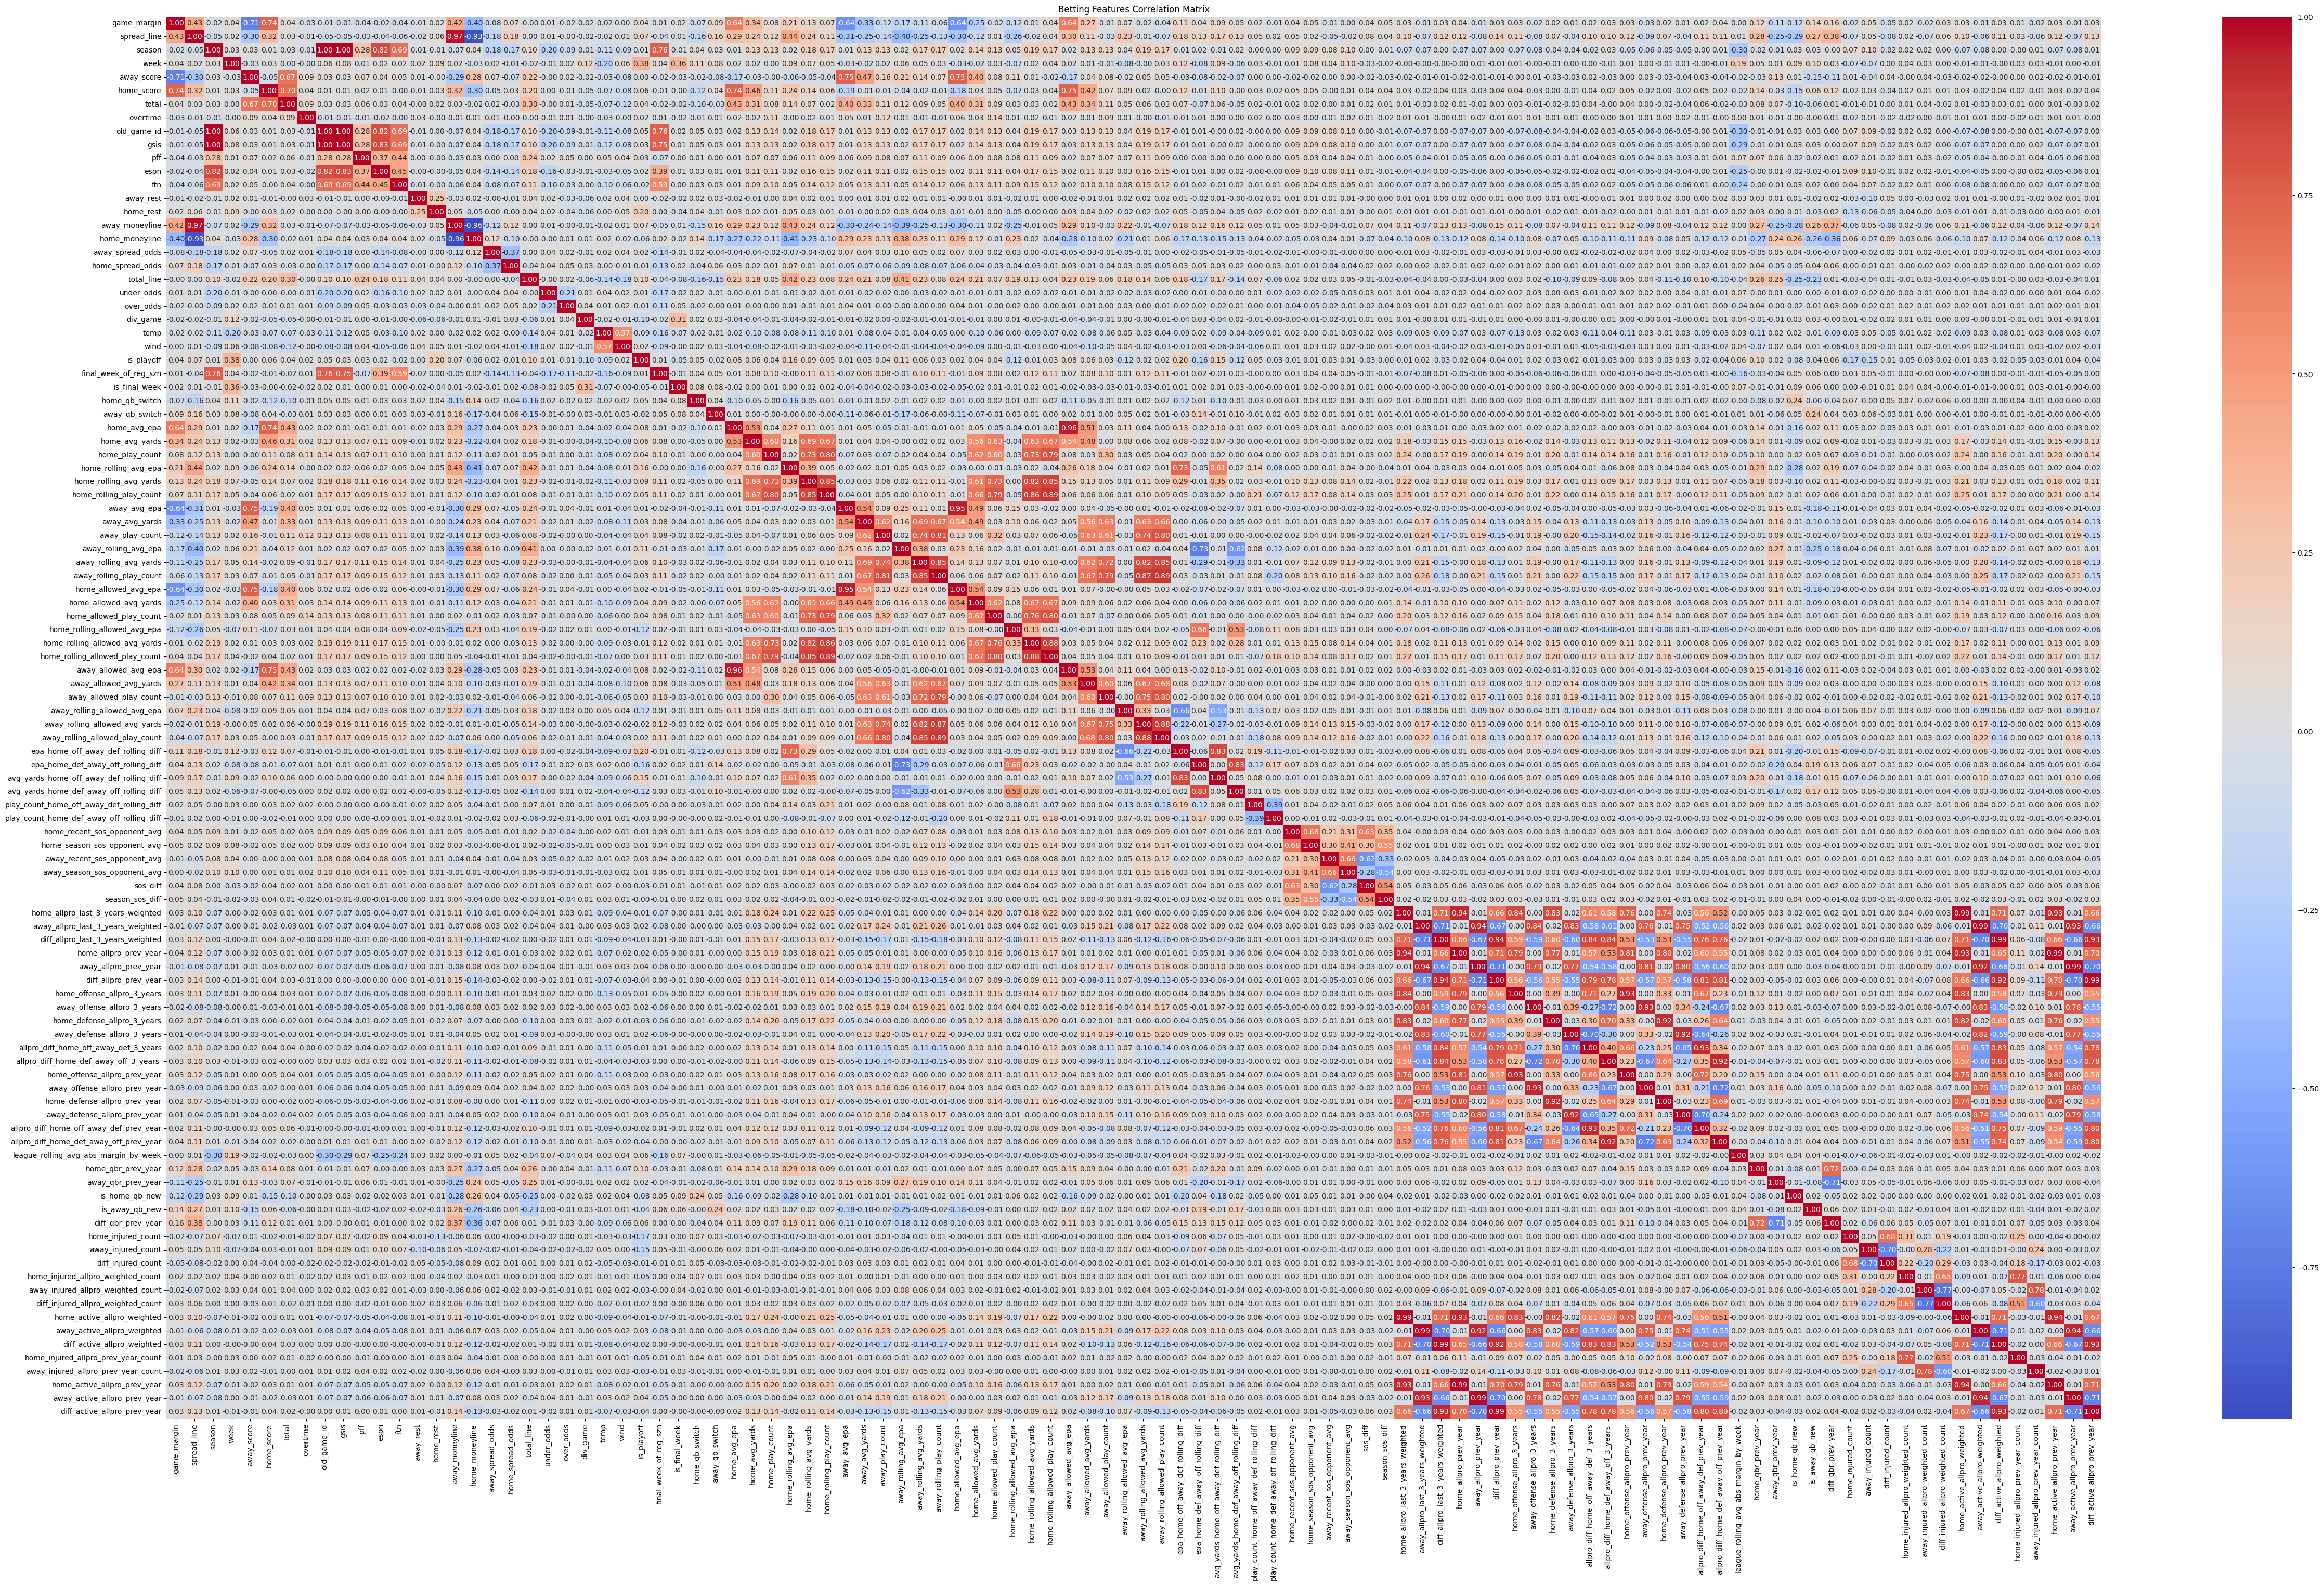

In [60]:
#correlation matrix -> core question: do any of the features in this dataset lead to high margin of victory for home team? or for away team? This is a pointless question as who wins the game would be due to many other factors.
#so would not take much away from this...nonetheless this is good to show for seeing what features might have collinearity.
#This also shows how regression may not be the best suited modeling technique for our project.

#although the recent team performance metrics are going to be correlated with winning or losing so that makes sense

corr_df = match_df.corr(numeric_only=True)
plt.figure(figsize=(60, 35))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Betting Features Correlation Matrix')
plt.show()

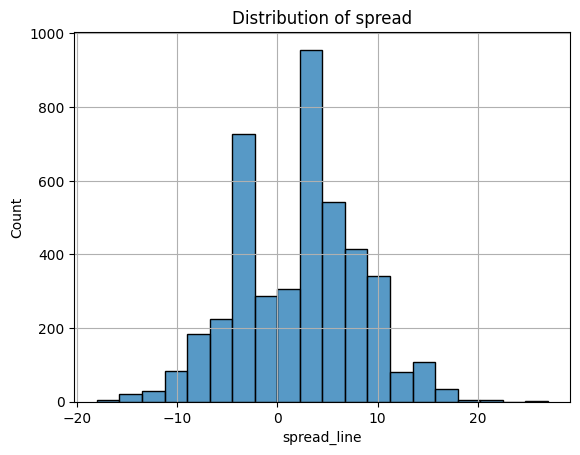

<Figure size 1500x1000 with 0 Axes>

In [61]:
#distribution of target variable. most spreads tend to be within 10 points of zero
sns.histplot(match_df['spread_line'], bins=20)
plt.grid(True)
plt.title('Distribution of spread')
plt.figure(figsize=(15, 10))
plt.show()

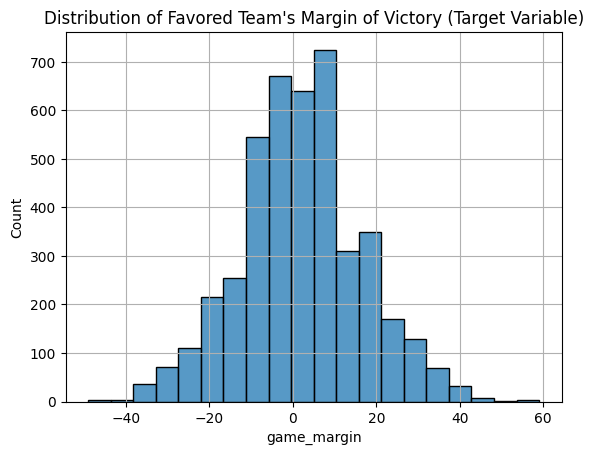

<Figure size 1500x1000 with 0 Axes>

In [62]:
#distribution of game_margin. most margins of victory are between 20 points of zero. As you can see margin of victory has a larger range compared to spread line
sns.histplot(match_df['game_margin'], bins=20)
plt.grid(True)
plt.title("Distribution of Favored Team's Margin of Victory (Target Variable)")
plt.figure(figsize=(15, 10))
plt.show()

In [63]:
# needs to match for features_df
match_df = match_df.rename(columns={'final_week_of_reg_szn': 'final_week'})
match_df.head()

game_id  game_margin  spread_line  season game_type  week  \
0  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
1  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
3  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
4  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   

      gameday   weekday gametime away_team  away_score home_team  home_score  \
0  2009-09-10  Thursday    20:30       TEN        10.0       PIT        13.0   
1  2009-09-13    Sunday    13:00       MIA         7.0       ATL        19.0   
2  2009-09-13    Sunday    13:00        KC        24.0       BAL        38.0   
3  2009-09-13    Sunday    13:00       PHI        38.0       CAR        10.0   
4  2009-09-13    Sunday    13:00       DEN        12.0       CIN         7.0   

  location  total  overtime  old_game_id     gsis nfl_detail_id           pfr  \
0     Home   23.0       1.0   2009091000  54467.0             0  200909100pit   
1     Home   26.0       0.0   2009091300  54468.0             0  200909130atl   
2     Home   62.0       0.0   2009091301  54469.0             0  200909130rav   
3     Home   48.0       0.0   2009091302  54470.0             0  200909130car   
4     Home   19.0       0.0   2009091303  54471.0             0  200909130cin   

      pff         espn  ftn  away_rest  home_rest  away_moneyline  \
0  1395.0  290910023.0  0.0          7          7           228.0   
1  1396.0  290913001.0  0.0          7          7           190.0   
2  1398.0  290913033.0  0.0          7          7           570.0   
3  1404.0  290913029.0  0.0          7          7          -125.0   
4  1403.0  290913004.0  0.0          7          7           196.0   

   home_moneyline  away_spread_odds  home_spread_odds  total_line  under_odds  \
0          -260.0            -116.0             107.0        35.5      -106.0   
1          -210.0            -104.0            -104.0        44.0      -103.0   
2          -700.0            -112.0             104.0        36.5      -103.0   
3           115.0            -120.0             111.0        43.5      -103.0   
4          -222.0            -104.0            -104.0        41.0      -112.0   

   over_odds  div_game      roof     surface  temp  wind  away_qb_id  \
0     -104.0         0  outdoors  dessograss  67.0   9.0  00-0003292   
1     -107.0         0      dome   fieldturf   0.0   0.0  00-0019559   
2     -107.0         0  outdoors   sportturf  76.0   5.0  00-0024300   
3     -107.0         0  outdoors       grass  82.0   5.0  00-0011022   
4      102.0         0  outdoors   fieldturf  73.0   7.0  00-0023541   

   home_qb_id     away_qb_name        home_qb_name      away_coach  \
0  00-0022924    Kerry Collins  Ben Roethlisberger     Jeff Fisher   
1  00-0026143  Chad Pennington           Matt Ryan    Tony Sparano   
2  00-0026158    Brodie Croyle          Joe Flacco      Todd Haley   
3  00-0004161   Donovan McNabb       Jake Delhomme       Andy Reid   
4  00-0021429       Kyle Orton       Carson Palmer  Josh McDaniels   

      home_coach         referee stadium_id                  stadium  \
0    Mike Tomlin      Bill Leavy      PIT00              Heinz Field   
1     Mike Smith    Walt Coleman      ATL00             Georgia Dome   
2  John Harbaugh  Gene Steratore      BAL00         M&T Bank Stadium   
3       John Fox  Jeff Triplette      CAR00  Bank of America Stadium   
4   Marvin Lewis    Jerome Boger      CIN00       Paul Brown Stadium   

   is_playoff  final_week  is_final_week  home_qb_switch  away_qb_switch  \
0       False          17          False           False           False   
1       False          17          False           False           False   
2       False          17          False           False           False   
3       False          17          False           False           False   
4       False          17          False 

##Modeling

###Setup

To finish setting up our dataset, we only want matches played after weeks 1 and 2 since some of our features use previous recent game data. In addition, I am dropping any feature that is not predictive since it will not be beneficial for our model. Lastly, I am dropping any row that has a nan value in it for simplicity.

In [64]:
#drop columns that we are not using as features in the initial dataset, only take data after week 3 because we don't have rolling data before then that is very accurate

'''features_df = match_df[match_df['week'] >= 3][['game_margin', 'away_rest', 'home_rest', 'total_line', 'div_game', 'roof', 'surface', 'temp', 'wind', 'home_qb_name', 'away_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium_id', 'is_playoff', 'is_final_week',
                                               'home_qb_switch', 'away_qb_switch', 'home_rolling_avg_epa', 'home_rolling_avg_yards', 'home_rolling_play_count', 'away_rolling_avg_epa', 'away_rolling_avg_yards', 'away_rolling_play_count', 'home_rolling_allowed_avg_epa',
                                               'home_rolling_allowed_avg_yards', 'home_rolling_allowed_play_count', 'away_rolling_allowed_avg_epa', 'away_rolling_allowed_avg_yards', 'away_rolling_allowed_play_count', 'home_off_away_def_rolling_epa_diff',
                                               'home_def_away_off_rolling_epa_diff', 'home_off_away_def_rolling_avg_yards_diff', 'home_def_away_off_rolling_avg_yards_diff', 'home_off_away_def_rolling_play_count_diff', 'home_def_away_off_rolling_play_count_diff',
                                               'sos_diff','season_sos_diff', 'home_allpro_last_3_years_weighted', 'away_allpro_last_3_years_weighted', 'diff_allpro_last_3_years_weighted', 'home_allpro_prev_year', 'away_allpro_prev_year', 'diff_allpro_prev_year','diff_offense_allpro_3_years',
                                               'diff_defense_allpro_3_years', 'home_offense_vs_away_defense_3_years', 'home_defense_vs_away_offense_3_years', 'diff_offense_allpro_prev_year', 'diff_defense_allpro_prev_year', 'home_offense_vs_away_defense_prev_year',
                                               'home_defense_vs_away_offense_prev_year' ]]'''

print("Total data before dropping weeks 1-2 in seasons:")
print(match_df.shape)
print('\n\n')

# added this to keep conistent with week 3 start
match_df = match_df[match_df['week'] >= 3]

#print(features_df.shape)

#change to features_df
features_df = match_df.drop(['week', 'season', 'game_type', 'gameday', 'weekday', 'gametime', 'away_team', 'home_team', 'away_score', 'home_score', 'location', 'total', 'overtime', 'old_game_id', 'gsis', 'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn',
                             'away_moneyline', 'home_moneyline', 'away_spread_odds', 'home_spread_odds', 'under_odds', 'over_odds', 'stadium', 'final_week', 'away_qb_id', 'home_qb_id', 'home_avg_epa', 'home_avg_yards', 'home_play_count', 'away_avg_epa', 'away_avg_yards', 'away_play_count',
                             'home_allowed_avg_epa', 'home_allowed_avg_yards', 'home_allowed_play_count', 'away_allowed_avg_epa', 'away_allowed_avg_yards', 'away_allowed_play_count', 'home_qb_name', 'away_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium_id', 'home_injured_allpro_prev_year_count',
                             'away_injured_allpro_prev_year_count',	'home_active_allpro_prev_year',	'away_active_allpro_prev_year','home_injured_allpro_weighted_count',	'away_injured_allpro_weighted_count',	'diff_injured_allpro_weighted_count',	'home_active_allpro_weighted',	'away_active_allpro_weighted'
                             ], axis=1)

print('total data after dropping weeks 1-2 in seasons and before dropping nan values:')
print(features_df.shape)
print('\n\n')

#drop nan values for any feature
features_df = features_df.dropna()

print('Total data after droppping nan values')
print(features_df.shape)



features_df

Total data before dropping weeks 1-2 in seasons:
(4345, 125)



total data after dropping weeks 1-2 in seasons and before dropping nan values:
(3834, 68)



Total data after droppping nan values
(3834, 68)


game_id  game_margin  spread_line  away_rest  home_rest  \
32    2009_03_CLE_BAL         31.0         13.5          7          7   
33    2009_03_WAS_DET          5.0         -6.5          7          7   
34    2009_03_JAX_HOU         -7.0          4.0          7          7   
35     2009_03_SF_MIN          3.0          7.0          7          7   
36     2009_03_ATL_NE         16.0          4.5          7          7   
...               ...          ...          ...        ...        ...   
4340   2024_20_LA_PHI          6.0          7.0          6          7   
4341  2024_20_BAL_BUF          2.0         -1.5          8          7   
4342  2024_21_WAS_PHI         32.0          6.0          8          7   
4343   2024_21_BUF_KC          3.0          1.5          7          8   
4344   2024_22_KC_PHI         18.0         -1.5         14         14   

      total_line  div_game      roof    surface  temp  wind  is_playoff  \
32          38.5         1  outdoors  sportturf  72.0   6.0       False   
33          39.5         0      dome  fieldturf   0.0   0.0       False   
34          47.0         1    closed      grass   0.0   0.0       False   
35          39.0         0      dome  fieldturf   0.0   0.0       False   
36          45.5         0  outdoors  fieldturf  62.0   0.0       False   
...          ...       ...       ...        ...   ...   ...         ...   
4340        43.5         0  outdoors      grass  34.0   8.0        True   
4341        51.5         0  outdoors     a_turf  19.0   4.0        True   
4342        46.5         1  outdoors      grass  40.0  11.0        True   
4343        49.5         0  outdoors      grass  31.0   8.0        True   
4344        48.5         0      dome  sportturf   0.0   0.0        True   

      is_final_week  home_qb_switch  away_qb_switch  home_rolling_avg_epa  \
32            False           False           False              0.139008   
33            False           False           False             -0.230076   
34            False           False           False             -0.084081   
35            False           False           False              0.089624   
36            False           False           False             -0.021698   
...             ...             ...             ...                   ...   
4340          False           False           False              0.100234   
4341          False           False           False              0.188274   
4342          False           False           False              0.077039   
4343          False           False           False             -0.004269   
4344          False           False           False              0.151505   

      home_rolling_avg_yards  home_rolling_play_count  away_rolling_avg_epa  \
32                  5.538726                     72.5             -0.281558   
33                  4.042664                     61.5             -0.054802   
34                  5.103220                     57.0             -0.092676   
35                  5.036366                     57.5             -0.015240   
36                  5.022482                     73.0              0.044920   
...                      ...                      ...                   ...   
4340                5.266704                     65.4              0.009015   
4341                6.109140                     64.0              0.277911   
4342                5.350217                     62.6              0.128645   
4343                4.823622                     56.0              0.107830   
4344                5.819643                     61.4              0.065030   

      away_rolling_avg_yards  away_rolling_play_count  \
32                  4.060606                     57.5   
33                  5.451343                     58.5   
34                  4.811834                     61.5   
35                  4.850000                     60.0   
36                  5.196825                     63.0   
...                 

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

###Random Forest Regressor - Initial Model

We decided to use a random forest regressor because it handles nonlinear data well, works well with a broad range of features, is good with overfitting, and allows for feature importance.

The goal of this initial RF Regressor Model is to reduce the features that we are using in future models and further in our project. Right now we are using too many features and need to hone down on more influential features that impact game margin.

In the initial run through, the goal is not to have an incredibly well performing model.

Sources

https://www.geeksforgeeks.org/machine-learning/categorical-data-encoding-techniques-in-machine-learning/

https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [123]:
def random_forest_regressor_v1(features_df, model_depth=None, threshold=.5):

    #features
    game_ids = features_df['game_id'].reset_index(drop=True)
    spread = features_df['spread_line'].reset_index(drop=True)
    X = features_df.drop(columns=['game_margin', 'game_id', 'spread_line'])
    #target variable
    y = features_df['game_margin'].reset_index(drop=True)

    #random forest model only works with numbers so we need to encode categorical features into a number of some sort
    #Using One Hot Encoding because while none of the categorical variables have an order to them we don't want the model to pick up any 'fake ordering'

    #converts each category to binary value
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    quan_features = [col for col in X.columns if col not in cat_features]

    #checks categorical columns are all strings
    X[cat_features] = X[cat_features].astype(str)

    print("Number of Features:")
    print(len(quan_features) + len(cat_features))
    print('\n\n')
    print("Name of Features - Categorical and Quantative Respectively:")
    print(cat_features)
    print('\n\n')
    print(quan_features)
    print('\n\n')

    #encode categorical features
    cat_feature_encoding = ColumnTransformer([("cat_features", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)], remainder='passthrough')

    X_encoded = cat_feature_encoding.fit_transform(X)
    new_cat_feat_names = cat_feature_encoding.named_transformers_['cat_features'].get_feature_names_out(cat_features)
    updated_feats = list(new_cat_feat_names) + list(quan_features)
    X_updated = pd.DataFrame(X_encoded, columns=updated_feats)
    X_updated = X_updated.astype(float)

    print("Features After Encoding:")
    print(X_updated.columns)
    print('\n\n')

    X_train, X_test, y_train, y_test, game_ids_train, game_ids_test, spread_train, spread_test = train_test_split(X_updated, y, game_ids, spread, test_size=0.2, random_state=3)
    #X_train, X_test, y_train, y_test = train_test_split(X_updated, y, test_size=0.2, random_state=3)

    rf_reg = RandomForestRegressor(n_estimators=100, random_state=3, max_depth=model_depth)
    rf_reg.fit(X_train, y_train)

    train_pred = rf_reg.predict(X_train)
    test_pred = rf_reg.predict(X_test)
    test_pred_rounded = np.round(test_pred * 2) / 2

    #spread = X_test['spread_line']

    #evaluate model
    eval_df = pd.DataFrame({
        'game_id': game_ids_test,
        'game_margin': y_test,
        'model_prediction': test_pred_rounded,
        'spread': spread_test
    })

    #remove pushes
    eval_df = eval_df[eval_df['game_margin'] != eval_df['spread']].copy()
    eval_df = eval_df[eval_df['model_prediction'] != eval_df['spread']].copy()

    #diff
    eval_df['model_vs_spread_diff'] = np.abs(eval_df['model_prediction'] - eval_df['spread'])
    true_bets_df = eval_df[eval_df['model_vs_spread_diff'] >= 1].copy()

    eval_df['model_error'] = np.abs(eval_df['game_margin'] - eval_df['model_prediction'])
    eval_df['spread_error'] = np.abs(eval_df['game_margin'] - eval_df['spread'])

    eval_df['model_vs_spread'] = eval_df['model_error'] < eval_df['spread_error']

    winning_percentage = eval_df['model_vs_spread'].mean()

    print(f"Model beat spread in {winning_percentage*100:.2f}% of the time")
    print('\n\n')

    plt.hist(eval_df['model_error'], bins=20, alpha=0.6, label='Model')
    plt.legend()
    plt.title('Model Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()
    print('\n\n')

    plt.hist(eval_df['spread_error'], bins=20, alpha=0.6, label='Spread')
    plt.legend()
    plt.title('Spread Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()
    print('\n\n')

    #true betting edge percentage
    print("Substantial Differences: ")
    print(len(true_bets_df))
    print('\n\n')
    true_bets_df['model_error'] = np.abs(true_bets_df['game_margin'] - true_bets_df['model_prediction'])
    true_bets_df['spread_error'] = np.abs(true_bets_df['game_margin'] - true_bets_df['spread'])

    true_bets_df['model_vs_spread'] = true_bets_df['model_error'] < true_bets_df['spread_error']

    winning_percentage = true_bets_df['model_vs_spread'].mean()

    print(f"Most Important Value - True Bets - Model beat spread in {winning_percentage*100:.2f}% of the time")
    print('\n\n')

    plt.hist(true_bets_df['model_error'], bins=30, alpha=0.6, label='Model')
    plt.legend()
    plt.title('True Bets - Model Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()
    print('\n\n')

    plt.hist(true_bets_df['spread_error'], bins=30, alpha=0.6, label='Spread')
    plt.legend()
    plt.title('True Bets - Spread Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()

    print('\n\n')
    print("TRAIN MAE:")
    print(mean_absolute_error(y_train, train_pred))
    print('\n\n')

    print("TRAIN R²:")
    print(r2_score(y_train, train_pred))
    print('\n\n')

    print("TEST MAE:")
    print(mean_absolute_error(y_test, test_pred))
    print('\n\n')

    print("TEST R²:")
    print(r2_score(y_test, test_pred))
    print('\n\n')

    #Calculating the feature importance
    feature_importance = rf_reg.feature_importances_
    feature_importance = 100.0*(feature_importance/np.sum(feature_importance))

    #Get top 20 feature since there are so many
    top_x = 20
    top_idx = np.argsort(feature_importance)[-top_x:]
    top_idx = top_idx[np.argsort(feature_importance[top_idx])[::-1]]

    updated_feats_arr = np.array(updated_feats)
    top_features = updated_feats_arr[top_idx]

    print(top_features)
    print('\n\n')
    top_importance = feature_importance[top_idx]
    print(top_importance)
    print('\n\n')

    #plotting the top 20 features for my random forest regressor
    plt.figure(figsize=(10, 10))
    plt.barh(np.arange(top_x), top_importance[::-1], color='crimson', align='center')
    plt.yticks(np.arange(top_x), top_features[::-1])
    plt.xlabel('Relative Importance (%)')
    plt.title('RF Reg - Feature Importance - Top 20 Features')
    plt.tight_layout()
    plt.show()

    #drop low importance features and return updated df
    low_idx = np.where(feature_importance < threshold)[0]
    low_feat_names = np.array(updated_feats)[low_idx].tolist()

    print('\n\n')
    print(f"{len(low_feat_names)} features with importance < {threshold}%")
    print('\n\n')

    #drop low importance features from encoded X
    X_filtered = X_updated.drop(columns=low_feat_names)

    print("len of features above threshold:")
    print(len(X_filtered.columns))
    print('\n\n')

    # Combine with y and return
    updated_df = pd.concat([X_filtered, y.reset_index(drop=True), game_ids.reset_index(drop=True), spread.reset_index(drop=True)], axis=1)
    return rf_reg, updated_df, low_feat_names, true_bets_df


Number of Features:
65



Name of Features - Categorical and Quantative Respectively:
['roof', 'surface']



['away_rest', 'home_rest', 'total_line', 'div_game', 'temp', 'wind', 'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'home_rolling_avg_epa', 'home_rolling_avg_yards', 'home_rolling_play_count', 'away_rolling_avg_epa', 'away_rolling_avg_yards', 'away_rolling_play_count', 'home_rolling_allowed_avg_epa', 'home_rolling_allowed_avg_yards', 'home_rolling_allowed_play_count', 'away_rolling_allowed_avg_epa', 'away_rolling_allowed_avg_yards', 'away_rolling_allowed_play_count', 'epa_home_off_away_def_rolling_diff', 'epa_home_def_away_off_rolling_diff', 'avg_yards_home_off_away_def_rolling_diff', 'avg_yards_home_def_away_off_rolling_diff', 'play_count_home_off_away_def_rolling_diff', 'play_count_home_def_away_off_rolling_diff', 'home_recent_sos_opponent_avg', 'home_season_sos_opponent_avg', 'away_recent_sos_opponent_avg', 'away_season_sos_opponent_avg', 'sos_diff', 'seas

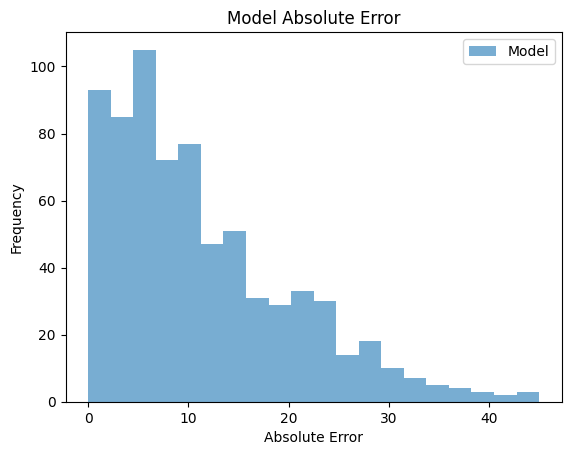

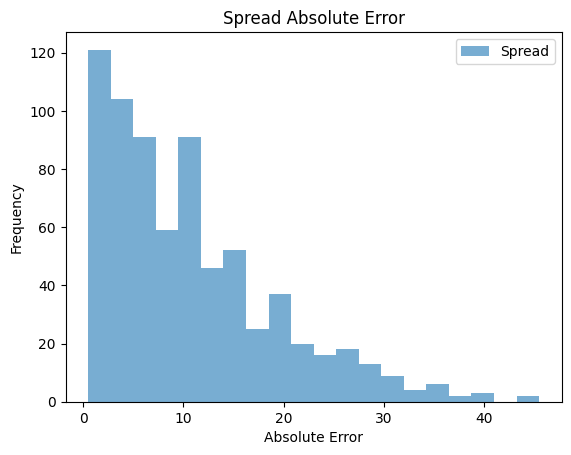




Substantial Differences: 
657



Most Important Value - True Bets - Model beat spread in 44.60% of the time





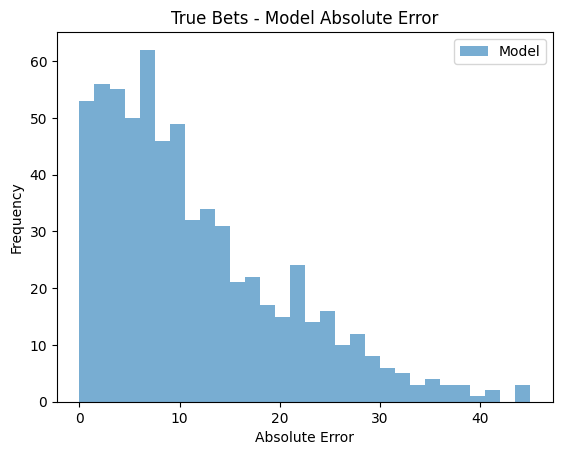

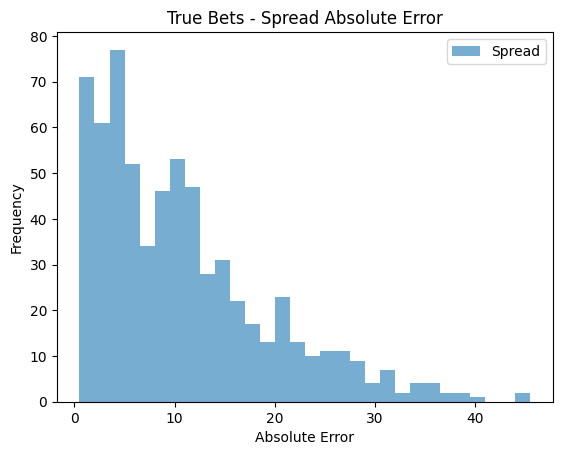




TRAIN MAE:
4.0365373328985985



TRAIN R²:
0.8721799433332313



TEST MAE:
11.05663624511082



TEST R²:
0.07531769303927216



['home_rolling_avg_epa' 'away_rolling_avg_epa'
 'home_rolling_allowed_avg_epa' 'away_qbr_prev_year'
 'away_rolling_avg_yards' 'league_rolling_avg_abs_margin_by_week'
 'away_rolling_allowed_avg_epa' 'diff_qbr_prev_year'
 'home_rolling_avg_yards' 'home_recent_sos_opponent_avg'
 'home_qbr_prev_year' 'home_rolling_allowed_avg_yards'
 'away_season_sos_opponent_avg' 'away_recent_sos_opponent_avg'
 'season_sos_diff' 'home_season_sos_opponent_avg'
 'home_rolling_play_count' 'away_rolling_play_count' 'sos_diff'
 'away_rolling_allowed_avg_yards']



[7.53723732 5.09566059 3.46097834 3.18376391 2.82795475 2.77408505
 2.75637087 2.75135684 2.72004181 2.69073304 2.67982041 2.6067985
 2.55417138 2.51976191 2.48897972 2.4260001  2.26075779 2.14702957
 2.11991495 2.10629402]





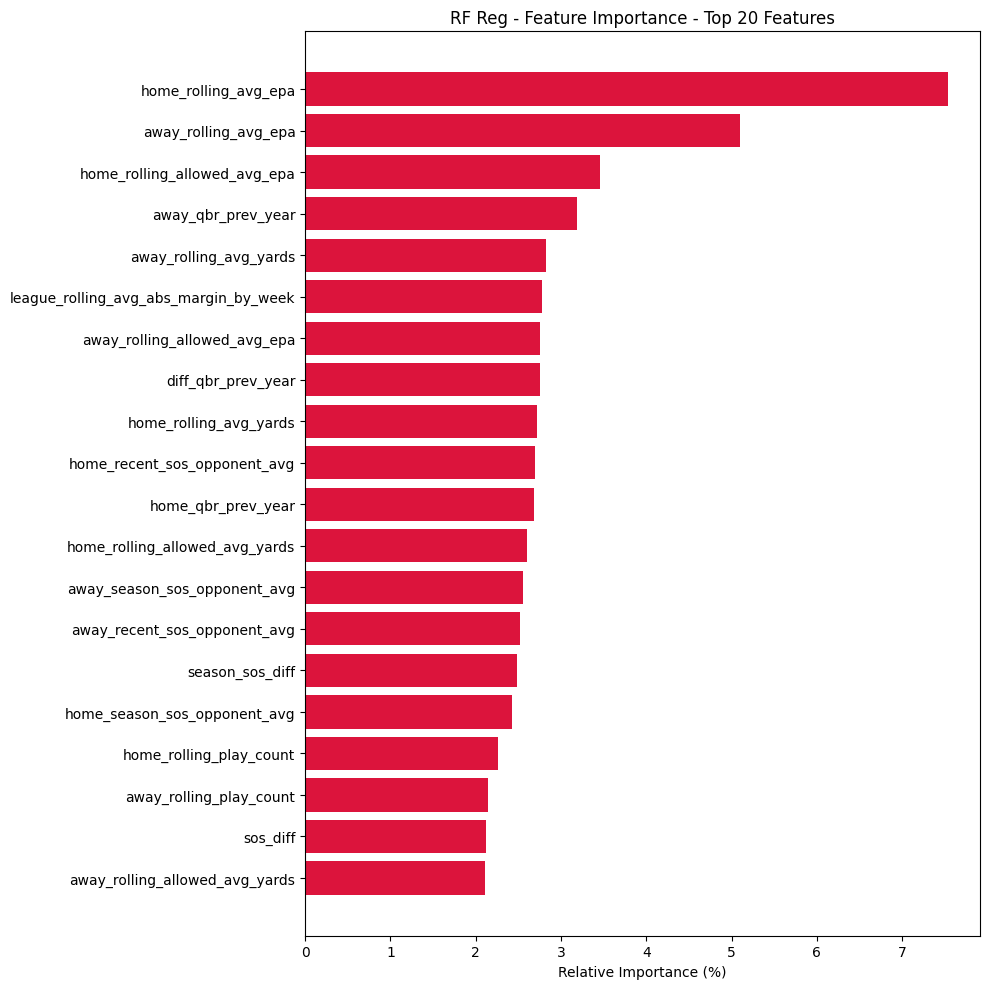




30 features with importance < 0.5%



len of features above threshold:
47





In [124]:
init_model, _, _, eval_df = random_forest_regressor_v1(features_df)

In [125]:
#for matches where my model predicts a spread at least a difference of one point more or less than the spread line
eval_df.head(10)

game_id  game_margin  model_prediction  spread  \
1480  2015_07_DAL_NYG          7.0               5.0     3.0   
1510  2015_10_BUF_NYJ         -5.0               6.0     2.5   
3809   2024_18_CHI_GB         -2.0              13.0    10.0   
3826   2024_19_MIN_LA         18.0               1.0    -2.5   
1099   2013_13_NO_SEA         27.0               2.5     6.5   
6      2009_03_KC_PHI         20.0               3.5     7.5   
623   2011_13_NYJ_WAS        -15.0              -6.0    -3.0   
577   2011_10_ARI_PHI         -4.0              10.0    13.5   
3024  2021_16_JAX_NYJ          5.0               3.5     2.5   
2958   2021_12_BUF_NO        -25.0              -5.5    -7.0   

      model_vs_spread_diff  model_error  spread_error  model_vs_spread  
1480                   2.0          2.0           4.0             True  
1510                   3.5         11.0           7.5            False  
3809                   3.0         15.0          12.0            False  
3826                   3.5         17.0          20.5             True  
1099                   4.0         24.5          20.5            False  
6                      4.0         16.5          12.5            False  
623                    3.0          9.0          12.0             True  
577                    3.5         14.0          17.5             True  
3024                   1.0          1.5           2.5             True  
2958                   1.5         19.5          18.0            False

As you can see we are overfitting heavily. This is due to not having any hyperparams to stop depth and feature redundance.

Even still the MAE for our model is 10.99 which means, on average, our model predicted a game margin off by approximately 10.99 points from the real value.

Typically, NFL game margins are single digit. This means we are performing worse than just predicting the mean margin. NFL games are noisy. Game margins can vary heavily by just one play.

An R-squared score of 7.86% means our model explains 7.86% of the variance in game margin. This is low, but not unexpected as the NFL and sports in general are very noisy.

We currently beat the spread 46% of the time and on bets where there is a differential of 1 or more between the model and the spread line we win 43.77% of the time.

The most important features for our model our shown above. EPA seems to be the most important feature(s) by far.

I tried the model with the spread line but it seemed to perform worse. It is a debate on if we should add that or not.

Model minimized error based on the features given. Shows which features are important overall.

Based off our model and feature importance report:

Drop the bottom features (those with near-zero importance). Hopefully this will lessen overfitting and increase generalization.

After encoding we had 75 features. Only 47 of those had a feature importance above .5%.

Multicollinearity is ok, but can still reduce redundancy in feature set.

Focus and refine on top 5 to 10 features. Fully flesh out those features in whatevery ways necessary.

Looking at feature importance from other models can give us a good understanding of commonality in features among them.

###2nd Interation of RF Regressor

For instance, one thing adjusted after an initial look at the model is combining rolling epa, rolling avg yards, and rolling play count of away and home teams into a two differential feature for each category. One differential is home offense vs away defense. The other is away offense vs home defense.

We also combined some other away vs home team features into diff features to reduce feature count.

This should clear up clutter and reduce high correlation between features.

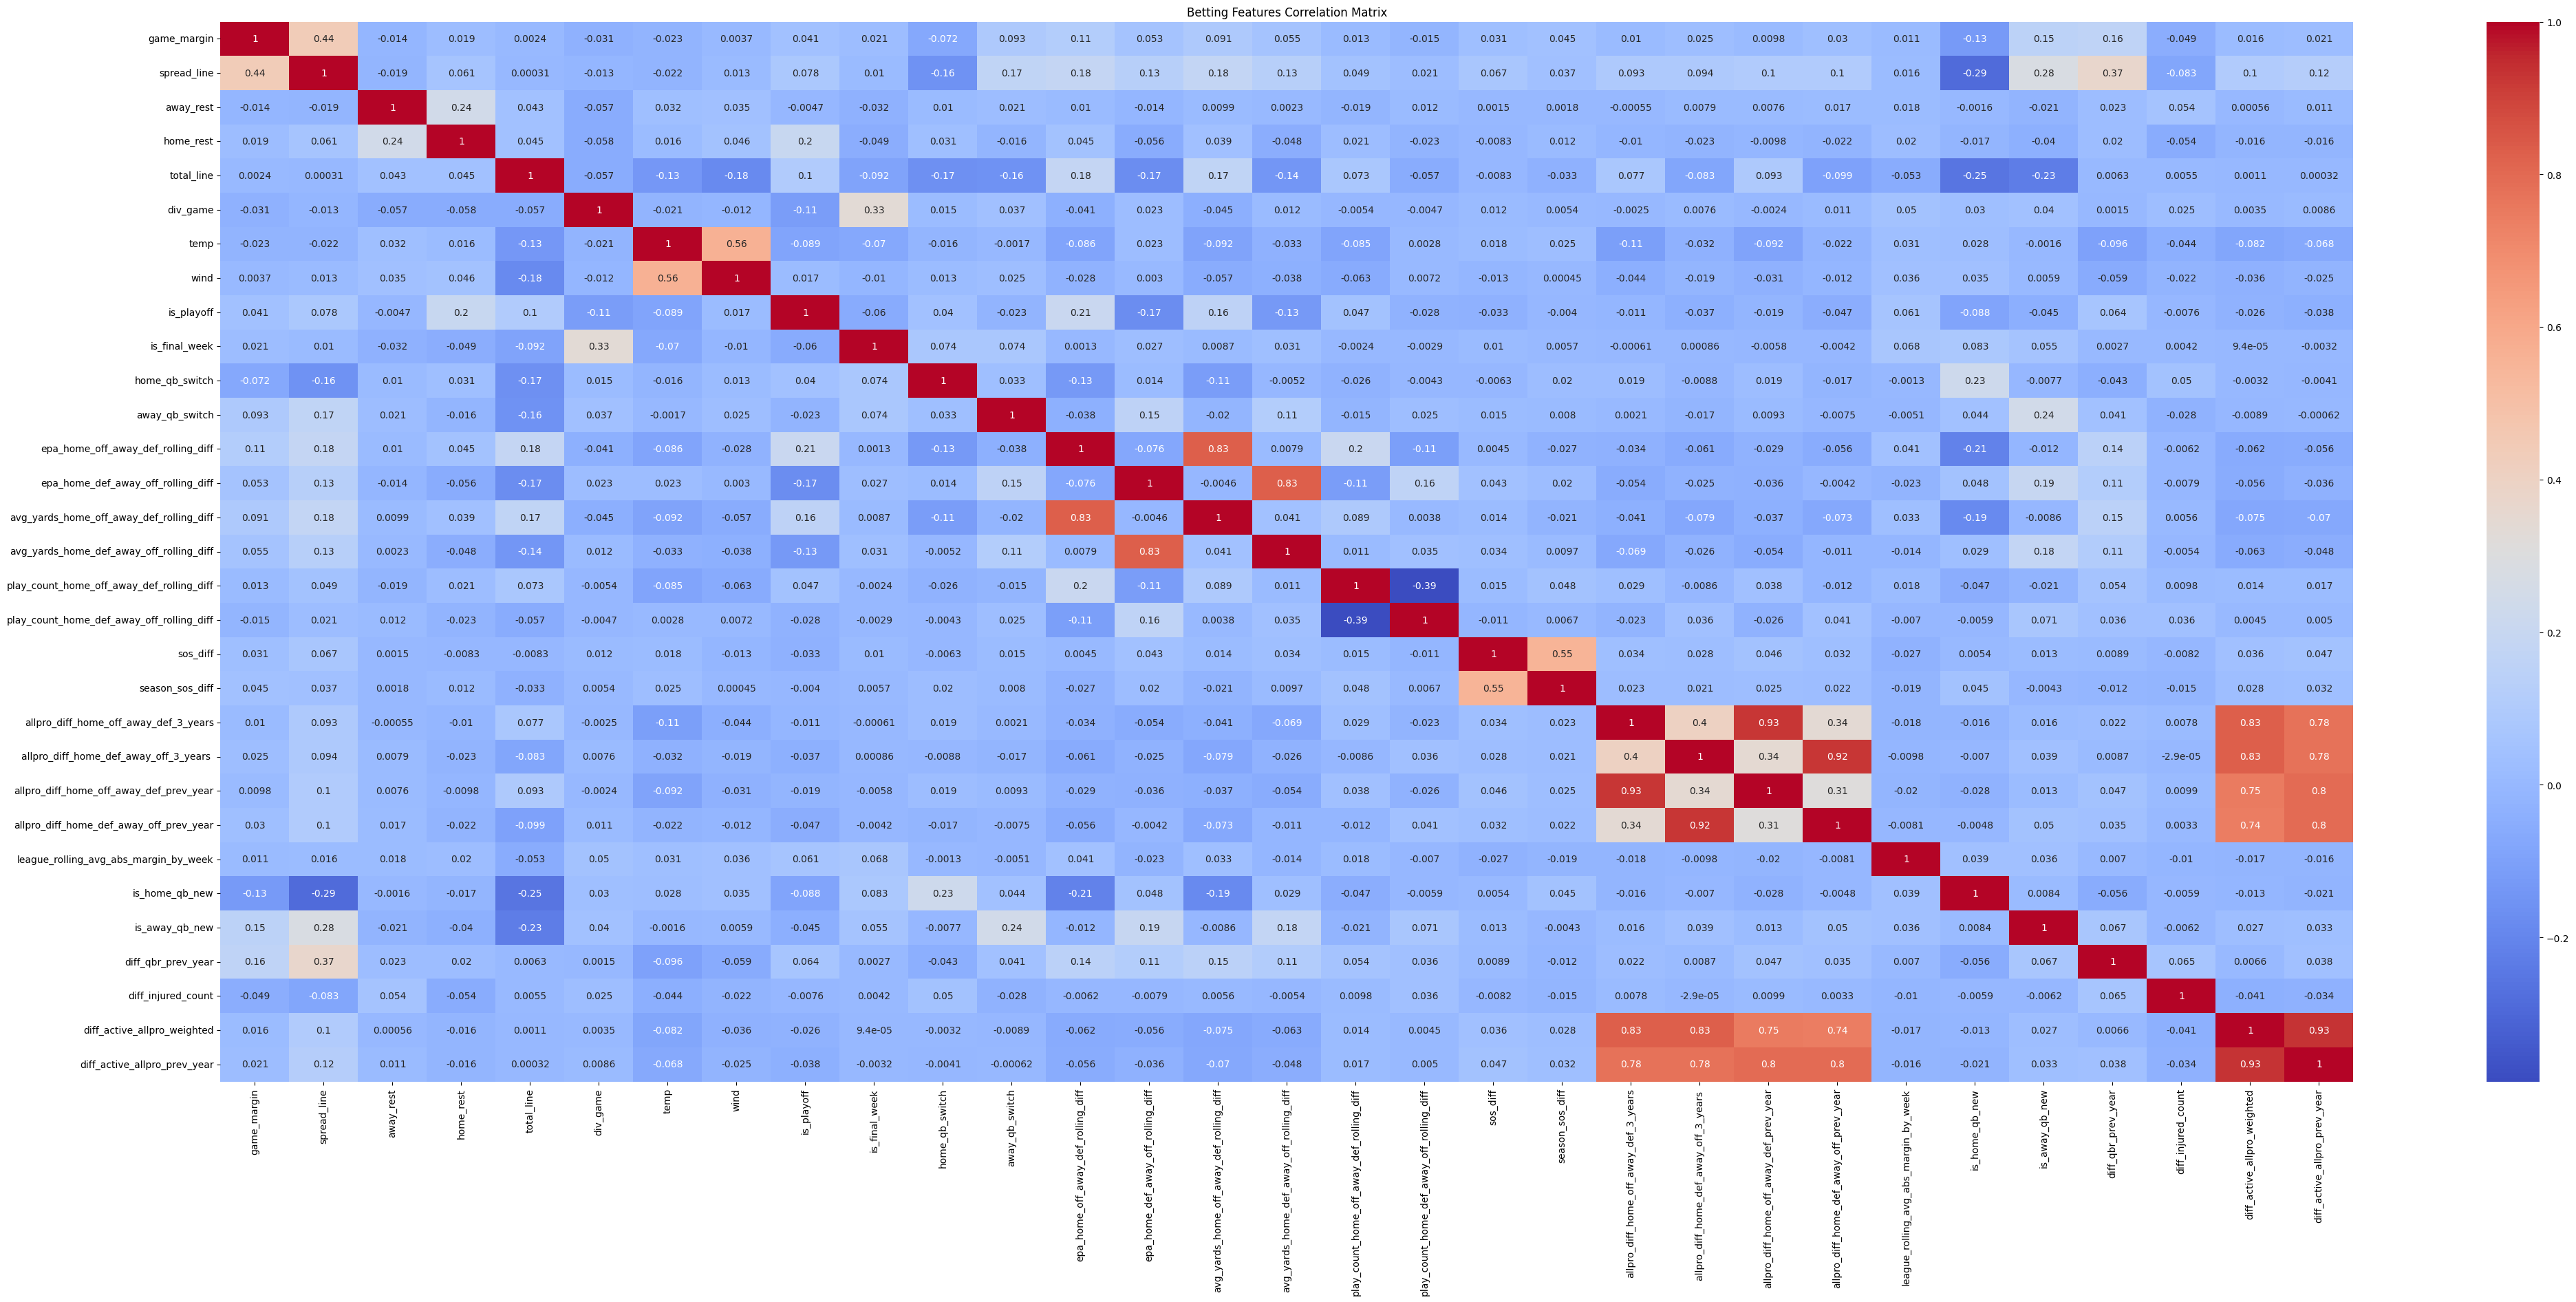

In [126]:
#after RF regressor, updating features to combine epa, avg yards, and play count (home off vs away def and home def vs away off)

#removing redundant features - keeping diffs
reduced_features_df = features_df.drop(['home_rolling_avg_epa', 'home_rolling_avg_yards', 'home_rolling_play_count',
                                        'away_rolling_avg_epa', 'away_rolling_avg_yards', 'away_rolling_play_count',
                                        'home_rolling_allowed_avg_epa', 'home_rolling_allowed_avg_yards', 'home_rolling_allowed_play_count',
                                        'away_rolling_allowed_avg_epa', 'away_rolling_allowed_avg_yards', 'away_rolling_allowed_play_count',
                                        'home_recent_sos_opponent_avg', 'home_season_sos_opponent_avg', 'away_recent_sos_opponent_avg', 'away_season_sos_opponent_avg',
                                        'home_allpro_last_3_years_weighted', 'away_allpro_last_3_years_weighted', 'diff_allpro_last_3_years_weighted', 'home_allpro_prev_year', 'away_allpro_prev_year', 'diff_allpro_prev_year',
                                        'home_offense_allpro_3_years', 'away_offense_allpro_3_years', 'home_defense_allpro_3_years', 'away_defense_allpro_3_years',
                                        'home_offense_allpro_prev_year', 'away_offense_allpro_prev_year', 'home_defense_allpro_prev_year', 'away_defense_allpro_prev_year',
                                        'home_qbr_prev_year', 'away_qbr_prev_year', 'home_injured_count', 'away_injured_count'], axis=1)

#will need to remove features that are highly correlated
corr_df = reduced_features_df.corr(numeric_only=True)
plt.figure(figsize=(50, 20))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Betting Features Correlation Matrix')
plt.show()

**Multicollinearity hurts linear models, not trees.**

these are some of our main qualitative features in a heatmap for context after reducing feature set

We went from 61 features to 31 features. Of course with encoding we are still at 1110.



Number of Features:
31



Name of Features - Categorical and Quantative Respectively:
['roof', 'surface']



['away_rest', 'home_rest', 'total_line', 'div_game', 'temp', 'wind', 'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'epa_home_off_away_def_rolling_diff', 'epa_home_def_away_off_rolling_diff', 'avg_yards_home_off_away_def_rolling_diff', 'avg_yards_home_def_away_off_rolling_diff', 'play_count_home_off_away_def_rolling_diff', 'play_count_home_def_away_off_rolling_diff', 'sos_diff', 'season_sos_diff', 'allpro_diff_home_off_away_def_3_years', 'allpro_diff_home_def_away_off_3_years ', 'allpro_diff_home_off_away_def_prev_year', 'allpro_diff_home_def_away_off_prev_year', 'league_rolling_avg_abs_margin_by_week', 'is_home_qb_new', 'is_away_qb_new', 'diff_qbr_prev_year', 'diff_injured_count', 'diff_active_allpro_weighted', 'diff_active_allpro_prev_year']



Features After Encoding:
Index(['roof_closed', 'roof_dome', 'roof_open', 'roof_outdoors', 'surface_0',
       'sur

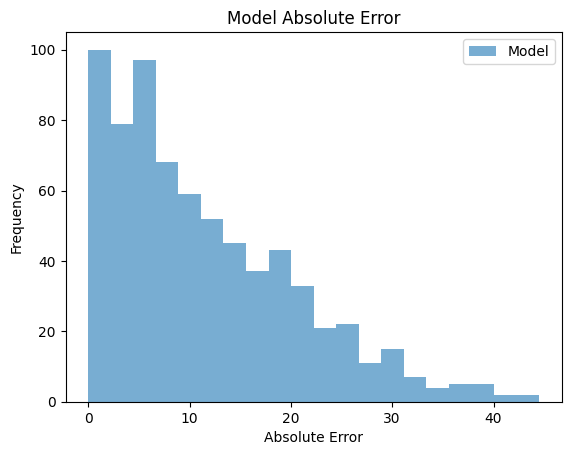

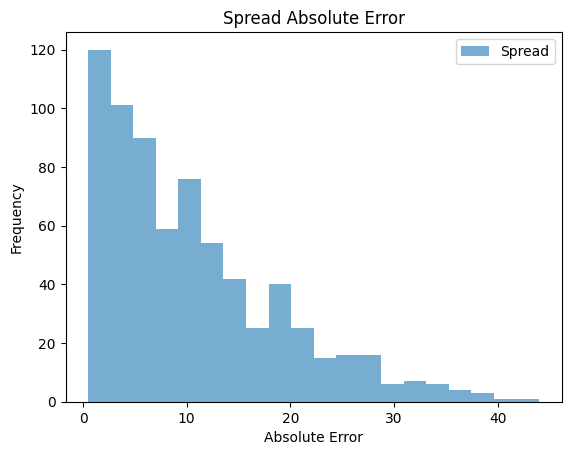




Substantial Differences: 
652



Most Important Value - True Bets - Model beat spread in 42.18% of the time





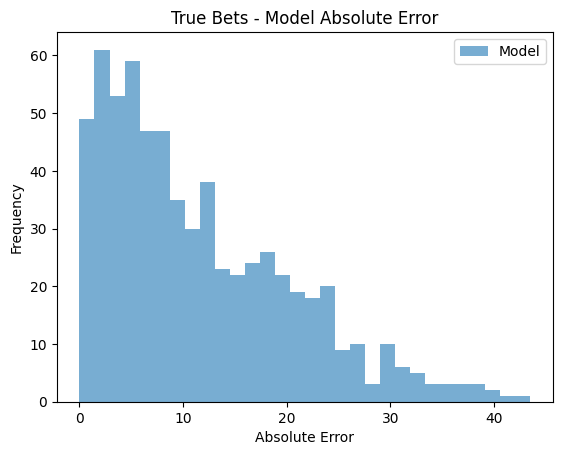

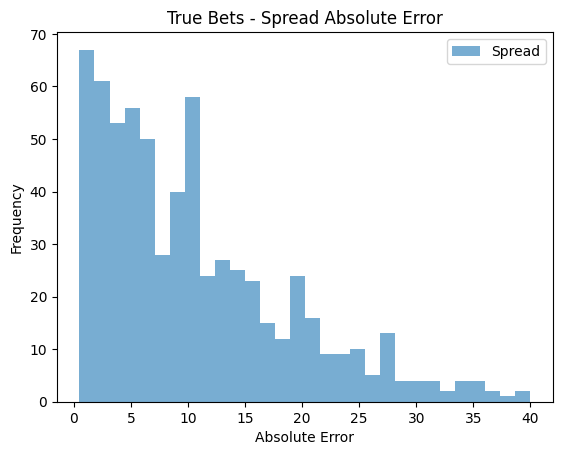




TRAIN MAE:
8.315987618251942



TRAIN R²:
0.48774558050574257



TEST MAE:
11.306583510832928



TEST R²:
0.04014820051240553



['diff_qbr_prev_year' 'season_sos_diff'
 'epa_home_off_away_def_rolling_diff' 'sos_diff'
 'league_rolling_avg_abs_margin_by_week'
 'avg_yards_home_off_away_def_rolling_diff' 'total_line'
 'epa_home_def_away_off_rolling_diff'
 'play_count_home_off_away_def_rolling_diff'
 'play_count_home_def_away_off_rolling_diff'
 'avg_yards_home_def_away_off_rolling_diff'
 'allpro_diff_home_def_away_off_3_years ' 'is_away_qb_new'
 'diff_injured_count' 'temp' 'diff_active_allpro_weighted'
 'is_home_qb_new' 'wind' 'allpro_diff_home_off_away_def_3_years'
 'away_rest']



[10.67745027  7.20819316  6.39123784  6.24023027  5.06999407  4.99642877
  4.66764364  4.65521452  4.58963462  4.36473419  4.33504318  3.9493508
  3.86774797  3.30227559  3.20374873  3.14755381  2.84119596  2.72872108
  2.51010998  1.60882217]





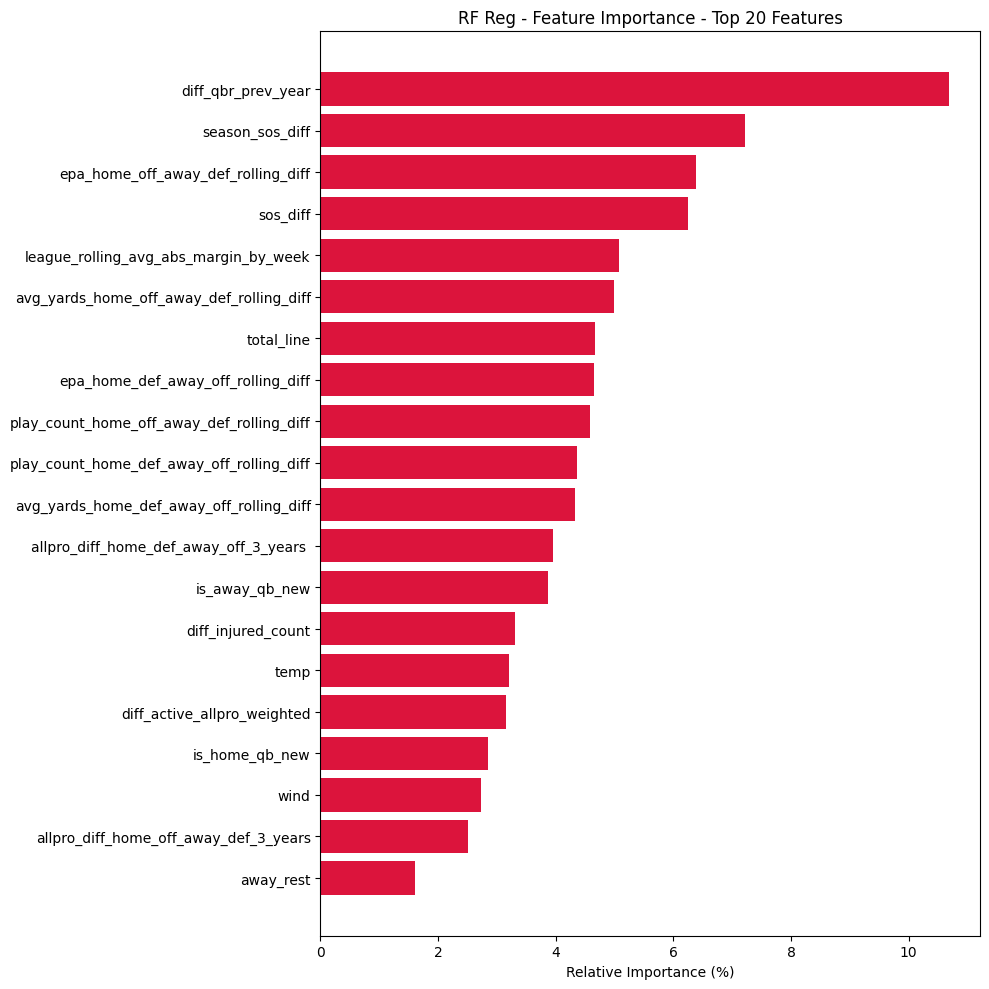




19 features with importance < 1%



len of features above threshold:
24





In [127]:
#all pro prev year mae = 10.63. r2 = .0903, all pro last 3 years weighted mae = 10.66, r2 = .0803 -> keep all pro prev year
#no_corr_features = reduced_features_df.drop(['diff_home_def_away_off_prev_year', 'diff_home_off_away_def_prev_year'], axis=1)

rf_reg, updated_df, dropped_features, true_bets_df = random_forest_regressor_v1(reduced_features_df, model_depth=10, threshold=1)

In [128]:
true_bets_df.head()

game_id  game_margin  model_prediction  spread  \
1480  2015_07_DAL_NYG          7.0               2.0     3.0   
1770  2016_11_PHI_SEA         11.0               7.5     6.5   
915   2012_17_BAL_CIN          6.0               1.5     5.5   
1510  2015_10_BUF_NYJ         -5.0               5.0     2.5   
3809   2024_18_CHI_GB         -2.0               5.5    10.0   

      model_vs_spread_diff  model_error  spread_error  model_vs_spread  
1480                   1.0          5.0           4.0            False  
1770                   1.0          3.5           4.5             True  
915                    4.0          4.5           0.5            False  
1510                   2.5         10.0           7.5            False  
3809                   4.5          7.5          12.0             True

Now we have 41 features after encoding.

We added depth to our model making our test evaluation much closer to our train evaluation. This is a good sign in reduction of overfitting. It is still performing lower than I had hoped though.

The MAE for our model is 11.27 which means, on average, our model predicted a game margin off by approximately 11.27 points from the real value.

Better than our previous model.

An R-squared score of 4.53% means our model explains 4.53% of the variance in game margin. This is a slight decrease from the previous model.

Our winning percentage drops slightly too.

Hard to take much away as collinearity can actually help random forest models by removing noise.

By looking at our feature importance, it looks a lot more diverse after combining some of the highly correlated features. This is good for a more genearlized model moving further into our project.

22 features had a feature importance above 1%.

Next, we can improve the feature set even further if we remove the bottom features.

###3rd iteration

source - https://scikit-learn.org/stable/modules/grid_search.html

Using grid search to help find good hyperparams - takes a long time so i did one hyperparam at a time.

In [129]:
def random_forest_regressor_v2(features_df):

    #features
    game_ids = features_df['game_id'].reset_index(drop=True)
    spread = features_df['spread_line'].reset_index(drop=True)
    X = features_df.drop(columns=['game_margin', 'game_id', 'spread_line'])
    X_updated = X.astype(float)
    #target variable
    y = features_df['game_margin'].reset_index(drop=True)

    print("Number of features:")
    print(len(X_updated.columns))
    print('\n\n')
    print("Name of features:")
    print(X_updated.columns)
    print('\n\n')

    X_train, X_test, y_train, y_test, game_ids_train, game_ids_test, spread_train, spread_test = train_test_split(X_updated, y, game_ids, spread, test_size=0.2, random_state=3)
    #X_train, X_test, y_train, y_test = train_test_split(X_updated, y, test_size=0.2, random_state=3)
    rf_reg = RandomForestRegressor(random_state=3)

    #grid search
    grid = {
        'n_estimators': [500],
        'max_depth': [10],
        'min_samples_split': [175], #175
        'min_samples_leaf': [40], #40
        'max_features': [None],
        'criterion': ['absolute_error']
    }

    gs = GridSearchCV(estimator=rf_reg, param_grid=grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
    gs.fit(X_train, y_train)

    grid_model = gs.best_estimator_
    print("\nBest hyperparameters:")
    print(gs.best_params_)

    print(f"\n\nBest CV MAE: {-gs.best_score_:.4f}")
    print('\n\n')

    #rf_reg = RandomForestRegressor(n_estimators=100, random_state=3, max_depth=model_depth)
    #rf_reg.fit(X_train, y_train)

    test_pred = grid_model.predict(X_test)
    train_pred = grid_model.predict(X_train)
    test_pred_rounded = np.round(test_pred * 2) / 2

    #spread = X_test['spread_line']

    #evaluate model
    eval_df = pd.DataFrame({
        'game_id': game_ids_test,
        'game_margin': y_test,
        'model_prediction': test_pred_rounded,
        'spread': spread_test
    })


    #remove pushes
    eval_df = eval_df[eval_df['game_margin'] != eval_df['spread']].copy()
    eval_df = eval_df[eval_df['model_prediction'] != eval_df['spread']].copy()

    #diff
    eval_df['model_vs_spread_diff'] = np.abs(eval_df['model_prediction'] - eval_df['spread'])
    true_bets_df = eval_df[eval_df['model_vs_spread_diff'] >= 1].copy()

    eval_df['model_error'] = np.abs(eval_df['game_margin'] - eval_df['model_prediction'])
    eval_df['spread_error'] = np.abs(eval_df['game_margin'] - eval_df['spread'])

    eval_df['model_vs_spread'] = eval_df['model_error'] < eval_df['spread_error']

    winning_percentage = eval_df['model_vs_spread'].mean()

    print(f"Model beat spread in {winning_percentage*100:.2f}% of the time")
    print('\n\n')

    plt.hist(eval_df['model_error'], bins=20, alpha=0.6, label='Model')
    plt.legend()
    plt.title('Model Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()
    print('\n\n')

    plt.hist(eval_df['spread_error'], bins=20, alpha=0.6, label='Spread')
    plt.legend()
    plt.title('Spread Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()
    print('\n\n')

    #true betting edge percentage
    print("Substantial Differences: ")
    print(len(true_bets_df))
    print('\n\n')
    true_bets_df['model_error'] = np.abs(true_bets_df['game_margin'] - true_bets_df['model_prediction'])
    true_bets_df['spread_error'] = np.abs(true_bets_df['game_margin'] - true_bets_df['spread'])

    true_bets_df['model_vs_spread'] = true_bets_df['model_error'] < true_bets_df['spread_error']

    winning_percentage = true_bets_df['model_vs_spread'].mean()

    print(f"Most Important Value - True Bets - Model beat spread in {winning_percentage*100:.2f}% of the time")
    print('\n\n')

    plt.hist(true_bets_df['model_error'], bins=30, alpha=0.6, label='Model')
    plt.legend()
    plt.title('True Bets - Model Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()
    print('\n\n')

    plt.hist(true_bets_df['spread_error'], bins=30, alpha=0.6, label='Spread')
    plt.legend()
    plt.title('True Bets - Spread Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()

    print('\n\n')
    print("TRAIN MAE:")
    print(mean_absolute_error(y_train, train_pred))
    print('\n\n')

    print("TRAIN R²:")
    print(r2_score(y_train, train_pred))
    print('\n\n')

    print("TEST MAE:")
    print(mean_absolute_error(y_test, test_pred))
    print('\n\n')

    print("TEST R²:")
    print(r2_score(y_test, test_pred))
    print('\n\n')

    #cross validation - takes really long and not neccesary for now
    '''cv_mae_pred = cross_val_score(rf_reg, X_updated, y, cv=5, scoring='neg_mean_absolute_error')
    cv_mae_pred = -cv_mae_pred
    print(f"Cross-validated MAE scores: {cv_mae_pred}")
    print(f"Mean CV MAE: {cv_mae_pred.mean():.3f}")

    cv_r2_pred = cross_val_score(rf_reg, X_updated, y, cv=5, scoring='r2')
    print(f"Cross-validated R² scores: {cv_r2_pred}")
    print(f"Mean CV R²: {cv_r2_pred.mean():.3f}")'''

    #Calculating the feature importance
    feature_importance = grid_model.feature_importances_
    feature_importance = 100.0*(feature_importance/np.sum(feature_importance))

    #Get top 20 feature since there are so many
    '''top_x = 20
    top_idx = np.argsort(feature_importance)[-top_x:]
    top_idx = top_idx[np.argsort(feature_importance[top_idx])[::-1]]

    updated_feats_arr = np.array(X_updated.columns)
    top_features = updated_feats_arr[top_idx]

    print(top_features)
    print('\n\n')
    top_importance = feature_importance[top_idx]
    print(top_importance)
    print('\n\n')

    #plotting the top 20 features for my random forest regressor
    plt.figure(figsize=(10, 10))
    plt.barh(np.arange(top_x), top_importance[::-1], color='crimson', align='center')
    plt.yticks(np.arange(top_x), top_features[::-1])
    plt.xlabel('Relative Importance (%)')
    plt.title('RF Reg - Feature Importance - Top 20 Features')
    plt.tight_layout()
    plt.show()'''

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]
    features = np.array(X_updated.columns)[sorted_idx]
    imp = feature_importance[sorted_idx]

    '''print("Top Features by Importance:")
    for name, score in zip(features, imp):
        print(f"{name}: {score:.2f}%")'''

    print('\n\n')

    # Plot all feature importances
    plt.figure(figsize=(12, max(6, 0.25 * len(features))))  # dynamic height
    plt.barh(np.arange(len(features)), imp[::-1], color='crimson', align='center')
    plt.yticks(np.arange(len(features)), features[::-1])
    plt.xlabel('Relative Importance (%)')
    plt.title('RF Regressor - Feature Importance')
    plt.tight_layout()
    plt.show()

    return grid_model, true_bets_df

    #drop low importance features and return updated df
    '''low_idx = np.where(feature_importance < threshold)[0]
    low_feat_names = np.array(X_updated.columns)[low_idx].tolist()

    print('\n\n')
    print(f"{len(low_feat_names)} features with importance < {threshold}%")
    print('\n\n')

    #drop low importance features from encoded X
    X_filtered = X_updated.drop(columns=low_feat_names)
    print("len of features above threshold:")
    print(len(X_filtered.columns))
    print('\n\n')

    # Combine with y and return
    updated_df = pd.concat([X_filtered, y.reset_index(drop=True)], axis=1)
    return rf_reg, updated_df, low_feat_names'''

I want to add some hyperparameters to improve performance.

Number of features:
24



Name of features:
Index(['away_rest', 'home_rest', 'total_line', 'temp', 'wind',
       'epa_home_off_away_def_rolling_diff',
       'epa_home_def_away_off_rolling_diff',
       'avg_yards_home_off_away_def_rolling_diff',
       'avg_yards_home_def_away_off_rolling_diff',
       'play_count_home_off_away_def_rolling_diff',
       'play_count_home_def_away_off_rolling_diff', 'sos_diff',
       'season_sos_diff', 'allpro_diff_home_off_away_def_3_years',
       'allpro_diff_home_def_away_off_3_years ',
       'allpro_diff_home_off_away_def_prev_year',
       'allpro_diff_home_def_away_off_prev_year',
       'league_rolling_avg_abs_margin_by_week', 'is_home_qb_new',
       'is_away_qb_new', 'diff_qbr_prev_year', 'diff_injured_count',
       'diff_active_allpro_weighted', 'diff_active_allpro_prev_year'],
      dtype='object')



Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best hyperparameters:
{'criterion': 'absolute_error', 'max_depth': 10, 'max_fe

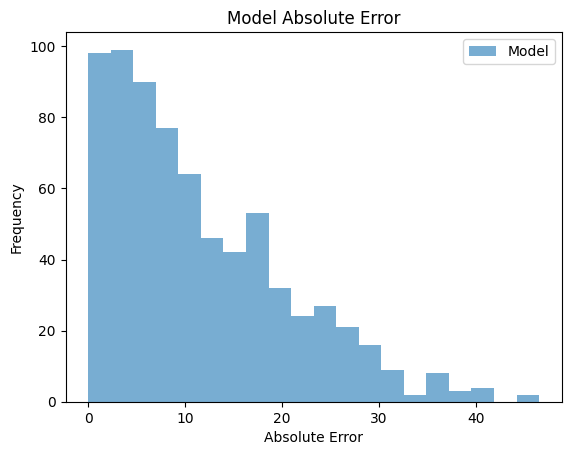

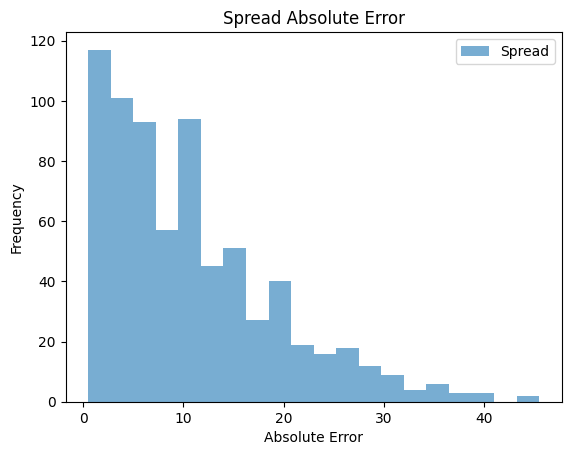




Substantial Differences: 
641



Most Important Value - True Bets - Model beat spread in 43.37% of the time





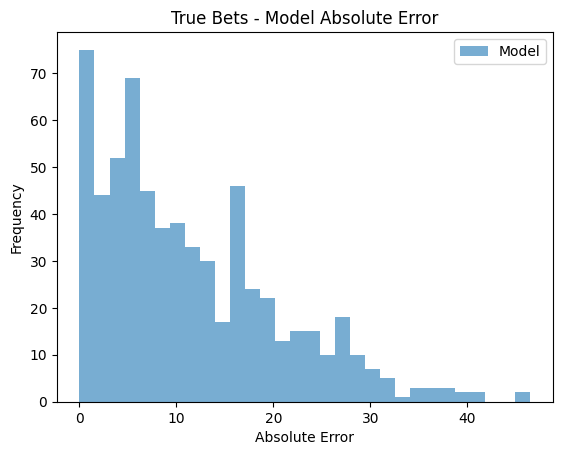

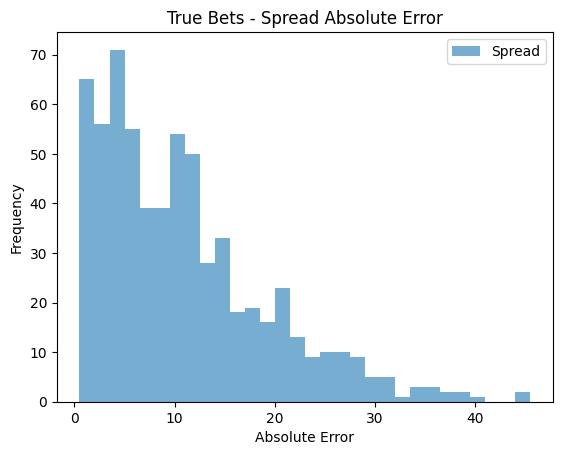




TRAIN MAE:
10.550100097815454



TRAIN R²:
0.11320045537614365



TEST MAE:
11.166246414602348



TEST R²:
0.0521982309763529








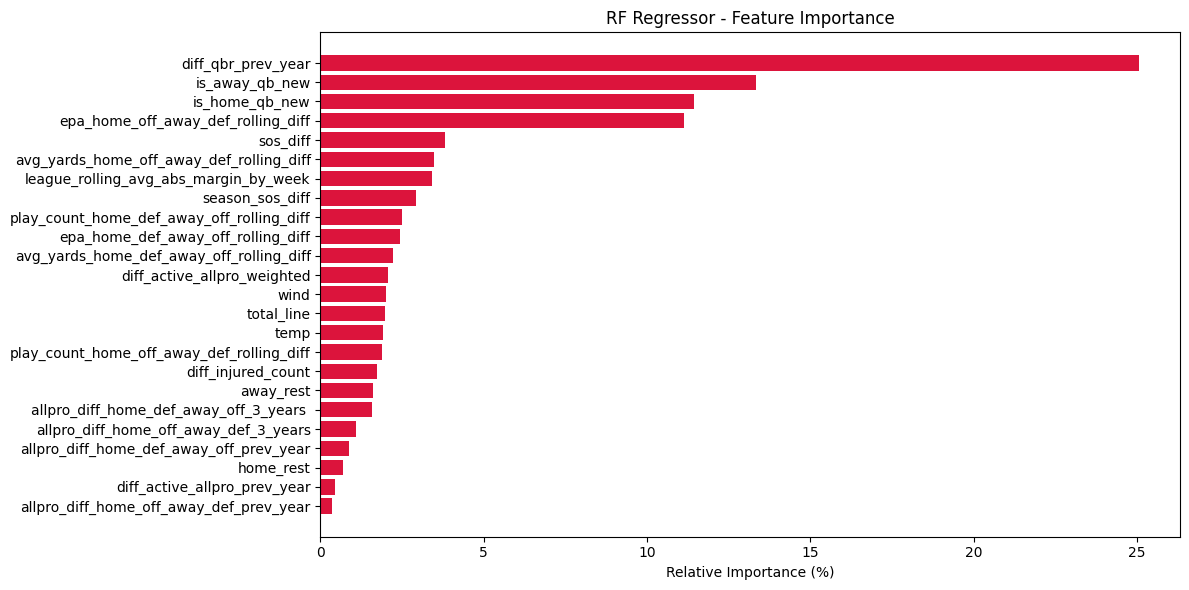

In [130]:
#after RF regressor, updating features to combine epa, avg yards, and play count (home off vs away def and home def vs away off)
#NEEDED TO CREATE NEW FUNCTION THAT DOES NOT HAVE ENCODING CODE SINCE I ALREADY HAVE THOSE FEATURES IN MY DF FROM LAST ITERATIONe
third_model, eval_df = random_forest_regressor_v2(updated_df)

In [131]:
eval_df

game_id  game_margin  model_prediction  spread  \
1770  2016_11_PHI_SEA         11.0               7.5     6.5   
915   2012_17_BAL_CIN          6.0               2.5     5.5   
1510  2015_10_BUF_NYJ         -5.0               4.5     2.5   
3809   2024_18_CHI_GB         -2.0               5.0    10.0   
3826   2024_19_MIN_LA         18.0               6.0    -2.5   
...               ...          ...               ...     ...   
1727   2016_08_SEA_NO          5.0               2.0    -1.0   
373    2010_12_KC_SEA        -18.0               1.0    -1.0   
356   2010_11_WAS_TEN         -3.0               3.5     7.0   
2632  2020_06_CIN_IND          4.0               4.5     7.5   
2664  2020_08_IND_DET        -20.0               3.5    -3.5   

      model_vs_spread_diff  model_error  spread_error  model_vs_spread  
1770                   1.0          3.5           4.5             True  
915                    3.0          3.5           0.5            False  
1510                   2.0          9.5           7.5            False  
3809                   5.0          7.0          12.0             True  
3826                   8.5         12.0          20.5             True  
...                    ...          ...           ...              ...  
1727                   3.0          3.0           6.0             True  
373                    2.0         19.0          17.0            False  
356                    3.5          6.5          10.0             True  
2632                   3.0          0.5           3.5             True  
2664                   7.0         23.5          16.5            False  

[641 rows x 8 columns]

When we filter for only features that were above 1 feature importance for our model in the previous feature set we got 22 features that were used here.

The MAE for our model is 11.17 which means, on average, our model predicted a game margin off by approximately 11.17 points from the real value.

An R-squared score of 5% means our model explains 5% of the variance in game margin. This is a significant decrease from the previous model.

Our winning percentage actually goes up in terms of betting compared to our previous iteration. This is most likely due to the hyperparameter tuning. The increase is marginal.

Our feature reduction and hyperparamter tuning is in good shape.

it seems our feature set may be the limiting factor. I have tested extensively with various hyperparameter and feature combinations. We have greatly improved the overfitting issue at least. The model is still struggling to improve at all though.

The feature importance is interesting though, diving deeper into a away qb vs home qb comparison may be a good idea.



###4th Iteration

In [132]:
def random_forest_regressor_v3(features_df):

    #features
    game_ids = features_df['game_id'].reset_index(drop=True)
    spread = features_df['spread_line'].reset_index(drop=True)
    X = features_df.drop(columns=['game_margin', 'game_id', 'spread_line'])
    #target variable
    y = features_df['game_margin'].reset_index(drop=True)

    #converts each category to binary value
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    quan_features = [col for col in X.columns if col not in cat_features]

    #checks categorical columns are all strings
    X[cat_features] = X[cat_features].astype(str)

    print("Number of Features:")
    print(len(quan_features) + len(cat_features))
    print('\n\n')
    print("Name of Features - Categorical and Quantative Respectively:")
    print(cat_features)
    print('\n\n')
    print(quan_features)
    print('\n\n')

    #encode categorical features
    cat_feature_encoding = ColumnTransformer([("cat_features", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)], remainder='passthrough')

    X_encoded = cat_feature_encoding.fit_transform(X)
    new_cat_feat_names = cat_feature_encoding.named_transformers_['cat_features'].get_feature_names_out(cat_features)
    updated_feats = list(new_cat_feat_names) + list(quan_features)
    X_updated = pd.DataFrame(X_encoded, columns=updated_feats)
    X_updated = X_updated.astype(float)

    print("Features After Encoding:")
    print(X_updated.columns)
    print('\n\n')

    X_train, X_test, y_train, y_test, game_ids_train, game_ids_test, spread_train, spread_test = train_test_split(X_updated, y, game_ids, spread, test_size=0.3, random_state=3)
    #X_train, X_test, y_train, y_test = train_test_split(X_updated, y, test_size=0.2, random_state=3)
    rf_reg = RandomForestRegressor(random_state=3)

    #grid search
    grid = {
        'n_estimators': [500],
        'max_depth': [15],
        'min_samples_split': [10],
        'min_samples_leaf': [5],
        'max_features': [20],
        'criterion': ['absolute_error']
    }

    gs = GridSearchCV(estimator=rf_reg, param_grid=grid, cv=2, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
    gs.fit(X_train, y_train)

    grid_model = gs.best_estimator_
    print("\nBest hyperparameters:")
    print(gs.best_params_)

    print(f"\n\nBest CV MAE: {-gs.best_score_:.4f}")
    print('\n\n')

    #rf_reg = RandomForestRegressor(n_estimators=100, random_state=3, max_depth=model_depth)
    #rf_reg.fit(X_train, y_train)

    test_pred = grid_model.predict(X_test)
    train_pred = grid_model.predict(X_train)
    test_pred_rounded = np.round(test_pred * 2) / 2

    #spread = X_test['spread_line']

    #evaluate model
    eval_df = pd.DataFrame({
        'game_id': game_ids_test,
        'game_margin': y_test,
        'model_prediction': test_pred_rounded,
        'spread': spread_test
    })


    #remove pushes
    eval_df = eval_df[eval_df['game_margin'] != eval_df['spread']].copy()
    eval_df = eval_df[eval_df['model_prediction'] != eval_df['spread']].copy()

    #diff
    eval_df['model_vs_spread_diff'] = np.abs(eval_df['model_prediction'] - eval_df['spread'])
    true_bets_df = eval_df[eval_df['model_vs_spread_diff'] >= 1].copy()

    eval_df['model_error'] = np.abs(eval_df['game_margin'] - eval_df['model_prediction'])
    eval_df['spread_error'] = np.abs(eval_df['game_margin'] - eval_df['spread'])

    eval_df['model_vs_spread'] = eval_df['model_error'] < eval_df['spread_error']

    winning_percentage = eval_df['model_vs_spread'].mean()

    print(f"Model beat spread in {winning_percentage*100:.2f}% of the time")
    print('\n\n')

    plt.hist(eval_df['model_error'], bins=20, alpha=0.6, label='Model')
    plt.legend()
    plt.title('Model Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()
    print('\n\n')

    plt.hist(eval_df['spread_error'], bins=20, alpha=0.6, label='Spread')
    plt.legend()
    plt.title('Spread Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()
    print('\n\n')

    #true betting edge percentage
    print("Substantial Differences: ")
    print(len(true_bets_df))
    print('\n\n')
    true_bets_df['model_error'] = np.abs(true_bets_df['game_margin'] - true_bets_df['model_prediction'])
    true_bets_df['spread_error'] = np.abs(true_bets_df['game_margin'] - true_bets_df['spread'])

    true_bets_df['model_vs_spread'] = true_bets_df['model_error'] < true_bets_df['spread_error']

    winning_percentage = true_bets_df['model_vs_spread'].mean()

    print(f"Most Important Value - True Bets - Model beat spread in {winning_percentage*100:.2f}% of the time")
    print('\n\n')

    plt.hist(true_bets_df['model_error'], bins=30, alpha=0.6, label='Model')
    plt.legend()
    plt.title('True Bets - Model Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()
    print('\n\n')

    plt.hist(true_bets_df['spread_error'], bins=30, alpha=0.6, label='Spread')
    plt.legend()
    plt.title('True Bets - Spread Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()

    print('\n\n')
    print("TRAIN MAE:")
    print(mean_absolute_error(y_train, train_pred))
    print('\n\n')

    print("TRAIN R²:")
    print(r2_score(y_train, train_pred))
    print('\n\n')

    print("TEST MAE:")
    print(mean_absolute_error(y_test, test_pred))
    print('\n\n')

    print("TEST R²:")
    print(r2_score(y_test, test_pred))
    print('\n\n')

    #Calculating the feature importance
    feature_importance = grid_model.feature_importances_
    feature_importance = 100.0*(feature_importance/np.sum(feature_importance))

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]
    features = np.array(X_updated.columns)[sorted_idx]
    imp = feature_importance[sorted_idx]

    print('\n\n')

    # Plot all feature importances
    plt.figure(figsize=(12, max(6, 0.25 * len(features))))  # dynamic height
    plt.barh(np.arange(len(features)), imp[::-1], color='crimson', align='center')
    plt.yticks(np.arange(len(features)), features[::-1])
    plt.xlabel('Relative Importance (%)')
    plt.title('RF Regressor - Feature Importance')
    plt.tight_layout()
    plt.show()

    return grid_model, true_bets_df

Number of Features:
65



Name of Features - Categorical and Quantative Respectively:
['roof', 'surface']



['away_rest', 'home_rest', 'total_line', 'div_game', 'temp', 'wind', 'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'home_rolling_avg_epa', 'home_rolling_avg_yards', 'home_rolling_play_count', 'away_rolling_avg_epa', 'away_rolling_avg_yards', 'away_rolling_play_count', 'home_rolling_allowed_avg_epa', 'home_rolling_allowed_avg_yards', 'home_rolling_allowed_play_count', 'away_rolling_allowed_avg_epa', 'away_rolling_allowed_avg_yards', 'away_rolling_allowed_play_count', 'epa_home_off_away_def_rolling_diff', 'epa_home_def_away_off_rolling_diff', 'avg_yards_home_off_away_def_rolling_diff', 'avg_yards_home_def_away_off_rolling_diff', 'play_count_home_off_away_def_rolling_diff', 'play_count_home_def_away_off_rolling_diff', 'home_recent_sos_opponent_avg', 'home_season_sos_opponent_avg', 'away_recent_sos_opponent_avg', 'away_season_sos_opponent_avg', 'sos_diff', 'seas

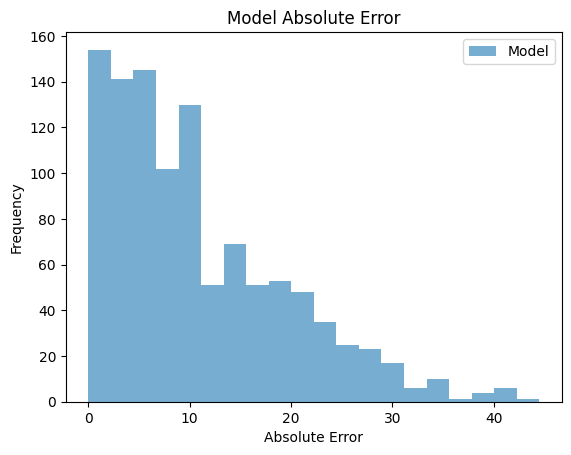

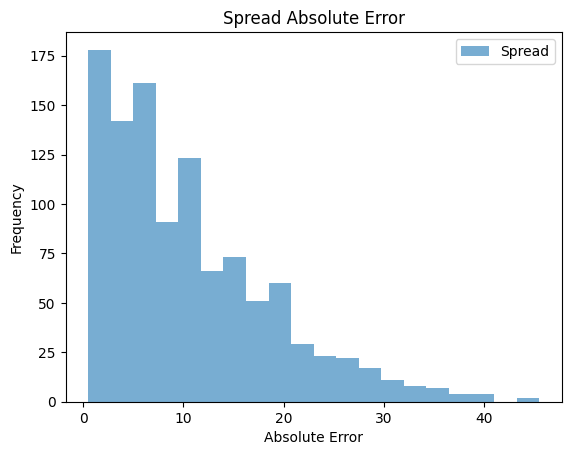




Substantial Differences: 
958



Most Important Value - True Bets - Model beat spread in 45.62% of the time





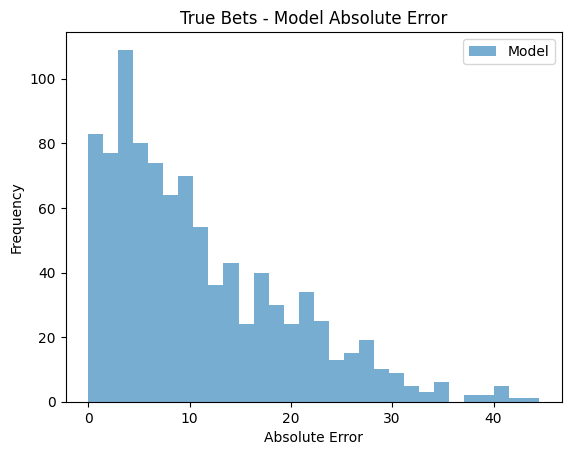

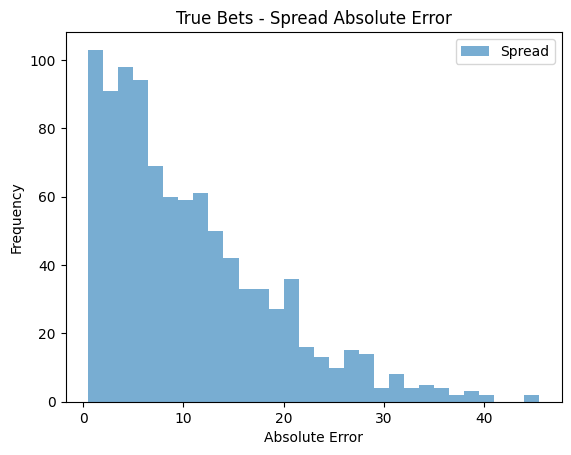




TRAIN MAE:
7.6992430115542305



TRAIN R²:
0.4963245604881408



TEST MAE:
10.697045178105995



TEST R²:
0.10583841645290815








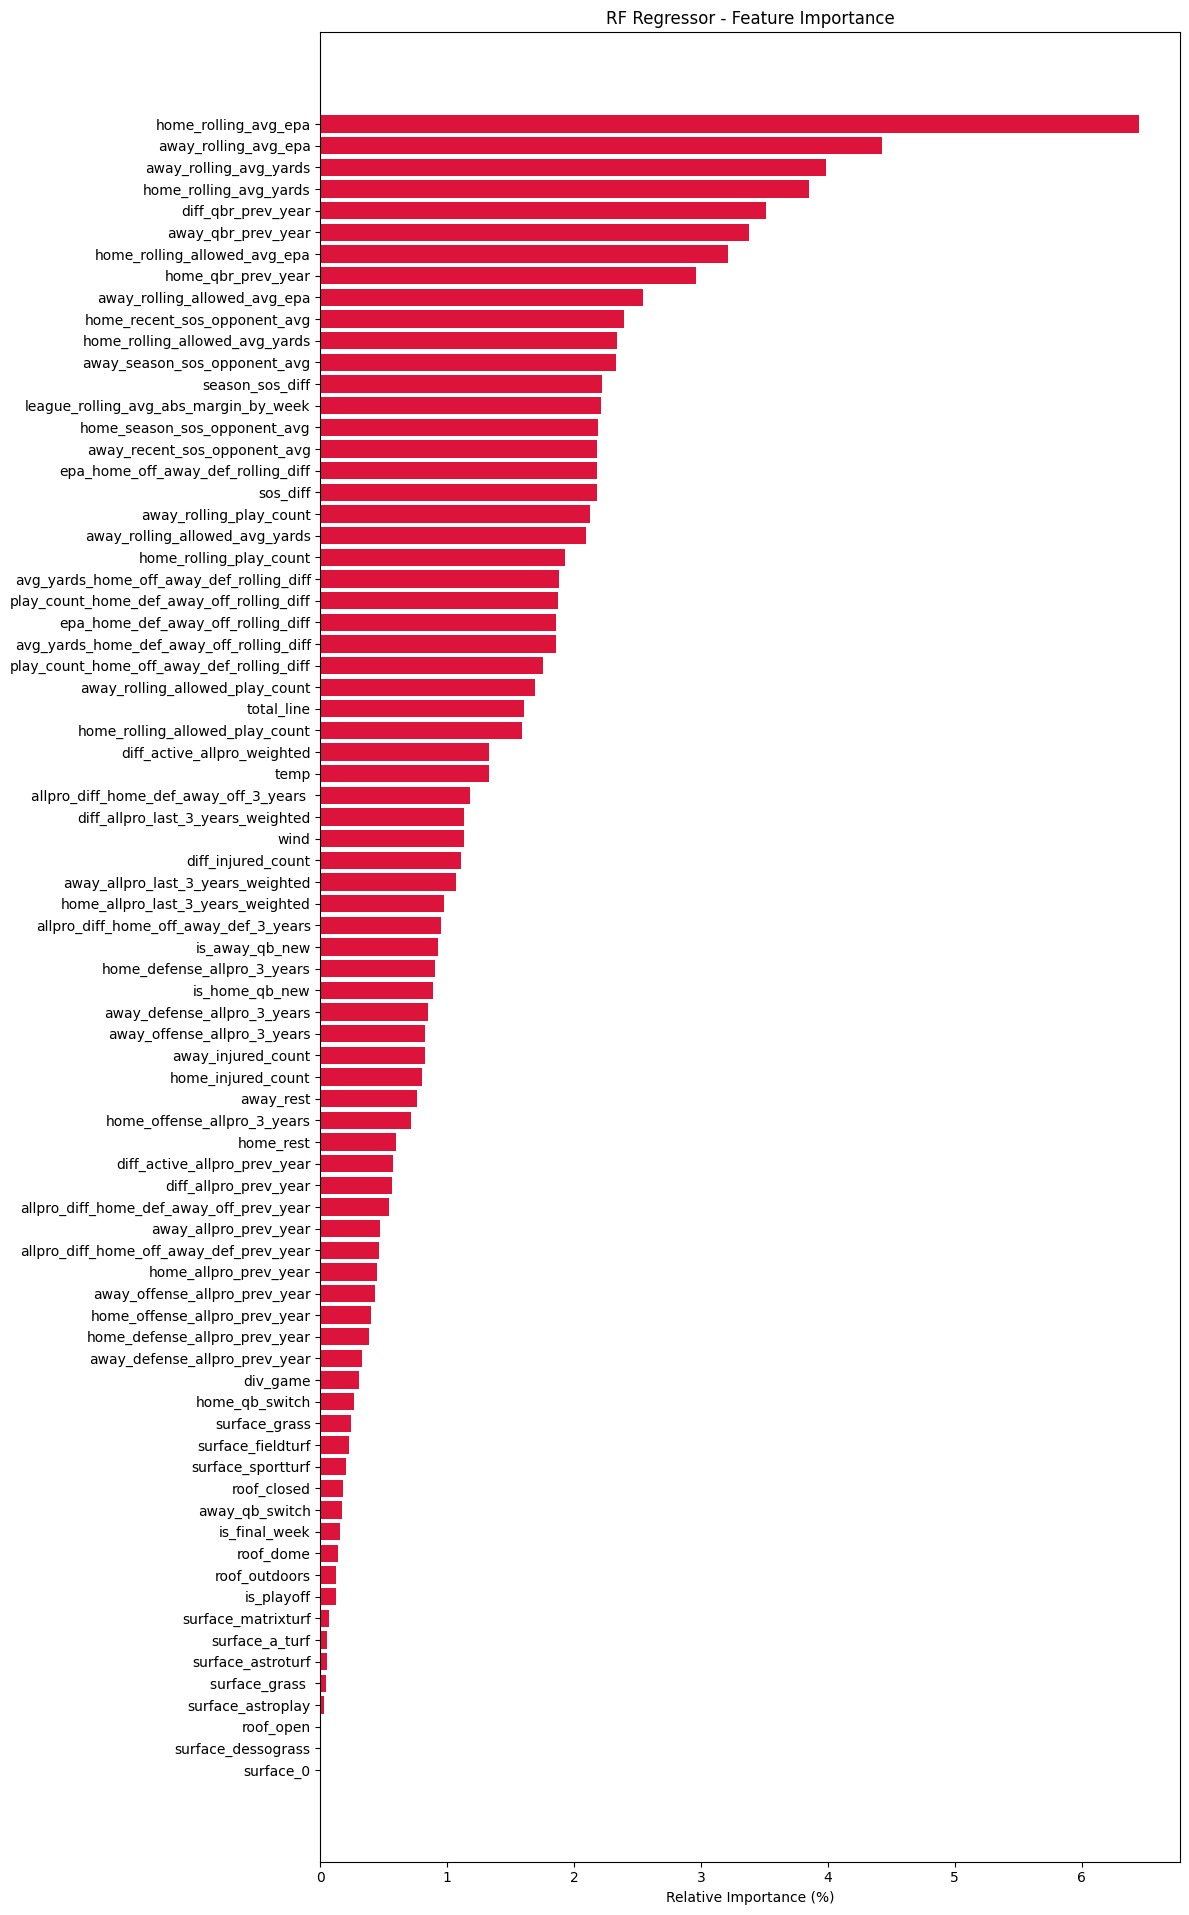

(RandomForestRegressor(criterion='absolute_error', max_depth=15, max_features=20,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=500, random_state=3),
               game_id  game_margin  model_prediction  spread  \
 1770  2016_11_PHI_SEA         11.0               7.5     6.5   
 915   2012_17_BAL_CIN          6.0               3.5     5.5   
 1510  2015_10_BUF_NYJ         -5.0               5.5     2.5   
 3809   2024_18_CHI_GB         -2.0              11.5    10.0   
 3826   2024_19_MIN_LA         18.0               2.0    -2.5   
 ...               ...          ...               ...     ...   
 3640  2024_06_BUF_NYJ         -3.0              -0.0    -1.0   
 2393  2019_05_DEN_LAC         -7.0               6.0     4.0   
 2337  2018_17_ARI_SEA          3.0              10.5    15.5   
 1885  2017_03_CLE_IND          3.0               3.5     1.0   
 181   2009_15_ATL_NYJ         -3.0               1.0     5.5   
 
       model_

In [133]:
#going to look at the first iteration but with hyperparameter tuning
random_forest_regressor_v3(features_df)

In [134]:
true_bets_df

game_id  game_margin  model_prediction  spread  \
1480  2015_07_DAL_NYG          7.0               2.0     3.0   
1770  2016_11_PHI_SEA         11.0               7.5     6.5   
915   2012_17_BAL_CIN          6.0               1.5     5.5   
1510  2015_10_BUF_NYJ         -5.0               5.0     2.5   
3809   2024_18_CHI_GB         -2.0               5.5    10.0   
...               ...          ...               ...     ...   
1727   2016_08_SEA_NO          5.0               2.5    -1.0   
356   2010_11_WAS_TEN         -3.0               5.0     7.0   
2632  2020_06_CIN_IND          4.0               6.5     7.5   
2664  2020_08_IND_DET        -20.0               5.0    -3.5   
710   2012_03_NYJ_MIA         -3.0              -0.5    -2.5   

      model_vs_spread_diff  model_error  spread_error  model_vs_spread  
1480                   1.0          5.0           4.0            False  
1770                   1.0          3.5           4.5             True  
915                    4.0          4.5           0.5            False  
1510                   2.5         10.0           7.5            False  
3809                   4.5          7.5          12.0             True  
...                    ...          ...           ...              ...  
1727                   3.5          2.5           6.0             True  
356                    2.0          8.0          10.0             True  
2632                   1.0          2.5           3.5             True  
2664                   8.5         25.0          16.5            False  
710                    2.0          2.5           0.5            False  

[652 rows x 8 columns]

###5th Iteration

same as 4th iteration but with spread line feature included.

In [135]:
def random_forest_regressor_v3_with_spread(features_df):

    #features
    game_ids = features_df['game_id'].reset_index(drop=True)
    spread = features_df['spread_line'].reset_index(drop=True)
    X = features_df.drop(columns=['game_margin', 'game_id'])
    #target variable
    y = features_df['game_margin'].reset_index(drop=True)

    #converts each category to binary value
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    quan_features = [col for col in X.columns if col not in cat_features]

    #checks categorical columns are all strings
    X[cat_features] = X[cat_features].astype(str)

    print("Number of Features:")
    print(len(quan_features) + len(cat_features))
    print('\n\n')
    print("Name of Features - Categorical and Quantative Respectively:")
    print(cat_features)
    print('\n\n')
    print(quan_features)
    print('\n\n')

    #encode categorical features
    cat_feature_encoding = ColumnTransformer([("cat_features", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)], remainder='passthrough')

    X_encoded = cat_feature_encoding.fit_transform(X)
    new_cat_feat_names = cat_feature_encoding.named_transformers_['cat_features'].get_feature_names_out(cat_features)
    updated_feats = list(new_cat_feat_names) + list(quan_features)
    X_updated = pd.DataFrame(X_encoded, columns=updated_feats)
    X_updated = X_updated.astype(float)

    print("Features After Encoding:")
    print(X_updated.columns)
    print('\n\n')

    X_train, X_test, y_train, y_test, game_ids_train, game_ids_test, spread_train, spread_test = train_test_split(X_updated, y, game_ids, spread, test_size=0.3, random_state=3)
    #X_train, X_test, y_train, y_test = train_test_split(X_updated, y, test_size=0.2, random_state=3)
    rf_reg = RandomForestRegressor(random_state=3)

    #grid search
    grid = {
        'n_estimators': [500],
        'max_depth': [15],
        'min_samples_split': [10],
        'min_samples_leaf': [5],
        'max_features': [20],
        'criterion': ['absolute_error']
    }

    gs = GridSearchCV(estimator=rf_reg, param_grid=grid, cv=2, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
    gs.fit(X_train, y_train)

    grid_model = gs.best_estimator_
    print("\nBest hyperparameters:")
    print(gs.best_params_)

    print(f"\n\nBest CV MAE: {-gs.best_score_:.4f}")
    print('\n\n')

    #rf_reg = RandomForestRegressor(n_estimators=100, random_state=3, max_depth=model_depth)
    #rf_reg.fit(X_train, y_train)

    test_pred = grid_model.predict(X_test)
    train_pred = grid_model.predict(X_train)
    test_pred_rounded = np.round(test_pred * 2) / 2

    #spread = X_test['spread_line']

    #evaluate model
    eval_df = pd.DataFrame({
        'game_id': game_ids_test,
        'game_margin': y_test,
        'model_prediction': test_pred_rounded,
        'spread': spread_test
    })


    #remove pushes
    eval_df = eval_df[eval_df['game_margin'] != eval_df['spread']].copy()
    eval_df = eval_df[eval_df['model_prediction'] != eval_df['spread']].copy()

    #diff
    eval_df['model_vs_spread_diff'] = np.abs(eval_df['model_prediction'] - eval_df['spread'])
    true_bets_df = eval_df[eval_df['model_vs_spread_diff'] >= 1].copy()

    eval_df['model_error'] = np.abs(eval_df['game_margin'] - eval_df['model_prediction'])
    eval_df['spread_error'] = np.abs(eval_df['game_margin'] - eval_df['spread'])

    eval_df['model_vs_spread'] = eval_df['model_error'] < eval_df['spread_error']

    winning_percentage = eval_df['model_vs_spread'].mean()

    print(f"Model beat spread in {winning_percentage*100:.2f}% of the time")
    print('\n\n')

    plt.hist(eval_df['model_error'], bins=20, alpha=0.6, label='Model')
    plt.legend()
    plt.title('Model Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()
    print('\n\n')

    plt.hist(eval_df['spread_error'], bins=20, alpha=0.6, label='Spread')
    plt.legend()
    plt.title('Spread Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()
    print('\n\n')

    #true betting edge percentage
    print("Substantial Differences: ")
    print(len(true_bets_df))
    print('\n\n')
    true_bets_df['model_error'] = np.abs(true_bets_df['game_margin'] - true_bets_df['model_prediction'])
    true_bets_df['spread_error'] = np.abs(true_bets_df['game_margin'] - true_bets_df['spread'])

    true_bets_df['model_vs_spread'] = true_bets_df['model_error'] < true_bets_df['spread_error']

    winning_percentage = true_bets_df['model_vs_spread'].mean()

    print(f"Most Important Value - True Bets - Model beat spread in {winning_percentage*100:.2f}% of the time")
    print('\n\n')

    plt.hist(true_bets_df['model_error'], bins=30, alpha=0.6, label='Model')
    plt.legend()
    plt.title('True Bets - Model Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()
    print('\n\n')

    plt.hist(true_bets_df['spread_error'], bins=30, alpha=0.6, label='Spread')
    plt.legend()
    plt.title('True Bets - Spread Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()

    print('\n\n')
    print("TRAIN MAE:")
    print(mean_absolute_error(y_train, train_pred))
    print('\n\n')

    print("TRAIN R²:")
    print(r2_score(y_train, train_pred))
    print('\n\n')

    print("TEST MAE:")
    print(mean_absolute_error(y_test, test_pred))
    print('\n\n')

    print("TEST R²:")
    print(r2_score(y_test, test_pred))
    print('\n\n')

    #Calculating the feature importance
    feature_importance = grid_model.feature_importances_
    feature_importance = 100.0*(feature_importance/np.sum(feature_importance))

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]
    features = np.array(X_updated.columns)[sorted_idx]
    imp = feature_importance[sorted_idx]

    print('\n\n')

    # Plot all feature importances
    plt.figure(figsize=(12, max(6, 0.25 * len(features))))  # dynamic height
    plt.barh(np.arange(len(features)), imp[::-1], color='crimson', align='center')
    plt.yticks(np.arange(len(features)), features[::-1])
    plt.xlabel('Relative Importance (%)')
    plt.title('RF Regressor - Feature Importance')
    plt.tight_layout()
    plt.show()

    return grid_model, true_bets_df

Number of Features:
66



Name of Features - Categorical and Quantative Respectively:
['roof', 'surface']



['spread_line', 'away_rest', 'home_rest', 'total_line', 'div_game', 'temp', 'wind', 'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'home_rolling_avg_epa', 'home_rolling_avg_yards', 'home_rolling_play_count', 'away_rolling_avg_epa', 'away_rolling_avg_yards', 'away_rolling_play_count', 'home_rolling_allowed_avg_epa', 'home_rolling_allowed_avg_yards', 'home_rolling_allowed_play_count', 'away_rolling_allowed_avg_epa', 'away_rolling_allowed_avg_yards', 'away_rolling_allowed_play_count', 'epa_home_off_away_def_rolling_diff', 'epa_home_def_away_off_rolling_diff', 'avg_yards_home_off_away_def_rolling_diff', 'avg_yards_home_def_away_off_rolling_diff', 'play_count_home_off_away_def_rolling_diff', 'play_count_home_def_away_off_rolling_diff', 'home_recent_sos_opponent_avg', 'home_season_sos_opponent_avg', 'away_recent_sos_opponent_avg', 'away_season_sos_opponent_avg', 's

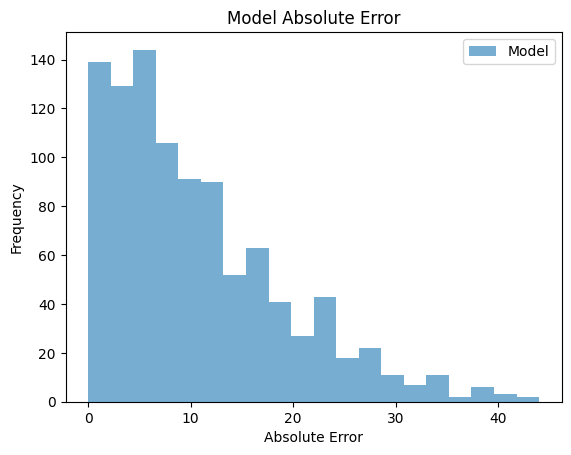

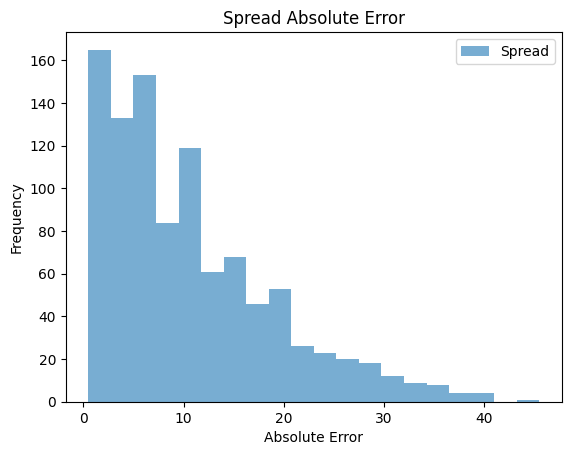




Substantial Differences: 
780



Most Important Value - True Bets - Model beat spread in 47.18% of the time





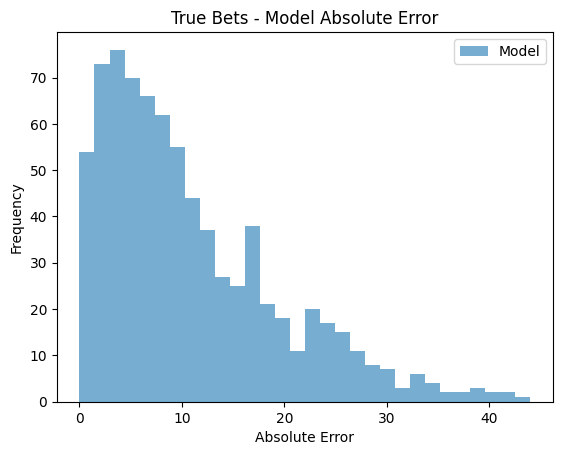

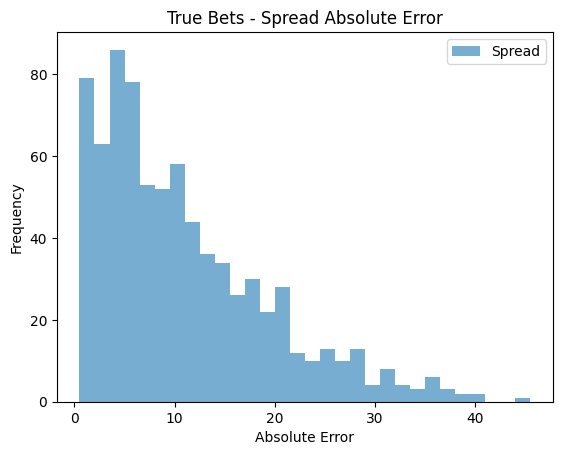




TRAIN MAE:
7.365437569884457



TRAIN R²:
0.5371690581826998



TEST MAE:
10.393781059947871



TEST R²:
0.15609474255581102








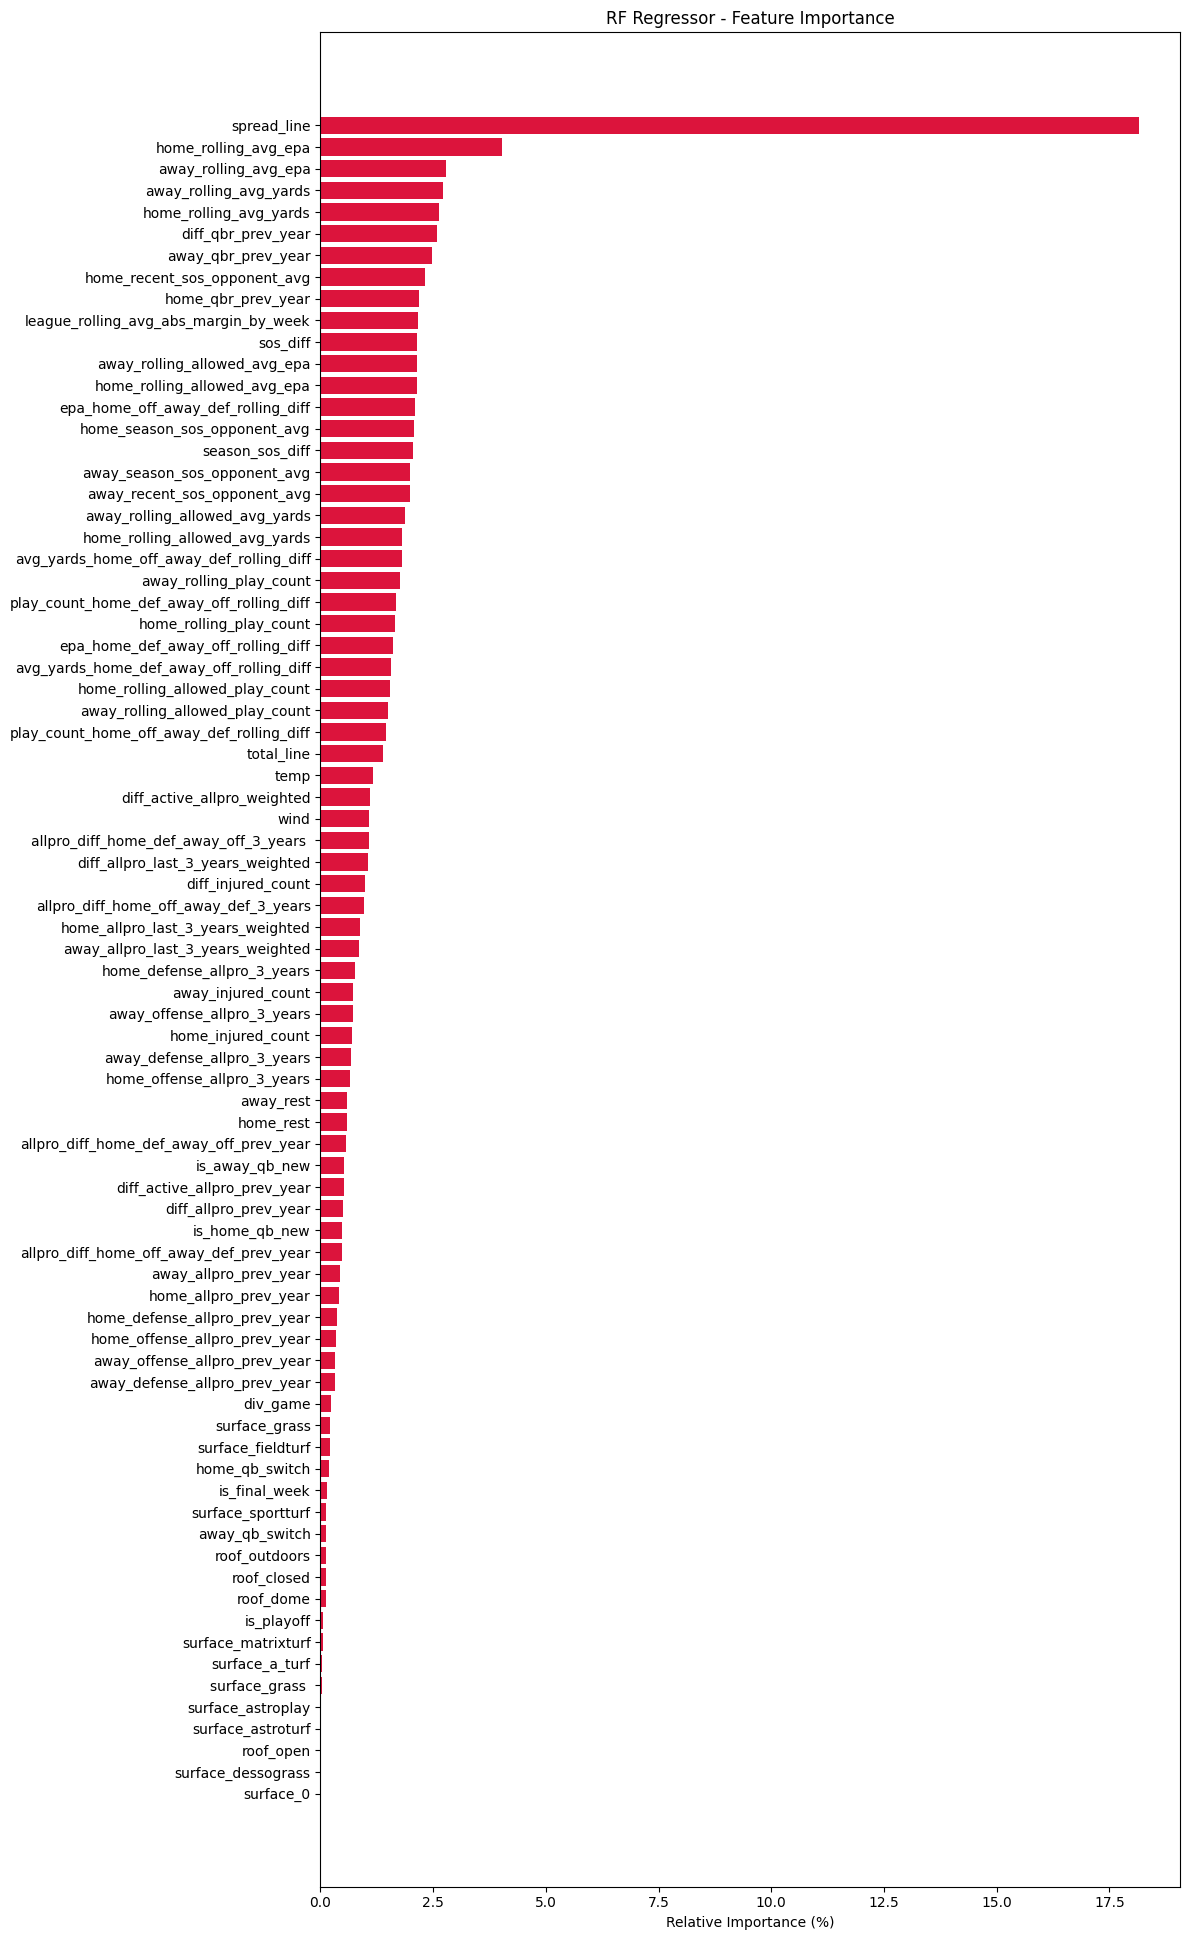

In [136]:
#same model as 4th iteration but with spread_line included as a feature
fith_model, fifth_eval = random_forest_regressor_v3_with_spread(features_df)

In [137]:
fifth_eval.head()

game_id  game_margin  model_prediction  spread  \
1480  2015_07_DAL_NYG          7.0               1.5     3.0   
915   2012_17_BAL_CIN          6.0               7.0     5.5   
1510  2015_10_BUF_NYJ         -5.0               0.5     2.5   
3809   2024_18_CHI_GB         -2.0              12.5    10.0   
3826   2024_19_MIN_LA         18.0              -1.5    -2.5   

      model_vs_spread_diff  model_error  spread_error  model_vs_spread  
1480                   1.5          5.5           4.0            False  
915                    1.5          1.0           0.5            False  
1510                   2.0          5.5           7.5             True  
3809                   2.5         14.5          12.0            False  
3826                   1.0         19.5          20.5             True

###XGBoost Model

In [ ]:
# Columns as list
columns_list = features_df.columns.tolist()
print(columns_list)


['game_id', 'game_margin', 'spread_line', 'away_rest', 'home_rest', 'total_line', 'div_game', 'roof', 'surface', 'temp', 'wind', 'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'home_rolling_avg_epa', 'home_rolling_avg_yards', 'home_rolling_play_count', 'away_rolling_avg_epa', 'away_rolling_avg_yards', 'away_rolling_play_count', 'home_rolling_allowed_avg_epa', 'home_rolling_allowed_avg_yards', 'home_rolling_allowed_play_count', 'away_rolling_allowed_avg_epa', 'away_rolling_allowed_avg_yards', 'away_rolling_allowed_play_count', 'epa_home_off_away_def_rolling_diff', 'epa_home_def_away_off_rolling_diff', 'avg_yards_home_off_away_def_rolling_diff', 'avg_yards_home_def_away_off_rolling_diff', 'play_count_home_off_away_def_rolling_diff', 'play_count_home_def_away_off_rolling_diff', 'home_recent_sos_opponent_avg', 'home_season_sos_opponent_avg', 'away_recent_sos_opponent_avg', 'away_season_sos_opponent_avg', 'sos_diff', 'season_sos_diff', 'home_allpro_last_3_years_weighted'

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

# Split features and target
X = features_df.drop(columns=['game_margin'])
y = features_df['game_margin']

# Define column types
categorical_cols = ['roof', 'surface']
boolean_cols = [
    'is_playoff', 'is_final_week',
    'home_qb_switch', 'away_qb_switch',
    'is_home_qb_new', 'is_away_qb_new'
]

# Ensure categorical columns are strings (if they exist)
for col in categorical_cols:
    if col in X.columns:
        X[col] = X[col].astype(str)

# Boolean columns to integers (if needed)
for col in boolean_cols:
    if col in X.columns:
        X[col] = X[col].astype(int)

# Numerical columns = everything else
numerical_cols = [col for col in X.columns if col not in categorical_cols + boolean_cols + ['game_id']]  # Exclude game_id

# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'  # For boolean columns that are already numerical
)

# Pipeline: Preprocessor + XGBRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# --- Define Features & Target ---
X = features_df.drop(columns=['game_margin'])
y = features_df['game_margin']

# --- Drop Non-Feature Columns ---
non_feature_cols = ['game_id', 'home_team', 'away_team', 'season', 'week']
X_filtered = X.drop(columns=non_feature_cols, errors='ignore')

# --- Define Feature Types ---
categorical_cols = [col for col in ['roof', 'surface'] if col in X_filtered.columns]
boolean_cols = [col for col in ['is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'is_home_qb_new', 'is_away_qb_new'] if col in X_filtered.columns]
numerical_cols = [col for col in X_filtered.columns if col not in categorical_cols + boolean_cols]

# --- Ensure categorical columns are strings ---
for col in categorical_cols:
    if col in X_filtered.columns:
        X_filtered[col] = X_filtered[col].astype(str)

# --- Preprocessing Pipeline ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)  # boolean treated as numeric passthrough
    ]
)

# --- XGBoost Regressor Pipeline ---
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        max_depth=10,
        learning_rate=0.03,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        verbosity=1
    ))
])

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

# --- Model Training ---
pipeline.fit(X_train, y_train)

# --- Predictions ---
y_pred = pipeline.predict(X_test)

# --- Evaluation ---
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Mean Absolute Error (MAE): 10.51
R-squared (R²): 0.17


###Grid Search (do not run again)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, r2_score
import numpy as np

# --- Use X_lean and y from your lean model setup ---

# Dynamically determine valid feature groups
categorical_cols = [col for col in ['roof', 'surface'] if col in X_lean.columns]
boolean_cols = [col for col in [
    'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch',
    'is_home_qb_new', 'is_away_qb_new'
] if col in X_lean.columns]
numerical_cols = [col for col in X_lean.columns if col not in categorical_cols + boolean_cols]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

# Base pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        verbosity=0
    ))
])

# --- Grid Search Params ---
param_grid = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__max_depth': [3, 4, 6],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__subsample': [0.6, 0.8],
    'regressor__colsample_bytree': [0.6, 0.8],
    'regressor__reg_alpha': [0, 1],
    'regressor__reg_lambda': [1, 3],
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,  # use 3 to reduce runtime, or 5 for thorough search
    scoring=make_scorer(r2_score),
    n_jobs=-1,
    verbose=2
)

# --- Fit grid search ---
grid_search.fit(X_lean, y)

# --- Best model and score ---
print(f"\n Best R²: {grid_search.best_score_:.3f}")
print("Best parameters:")
for param, val in grid_search.best_params_.items():
    print(f"{param}: {val}")


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits

 Best R²: 0.109
Best parameters:
regressor__colsample_bytree: 0.6
regressor__learning_rate: 0.01
regressor__max_depth: 3
regressor__min_child_weight: 3
regressor__n_estimators: 500
regressor__reg_alpha: 1
regressor__reg_lambda: 3
regressor__subsample: 0.6


In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(X_lean, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['roof', 'surface']),
                                                 ('num', 'passthrough',
                                                  ['away_rest', 'home_rest',
                                                   'total_line', 'div_game',
                                                   'temp', 'wind',
                                                   'home_rolling_avg_epa',
                                                   'home_rolling_avg_yards',
                                                   'home_rolling_play_count',
                                                   'away_rolling_avg_epa',
                                                   'away_roll...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=3,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=500,
                              n_jobs=None, num_parallel_tree=None, ...))])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Split data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X_lean, y, test_size=0.2, random_state=42)

# 2. Use best parameters from GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor

# Dynamically build column groups
categorical_cols = [col for col in ['roof', 'surface'] if col in X_lean.columns]
boolean_cols = [col for col in [
    'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch',
    'is_home_qb_new', 'is_away_qb_new'
] if col in X_lean.columns]
numerical_cols = [col for col in X_lean.columns if col not in categorical_cols + boolean_cols]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

# Final model with best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        min_child_weight=3,
        subsample=0.6,
        colsample_bytree=0.6,
        reg_alpha=1,
        reg_lambda=3,
        objective='reg:squarederror',
        random_state=42
    ))
])

# 3. Train on train set
pipeline.fit(X_train, y_train)

# 4. Predict and evaluate
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)

train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)

print(f"Final Model Performance:")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test MAE: {mae:.2f}")


Final Model Performance:
Train R²: 0.236
Test R²: 0.124
Test MAE: 10.73


###XGB Iteration 2

In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# --- Define Features & Target ---
X = features_df.drop(columns=['game_margin'])
y = features_df['game_margin']

# Drop non-feature columns if still present
non_feature_cols = ['game_id', 'home_team', 'away_team', 'season', 'week']
X_filtered = X.drop(columns=non_feature_cols, errors='ignore')

# Define Feature Types
categorical_cols = [col for col in ['roof', 'surface'] if col in X_filtered.columns]
boolean_cols = [col for col in ['is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'is_home_qb_new', 'is_away_qb_new'] if col in X_filtered.columns]
numerical_cols = [col for col in X_filtered.columns if col not in categorical_cols + boolean_cols]

# Ensure categorical columns are strings
for col in categorical_cols:
    if col in X_filtered.columns:
        X_filtered[col] = X_filtered[col].astype(str)

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

# Updated XGBoost with GridSearch Best Params
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        min_child_weight=3,
        subsample=0.6,
        colsample_bytree=0.6,
        reg_alpha=1,
        reg_lambda=3,
        objective='reg:squarederror',
        random_state=42,
        verbosity=1
    ))
])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

# Train Model
pipeline.fit(X_train, y_train)

# Predict & Evaluate
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Iteration 2 - MAE: {mae:.2f}")
print(f"Iteration 2 - R²: {r2:.2f}")


Iteration 2 - MAE: 10.24
Iteration 2 - R²: 0.19


Feature Importance

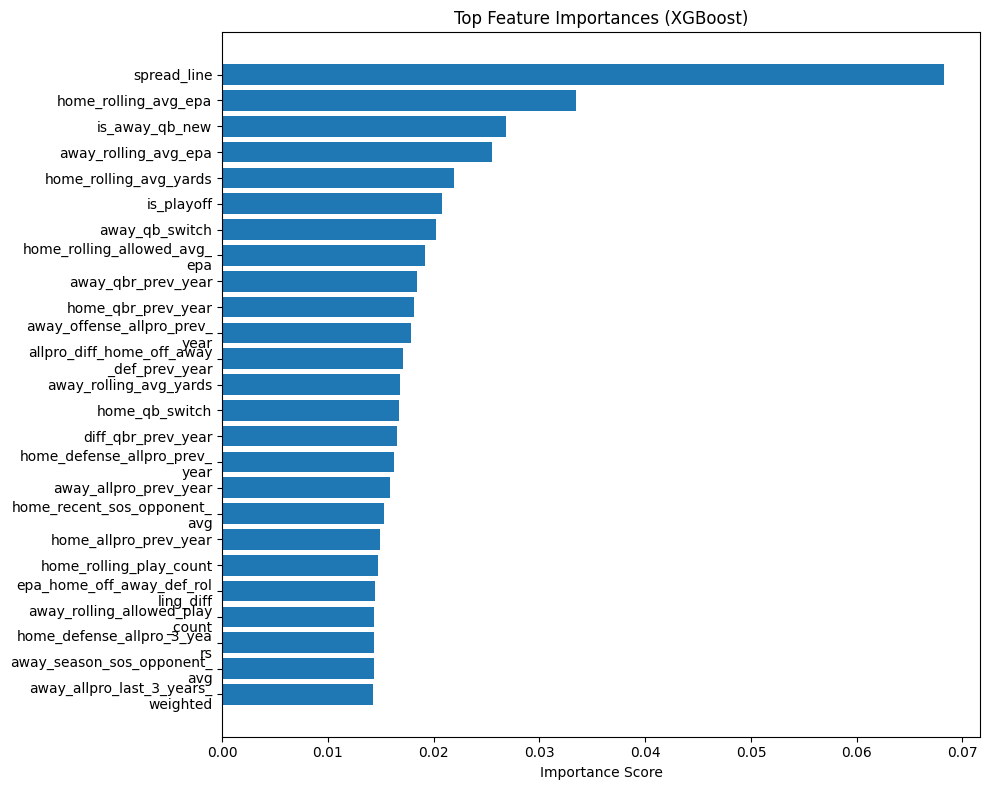

In [ ]:
# Extract trained model
fitted_model = pipeline.named_steps['regressor']

# Get feature importances
importances = fitted_model.feature_importances_

# Get transformed feature names after preprocessing
# This works because you have 'passthrough' for numerical columns and encoding for categoricals
preprocessed_feature_names = []

# Get feature names for categorical columns (OrdinalEncoder will encode in order)
for col in categorical_cols:
    preprocessed_feature_names.append(col)

# Add numerical and boolean columns (passthrough)
preprocessed_feature_names += numerical_cols + boolean_cols

# Check if lengths match
assert len(preprocessed_feature_names) == len(importances), "Feature names and importances length mismatch"

# Now you can plot
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# Sort feature importances
sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]
sorted_features = [preprocessed_feature_names[i] for i in sorted_idx]

# Limit to Top 25
top_features = sorted_features[:25]
top_importances = sorted_importances[:25]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(25), top_importances)
plt.yticks(range(25), [textwrap.fill(f, 25) for f in top_features])  # Wrap long names
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


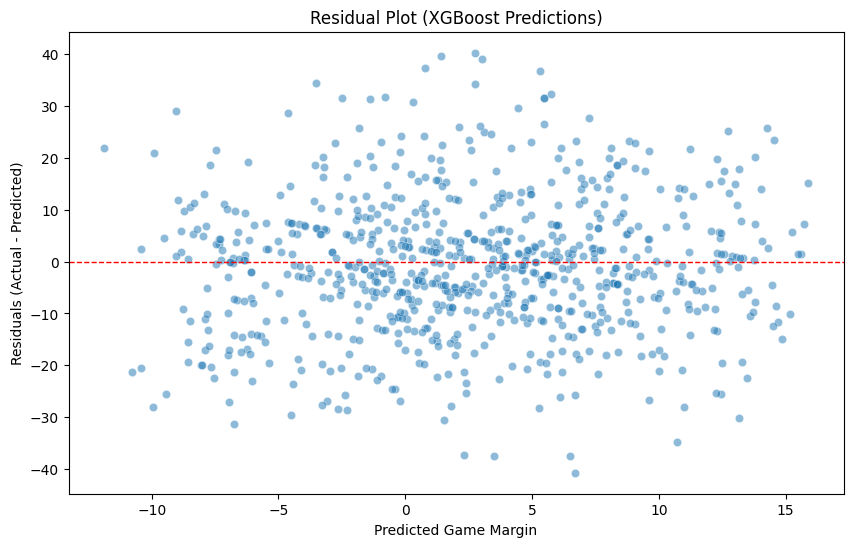

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Residuals = Actual - Predicted
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Game Margin')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot (XGBoost Predictions)')
plt.show()


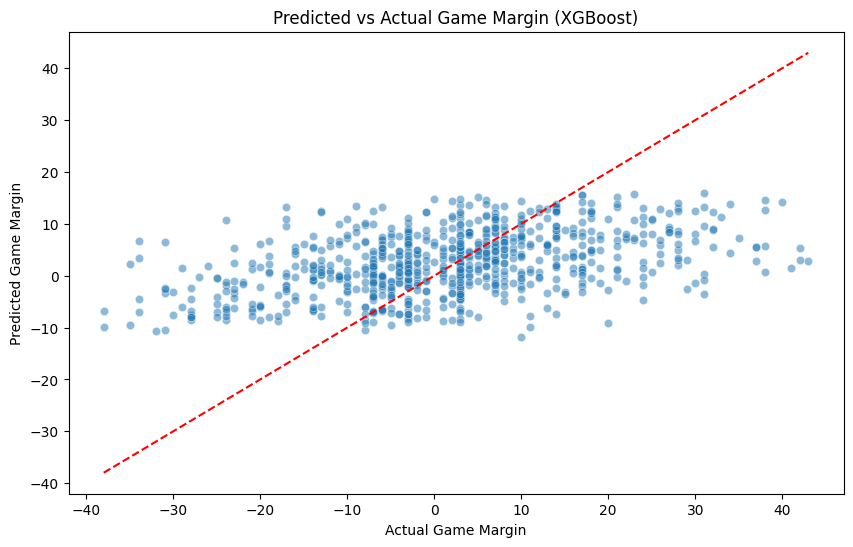

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Perfect prediction line
plt.xlabel('Actual Game Margin')
plt.ylabel('Predicted Game Margin')
plt.title('Predicted vs Actual Game Margin (XGBoost)')
plt.show()


###XGB Reduced Model

In [ ]:
# Reduced model
reduced_features_df = features_df[top_features + ['game_margin']]


In [ ]:
X_reduced = reduced_features_df.drop(columns=['game_margin'])
y_reduced = reduced_features_df['game_margin']


In [ ]:
# Redefine feature types from your top 25
categorical_cols_reduced = [col for col in ['roof', 'surface'] if col in X_reduced.columns]
boolean_cols_reduced = [col for col in ['is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'is_home_qb_new', 'is_away_qb_new'] if col in X_reduced.columns]
numerical_cols_reduced = [col for col in X_reduced.columns if col not in categorical_cols_reduced + boolean_cols_reduced]


In [ ]:
for col in categorical_cols_reduced:
    X_reduced[col] = X_reduced[col].astype(str)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

preprocessor_reduced = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols_reduced),
        ('num', 'passthrough', numerical_cols_reduced + boolean_cols_reduced)
    ]
)

pipeline_reduced = Pipeline(steps=[
    ('preprocessor', preprocessor_reduced),
    ('regressor', XGBRegressor(
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        min_child_weight=3,
        subsample=0.6,
        colsample_bytree=0.6,
        reg_alpha=1,
        reg_lambda=3,
        objective='reg:squarederror',
        random_state=42,
        verbosity=1
    ))
])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)

# Train the model
pipeline_reduced.fit(X_train_reduced, y_train_reduced)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  []),
                                                 ('num', 'passthrough',
                                                  ['spread_line',
                                                   'home_rolling_avg_epa',
                                                   'away_rolling_avg_epa',
                                                   'home_rolling_avg_yards',
                                                   'home_rolling_allowed_avg_epa',
                                                   'away_qbr_prev_year',
                                                   'home_qbr_prev_year',
                                                   'away_offense_allpro_prev_y...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=3,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=500,
                              n_jobs=None, num_parallel_tree=None, ...))])

In [ ]:
# Predict
y_pred_reduced = pipeline_reduced.predict(X_test_reduced)

# Evaluate
mae_reduced = mean_absolute_error(y_test_reduced, y_pred_reduced)
r2_reduced = r2_score(y_test_reduced, y_pred_reduced)

print(f"Reduced Feature Model - MAE: {mae_reduced:.2f}")
print(f"Reduced Feature Model - R²: {r2_reduced:.2f}")


Reduced Feature Model - MAE: 10.23
Reduced Feature Model - R²: 0.19


###Overfitting Check

In [ ]:
# Full Model Train Predictions
y_train_pred_full = pipeline.predict(X_train)

# Train Metrics
mae_train_full = mean_absolute_error(y_train, y_train_pred_full)
r2_train_full = r2_score(y_train, y_train_pred_full)

print("Full Feature Model (Iteration 2) — Overfitting Check")
print(f"Train MAE: {mae_train_full:.2f} | Test MAE: {mae:.2f}")
print(f"Train R²: {r2_train_full:.2f} | Test R²: {r2:.2f}")


Full Feature Model (Iteration 2) — Overfitting Check
Train MAE: 9.62 | Test MAE: 10.24
Train R²: 0.29 | Test R²: 0.19


In [ ]:
# Reduced Model Train Predictions
y_train_pred_reduced = pipeline_reduced.predict(X_train_reduced)

# Train Metrics
mae_train_reduced = mean_absolute_error(y_train_reduced, y_train_pred_reduced)
r2_train_reduced = r2_score(y_train_reduced, y_train_pred_reduced)

print("\nReduced Feature Model — Overfitting Check")
print(f"Train MAE: {mae_train_reduced:.2f} | Test MAE: {mae_reduced:.2f}")
print(f"Train R²: {r2_train_reduced:.2f} | Test R²: {r2_reduced:.2f}")



Reduced Feature Model — Overfitting Check
Train MAE: 9.74 | Test MAE: 10.23
Train R²: 0.27 | Test R²: 0.19


###Spread/Margin for trimmed model

In [ ]:
import pandas as pd

# Ensure match_df is already loaded with columns: 'season', 'week', 'home_team', 'away_team', 'spread_line', 'game_margin'

# Filter to 2009 and later
df_filtered = match_df[match_df['season'] >= 2009].copy()

# Compute absolute spread for relevant calculations
df_filtered['abs_spread'] = df_filtered['spread_line'].abs()

# Get the game with the largest spread line per season
largest_spreads_by_season = (
    df_filtered.loc[df_filtered.groupby('season')['abs_spread'].idxmax()]
    .sort_values('season')
)[['season', 'week', 'home_team', 'away_team', 'spread_line', 'game_margin']]

# Compute season-wise average (absolute), min, and max spread lines
season_spread_summary = df_filtered.groupby('season').agg(
    avg_abs_spread=('abs_spread', 'mean'),
    min_spread=('spread_line', 'min'),
    max_spread=('spread_line', 'max')
).reset_index()

# Merge largest spread game with season summary
season_combined = pd.merge(season_spread_summary, largest_spreads_by_season, on='season')

# Display the combined DataFrame
print("Season Spread Summary with Largest Spread Game (Average Absolute Spread):")
print(season_combined)


Season Spread Summary with Largest Spread Game (Average Absolute Spread):
    season  avg_abs_spread  min_spread  max_spread  week home_team away_team  \
0     2009        6.674468       -15.5        17.0    10       MIN       DET   
1     2010        5.063830       -13.0        14.5     4        GB       DET   
2     2011        5.691489       -13.5        20.5    13        NE       IND   
3     2012        5.078723       -14.0        17.0    17       DEN        KC   
4     2013        5.342553       -16.0        27.0     6       DEN       JAX   
5     2014        5.429787       -13.0        16.5    17       DEN       OAK   
6     2015        4.985106       -13.0        16.5     3       SEA       CHI   
7     2016        4.708511       -11.5        17.0    16        NE       NYJ   
8     2017        5.351695       -11.0        17.0    12        NE       MIA   
9     2018        5.491489       -14.5        17.0    14       LAC       CIN   
10    2019        5.753191       -15.5        

In [ ]:
import pandas as pd

# Ensure match_df is already loaded with: 'season', 'week', 'home_team', 'away_team', 'spread_line', 'game_margin'

# Filter to 2009 and later
df_filtered = match_df[match_df['season'] >= 2009].copy()

# Compute absolute spread
df_filtered['abs_spread'] = df_filtered['spread_line'].abs()

# Get the largest spread line game per season
largest_spreads_by_season = (
    df_filtered.loc[df_filtered.groupby('season')['abs_spread'].idxmax()]
    .sort_values('season')
)[['season', 'week', 'home_team', 'away_team', 'spread_line', 'game_margin']]

# Compute season-wise aggregate spreads
season_spread_summary = df_filtered.groupby('season').agg(
    avg_abs_spread=('abs_spread', 'mean'),
    avg_negative_spread=('spread_line', lambda x: x[x < 0].mean()),  # Home favorite
    avg_positive_spread=('spread_line', lambda x: x[x > 0].mean()),  # Away favorite
    min_spread=('spread_line', 'min'),
    max_spread=('spread_line', 'max')
).reset_index()

# Merge largest spread game with spread summary
season_combined = pd.merge(season_spread_summary, largest_spreads_by_season, on='season')

# Display the result
print("Season Spread Summary with Home/Away Spread Averages and Largest Spread Game:")
print(season_combined)


Season Spread Summary with Home/Away Spread Averages and Largest Spread Game:
    season  avg_abs_spread  avg_negative_spread  avg_positive_spread  \
0     2009        6.674468            -5.859756             7.111111   
1     2010        5.063830            -4.120000             5.506250   
2     2011        5.691489            -4.604938             6.262987   
3     2012        5.078723            -3.807229             5.773026   
4     2013        5.342553            -3.964286             6.150000   
5     2014        5.429787            -4.590909             5.838608   
6     2015        4.985106            -4.089744             5.429936   
7     2016        4.708511            -3.897260             5.105590   
8     2017        5.351695            -4.193548             6.235714   
9     2018        5.491489            -4.593750             5.954839   
10    2019        5.753191            -5.011364             6.197279   
11    2020        5.556962            -5.343434           

In [ ]:
import pandas as pd

# Ensure match_df is already loaded and filtered as needed
df_filtered = match_df[match_df['season'] >= 2009].copy()

# Define Spread Bins based on number of scores (8 points per score assumption)
bins = [-28, -16, -8,0, 8, 16, 28]
labels = ['3 Scores (Underdog)', '2 Scores (Underdog)', '1 Score (Underdog)',
          '1 Score (Favorite)', '2 Scores (Favorite)', '3 Scores (Favorite)']


# Bin the spread lines
df_filtered['score_bin'] = pd.cut(df_filtered['spread_line'], bins=bins, labels=labels, right=False)

# Count of games per spread bin
bin_counts = df_filtered['score_bin'].value_counts().reset_index()
bin_counts.columns = ['score_bin', 'count']

# Display result
print("Spread Bins Count (by Scores):")
print(bin_counts)


Spread Bins Count (by Scores):
             score_bin  count
0   1 Score (Favorite)   1850
1   1 Score (Underdog)   1231
2  2 Scores (Favorite)    560
3  2 Scores (Underdog)    148
4  3 Scores (Favorite)     42
5  3 Scores (Underdog)      3


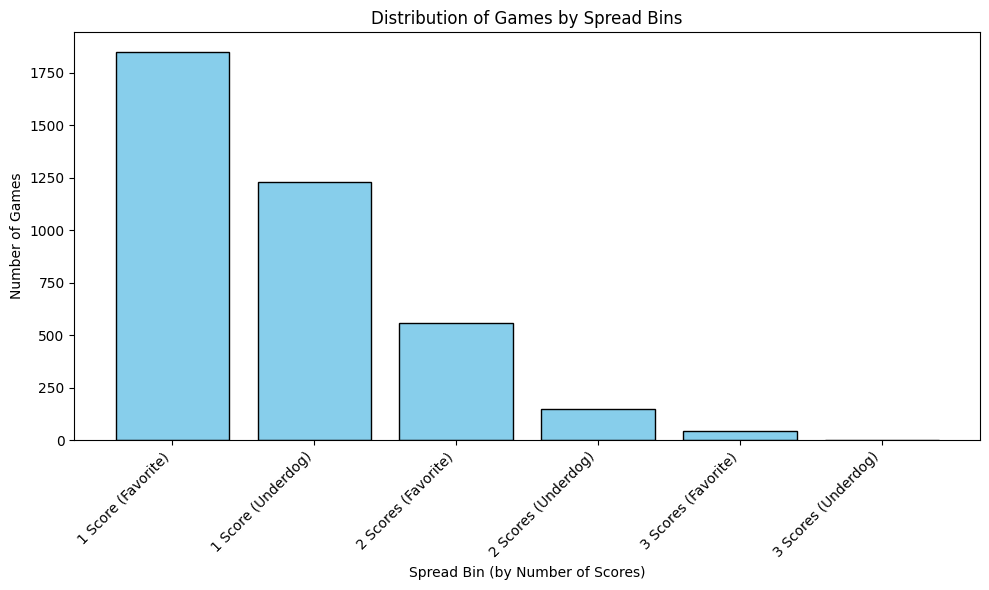

In [ ]:
import matplotlib.pyplot as plt

# Updated Spread Bins Data
score_bins = ['1 Score (Favorite)', '1 Score (Underdog)',
              '2 Scores (Favorite)', '2 Scores (Underdog)',
              '3 Scores (Favorite)', '3 Scores (Underdog)']

counts = [1850, 1231, 560, 148, 42, 3]

# Plot Histogram
plt.figure(figsize=(10,6))
plt.bar(score_bins, counts, color='skyblue', edgecolor='black')
plt.title('Distribution of Games by Spread Bins')
plt.xlabel('Spread Bin (by Number of Scores)')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Ensure match_df is already loaded and filtered as needed
df_filtered = match_df[match_df['season'] >= 2009].copy()

# Define Game Margin Bins based on number of scores (8 points per score assumption)
bins = [-100, -16, -8,0, 8, 16, 100]
labels = ['3+ Scores (Underdog)', '2 Scores (Underdog)', '1 Score (Underdog)',
          '1 Score (Favorite)', '2 Scores (Favorite)', '3+ Scores (Favorite)']

# Bin the actual game margins
df_filtered['margin_bin'] = pd.cut(df_filtered['game_margin'], bins=bins, labels=labels, right=False)

# Count of games per margin bin
margin_bin_counts = df_filtered['margin_bin'].value_counts().reset_index()
margin_bin_counts.columns = ['margin_bin', 'count']

# Display result
print("Game Margin Bins Count (by Scores):")
print(margin_bin_counts)


Game Margin Bins Count (by Scores):
             margin_bin  count
0    1 Score (Favorite)    931
1    1 Score (Underdog)    930
2  3+ Scores (Favorite)    683
3   2 Scores (Favorite)    532
4  3+ Scores (Underdog)    394
5   2 Scores (Underdog)    364


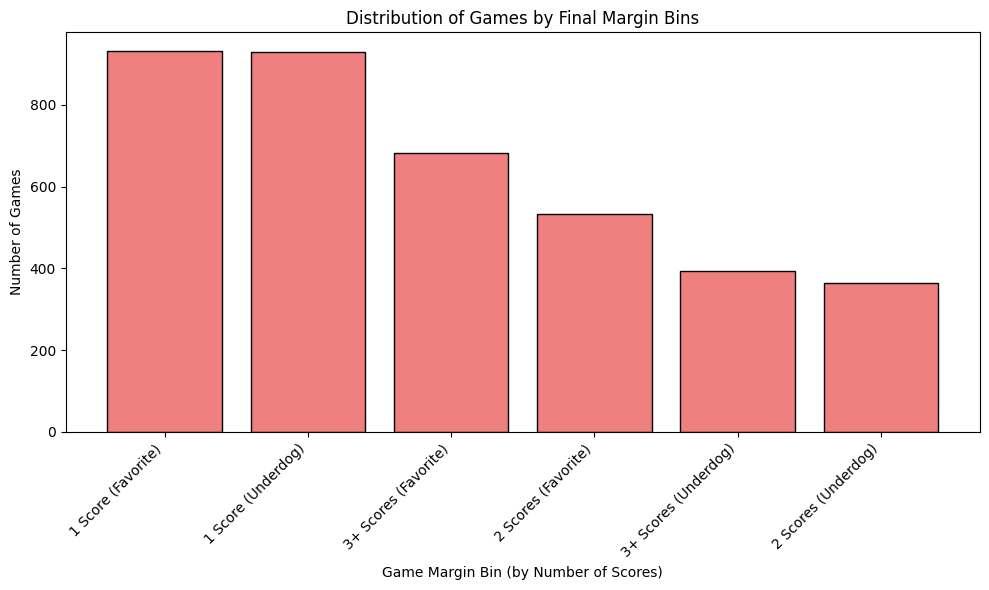

In [ ]:
import matplotlib.pyplot as plt

# Data from your counts
margin_bins = ['1 Score (Favorite)', '1 Score (Underdog)',
               '3+ Scores (Favorite)', '2 Scores (Favorite)',
               '3+ Scores (Underdog)', '2 Scores (Underdog)']

counts = [931, 930, 683, 532, 394, 364]

# Plot Histogram
plt.figure(figsize=(10,6))
plt.bar(margin_bins, counts, color='lightcoral', edgecolor='black')
plt.title('Distribution of Games by Final Margin Bins')
plt.xlabel('Game Margin Bin (by Number of Scores)')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


###XGB Blowout metric - My model is never predicting extreme blowouts

In [ ]:
# First, fit the preprocessor separately
preprocessor.fit(X_train)

# Transform X data
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_preprocessed, label=y_train)
dtest = xgb.DMatrix(X_test_preprocessed, label=y_test)


In [ ]:
def blowout_eval(preds, dtrain):
    labels = dtrain.get_label()
    UPPER_CAP = 27
    LOWER_CAP = -17

    # Binning predictions
    preds_binned = np.where(preds > UPPER_CAP, 'Blowout (Favorite)',
                    np.where(preds < LOWER_CAP, 'Blowout (Underdog)', 'Normal'))

    labels_binned = np.where(labels > UPPER_CAP, 'Blowout (Favorite)',
                     np.where(labels < LOWER_CAP, 'Blowout (Underdog)', 'Normal'))

    correct_preds = (preds_binned == labels_binned).sum()
    accuracy = correct_preds / len(labels)

    return 'blowout_accuracy', accuracy


In [ ]:
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    min_child_weight=3,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=1,
    reg_lambda=3,
    objective='reg:squarederror',
    random_state=42,
    verbosity=1
)

xgb_model.fit(X_train_preprocessed, y_train, eval_set=[(X_test_preprocessed, y_test)], verbose=True)


[0]	validation_0-rmse:14.74742
[1]	validation_0-rmse:14.73753
[2]	validation_0-rmse:14.71061
[3]	validation_0-rmse:14.70041
[4]	validation_0-rmse:14.69024
[5]	validation_0-rmse:14.66270
[6]	validation_0-rmse:14.65310
[7]	validation_0-rmse:14.64452
[8]	validation_0-rmse:14.63589
[9]	validation_0-rmse:14.61086
[10]	validation_0-rmse:14.60391
[11]	validation_0-rmse:14.57594
[12]	validation_0-rmse:14.55120
[13]	validation_0-rmse:14.52627
[14]	validation_0-rmse:14.50163
[15]	validation_0-rmse:14.47998
[16]	validation_0-rmse:14.47003
[17]	validation_0-rmse:14.44777
[18]	validation_0-rmse:14.42586
[19]	validation_0-rmse:14.40559
[20]	validation_0-rmse:14.40066
[21]	validation_0-rmse:14.37981
[22]	validation_0-rmse:14.36913
[23]	validation_0-rmse:14.34686
[24]	validation_0-rmse:14.32637
[25]	validation_0-rmse:14.30601
[26]	validation_0-rmse:14.29729
[27]	validation_0-rmse:14.27595
[28]	validation_0-rmse:14.26837
[29]	validation_0-rmse:14.24724
[30]	validation_0-rmse:14.24353
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predict on test set
y_pred = xgb_model.predict(X_test_preprocessed)

# Blowout evaluation (Post-hoc)
def blowout_accuracy(y_pred, y_true):
    UPPER_CAP = 27
    LOWER_CAP = -17

    preds_binned = np.where(y_pred > UPPER_CAP, 'Blowout (Favorite)',
                    np.where(y_pred < LOWER_CAP, 'Blowout (Underdog)', 'Normal'))

    true_binned = np.where(y_true > UPPER_CAP, 'Blowout (Favorite)',
                   np.where(y_true < LOWER_CAP, 'Blowout (Underdog)', 'Normal'))

    correct_preds = (preds_binned == true_binned).sum()
    accuracy = correct_preds / len(y_true)
    return accuracy

# Compute Blowout Accuracy
blowout_acc = blowout_accuracy(y_pred, y_test.values)
print(f"Blowout Accuracy: {blowout_acc:.2%}")


Blowout Accuracy: 85.01%


In [ ]:
# Create Blowout Target Labels
UPPER_CAP = 27
LOWER_CAP = -17

features_df['blowout_class'] = np.where(features_df['game_margin'] > UPPER_CAP, 'Favorite Blowout',
                                np.where(features_df['game_margin'] < LOWER_CAP, 'Underdog Blowout', 'Normal'))


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create blowout class labels (You already did this)
# features_df['blowout_class'] = ...

# Define features (X) and target (y)
X = features_df.drop(columns=['game_margin', 'blowout_class'])
y = features_df['blowout_class']

# --- FIX: Encode target labels into numeric classes ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [ ]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define Features (X) and Target (y)
X = features_df.drop(columns=['game_id','game_margin', 'blowout_class'])
y = features_df['blowout_class']


# --- Encode Target Labels into Numeric Classes ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Categorical, Boolean, Numerical Columns
categorical_cols = [col for col in ['roof', 'surface'] if col in X.columns]
boolean_cols = [col for col in ['is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'is_home_qb_new', 'is_away_qb_new'] if col in X.columns]
numerical_cols = [col for col in X.columns if col not in categorical_cols + boolean_cols + ['game_id', 'season', 'week', 'home_team', 'away_team']]

# Ensure categorical columns are strings
for col in categorical_cols:
    X[col] = X[col].astype(str)

# Ordinal Encoding for Categoricals
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])

# Train-Test Split (Use y_encoded!)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train XGBoost Classifier
xgb_cls = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_cls.fit(X_train_cls, y_train_cls)

# Predict & Evaluate (Decode labels back to strings for readability)
y_pred_cls = xgb_cls.predict(X_test_cls)
y_pred_labels = label_encoder.inverse_transform(y_pred_cls)
y_test_labels = label_encoder.inverse_transform(y_test_cls)

# Print Classification Report
print(classification_report(y_test_labels, y_pred_labels))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:27:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                  precision    recall  f1-score   support

Favorite Blowout       0.00      0.00      0.00        42
          Normal       0.85      0.99      0.92       652
Underdog Blowout       0.50      0.07      0.12        73

        accuracy                           0.85       767
       macro avg       0.45      0.35      0.35       767
    weighted avg       0.77      0.85      0.79       767



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from xgboost import XGBClassifier

xgb_cls = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    scale_pos_weight={0: 5, 1: 1, 2: 5}  # Weight blowout classes higher
)


In [ ]:
def hybrid_margin_prediction(reg_margin_preds, blowout_class_preds, blowout_thresholds=(27, -17)):
    """
    Combines Regression Margin Predictions with Blowout Classifier Output.

    reg_margin_preds: Array of regression model predictions (continuous margins).
    blowout_class_preds: Array of blowout classifier predictions (string labels: 'Favorite Blowout', 'Normal', 'Underdog Blowout').
    blowout_thresholds: Tuple of (upper_cap, lower_cap) to adjust regression predictions if classifier predicts a blowout.

    Returns: Adjusted Margin Predictions (Hybrid Output)
    """
    hybrid_preds = []
    upper_cap, lower_cap = blowout_thresholds

    for margin_pred, blowout_class in zip(reg_margin_preds, blowout_class_preds):
        if blowout_class == 'Favorite Blowout':
            hybrid_preds.append(max(margin_pred, upper_cap))  # Ensure margin is at least a blowout
        elif blowout_class == 'Underdog Blowout':
            hybrid_preds.append(min(margin_pred, lower_cap))  # Ensure margin is at least a blowout
        else:
            hybrid_preds.append(margin_pred)  # Normal prediction, no adjustment
    return np.array(hybrid_preds)


In [ ]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

# Define X, Classification Target, Regression Target
X = features_df.drop(columns=['game_id', 'game_margin', 'blowout_class'])
y_class = features_df['blowout_class']
y_regression = features_df['game_margin']

# Encode Target Labels for Classifier
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_class)

# Categorical Encoding
categorical_cols = [col for col in ['roof', 'surface'] if col in X.columns]
for col in categorical_cols:
    X[col] = X[col].astype(str)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])

# Train/Test Split — Outputs for Classifier and Regressor
X_train, X_test, y_train_cls, y_test_cls, y_train_reg, y_test_reg = train_test_split(
    X, y_encoded, y_regression, test_size=0.2, random_state=42)


In [ ]:
xgb_cls.fit(X_train, y_train_cls)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:27:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=3,
    objective='reg:squarederror',
    random_state=42
)

xgb_regressor.fit(X_train, y_train_reg)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Regression Predictions
y_pred_reg = xgb_regressor.predict(X_test)

# Classifier Predictions
y_pred_cls_numeric = xgb_cls.predict(X_test)
y_pred_cls_labels = label_encoder.inverse_transform(y_pred_cls_numeric)

# Hybrid Prediction Logic
hybrid_preds = hybrid_margin_prediction(y_pred_reg, y_pred_cls_labels)

# Evaluate
from sklearn.metrics import mean_absolute_error, r2_score
print(f"Hybrid MAE: {mean_absolute_error(y_test_reg, hybrid_preds):.2f}")
print(f"Hybrid R²: {r2_score(y_test_reg, hybrid_preds):.2f}")


Hybrid MAE: 10.20
Hybrid R²: 0.20


                  precision    recall  f1-score   support

Favorite Blowout       0.00      0.00      0.00        42
          Normal       0.85      1.00      0.92       652
Underdog Blowout       0.00      0.00      0.00        73

        accuracy                           0.85       767
       macro avg       0.28      0.33      0.31       767
    weighted avg       0.72      0.85      0.78       767



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


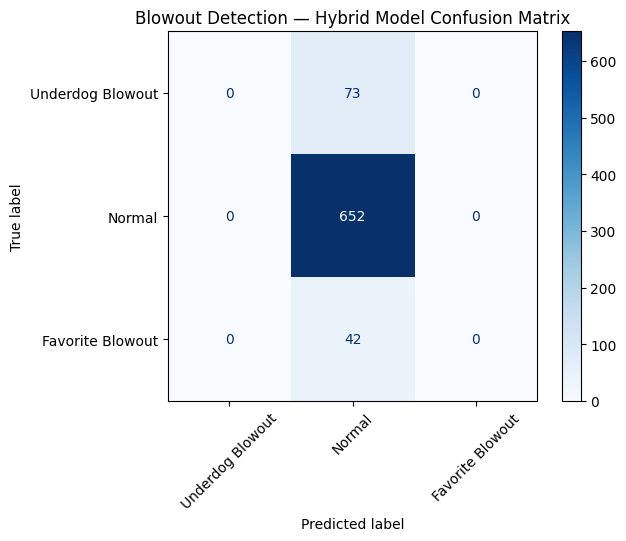

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define blowout thresholds
UPPER_CAP = 27
LOWER_CAP = -17

# Convert Hybrid Predictions into Blowout Labels
hybrid_pred_labels = np.where(hybrid_preds > UPPER_CAP, 'Favorite Blowout',
                       np.where(hybrid_preds < LOWER_CAP, 'Underdog Blowout', 'Normal'))

# Convert True Game Margins into Blowout Labels (Ground Truth)
true_labels = np.where(y_test_reg.values > UPPER_CAP, 'Favorite Blowout',
                np.where(y_test_reg.values < LOWER_CAP, 'Underdog Blowout', 'Normal'))

# Classification Report for Blowout Detection
print(classification_report(true_labels, hybrid_pred_labels))

# Optional: Confusion Matrix Visualization
labels = ['Underdog Blowout', 'Normal', 'Favorite Blowout']
cm = confusion_matrix(true_labels, hybrid_pred_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Blowout Detection — Hybrid Model Confusion Matrix')
plt.show()


### XGB Trimmed Model

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

# --- Data Preparation ---
X = features_df.drop(columns=['game_margin', 'game_id', 'blowout_class'])

y = features_df['game_margin']

# Define Feature Types
categorical_cols = [col for col in ['roof', 'surface'] if col in X.columns]
boolean_cols = [col for col in ['is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'is_home_qb_new', 'is_away_qb_new'] if col in X.columns]
numerical_cols = [col for col in X.columns if col not in categorical_cols + boolean_cols]

# Ensure categorical columns are strings
for col in categorical_cols:
    X[col] = X[col].astype(str)

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess Data
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# --- XGBoost Regression Model (Best GridSearchCV Params) ---
xgb_regressor = XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    min_child_weight=3,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=1,
    reg_lambda=3,
    objective='reg:squarederror',
    random_state=42
)

# Train Model
xgb_regressor.fit(X_train_preprocessed, y_train)

# Predictions
y_pred = xgb_regressor.predict(X_test_preprocessed)

# --- Trim Predictions to Caps ---
UPPER_CAP = 27
LOWER_CAP = -17
y_pred_trimmed = np.clip(y_pred, LOWER_CAP, UPPER_CAP)

# Evaluate Trimmed Predictions
mae = mean_absolute_error(y_test, y_pred_trimmed)
r2 = r2_score(y_test, y_pred_trimmed)

print(f"Trimmed Model MAE: {mae:.2f}")
print(f"Trimmed Model R²: {r2:.2f}")


Trimmed Model MAE: 10.24
Trimmed Model R²: 0.19


In [ ]:
X = reduced_features_df.drop(columns=['game_margin'])
y = reduced_features_df['game_margin']

# Determine categorical, boolean, and numerical columns
categorical_cols = [col for col in ['roof', 'surface'] if col in X.columns]
boolean_cols = [col for col in ['is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'is_home_qb_new', 'is_away_qb_new'] if col in X.columns]
numerical_cols = [col for col in X.columns if col not in categorical_cols + boolean_cols]

# Convert categorical to string (if any)
for col in categorical_cols:
    X[col] = X[col].astype(str)

# Column Transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# XGBoost with Best Parameters
xgb_regressor = XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    min_child_weight=3,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=1,
    reg_lambda=3,
    objective='reg:squarederror',
    random_state=42
)

# Train Model
xgb_regressor.fit(X_train_preprocessed, y_train)

# Predict & Trim
y_pred = xgb_regressor.predict(X_test_preprocessed)
y_pred_trimmed = np.clip(y_pred, -17, 27)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_trimmed)
r2 = r2_score(y_test, y_pred_trimmed)

print(f"Top 25 Trimmed Model MAE: {mae:.2f}")
print(f"Top 25 Trimmed Model R²: {r2:.2f}")


Top 25 Trimmed Model MAE: 10.23
Top 25 Trimmed Model R²: 0.19


###GridSearchCV 2 with new features

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# --- Define Parameter Distributions (Wide Net) ---
param_distributions = {
    'regressor__n_estimators': [300, 500],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.03],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__reg_alpha': [0, 1, 5],
    'regressor__reg_lambda': [1, 3, 5],
    'regressor__gamma': [0, 1]
}

# --- Pipeline Definition (Use your preprocessor & data splits) ---
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_iter2),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        verbosity=1
    ))
])

# --- RandomizedSearchCV ---
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=150,  # Adjust based on how much time you have
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# --- Run Randomized Search ---
random_search.fit(X_train_iter2, y_train_iter2)

# --- Best Params & Evaluation ---
print("Best Parameters Found:")
print(random_search.best_params_)
print(f"Best CV MAE: {-random_search.best_score_:.4f}")

# --- Evaluate on Test Data ---
best_model = random_search.best_estimator_
y_pred_test = best_model.predict(X_test_iter2)
mae_test = mean_absolute_error(y_test_iter2, y_pred_test)
r2_test = r2_score(y_test_iter2, y_pred_test)

print(f"Test MAE: {mae_test:.2f}")
print(f"Test R²: {r2_test:.2f}")


Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Parameters Found:
{'regressor__subsample': 0.6, 'regressor__reg_lambda': 5, 'regressor__reg_alpha': 1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.01, 'regressor__gamma': 0, 'regressor__colsample_bytree': 1.0}
Best CV MAE: 10.3513
Test MAE: 10.17
Test R²: 0.20


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# --- Define Parameter Distributions (Wide Net) ---
param_distributions = {
    'regressor__n_estimators': [300, 500],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.03],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__reg_alpha': [0, 1, 5],
    'regressor__reg_lambda': [1, 3, 5],
    'regressor__gamma': [0, 1]
}

# --- Pipeline Definition (Use your preprocessor & data splits) ---
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_top25),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        verbosity=1
    ))
])

# --- RandomizedSearchCV ---
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=150,  # Adjust based on how much time you have
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# --- Run Randomized Search ---
random_search.fit(X_train_top25, y_train_top25)

# --- Best Params & Evaluation ---
print("Best Parameters Found:")
print(random_search.best_params_)
print(f"Best CV MAE: {-random_search.best_score_:.4f}")

# --- Evaluate on Test Data ---
best_model = random_search.best_estimator_
y_pred_test = best_model.predict(X_test_top25)
mae_test = mean_absolute_error(y_test_top25, y_pred_test)
r2_test = r2_score(y_test_top25, y_pred_test)

print(f"Test MAE: {mae_test:.2f}")
print(f"Test R²: {r2_test:.2f}")


Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Parameters Found:
{'regressor__subsample': 0.6, 'regressor__reg_lambda': 1, 'regressor__reg_alpha': 5, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 3, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.01, 'regressor__gamma': 1, 'regressor__colsample_bytree': 0.8}
Best CV MAE: 10.3383
Test MAE: 10.19
Test R²: 0.20


In [ ]:
param_grid_focused = {
    'regressor__n_estimators': [300, 400],
    'regressor__max_depth': [3, 4],  # Only around 3 (best)
    'regressor__learning_rate': [0.01],  # Fixed at best
    'regressor__min_child_weight': [5, 6],  # Slightly around best
    'regressor__subsample': [0.6, 0.7],  # Expand a bit around 0.6
    'regressor__colsample_bytree': [0.9, 1.0],  # Narrow around 1.0
    'regressor__reg_alpha': [1],  # Fixed if not sensitive
    'regressor__reg_lambda': [4, 5, 6],  # Slightly around 5
    'regressor__gamma': [0]  # Fixed at best if not sensitive
}


In [ ]:
def run_gridsearch_pipeline(X_train, y_train, param_grid_focused, preprocessor):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid_focused,
        cv=3,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X_train, y_train)
    print("Best Params:", grid_search.best_params_)
    print(f"Best CV MAE: {-grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_score_


In [ ]:
#grid search
best_model_iter2, cv_mae_iter2 = run_gridsearch_pipeline(X_train_iter2, y_train_iter2, param_grid_focused, preprocessor_iter2)


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Params: {'regressor__colsample_bytree': 1.0, 'regressor__gamma': 0, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 300, 'regressor__reg_alpha': 1, 'regressor__reg_lambda': 5, 'regressor__subsample': 0.6}
Best CV MAE: 10.3513


In [ ]:
# Predictions on Train
y_pred_train_iter2 = best_model_iter2.predict(X_train_iter2)

# Predictions on Test
y_pred_test_iter2 = best_model_iter2.predict(X_test_iter2)

# Evaluate
train_mae_iter2 = mean_absolute_error(y_train_iter2, y_pred_train_iter2)
test_mae_iter2 = mean_absolute_error(y_test_iter2, y_pred_test_iter2)
train_r2_iter2 = r2_score(y_train_iter2, y_pred_train_iter2)
test_r2_iter2 = r2_score(y_test_iter2, y_pred_test_iter2)

# Report
print(f"Train MAE: {train_mae_iter2:.2f} | Test MAE: {test_mae_iter2:.2f} | CV MAE: {cv_mae_iter2:.2f}")
print(f"Train R²: {train_r2_iter2:.2f} | Test R²: {test_r2_iter2:.2f}")


Train MAE: 9.86 | Test MAE: 10.17 | CV MAE: -10.35
Train R²: 0.25 | Test R²: 0.20


In [ ]:
param_grid_top25_focused = {
    'regressor__n_estimators': [300, 400],
    'regressor__max_depth': [3, 4],
    'regressor__learning_rate': [0.01],
    'regressor__min_child_weight': [3, 4],
    'regressor__subsample': [0.6, 0.7],
    'regressor__colsample_bytree': [0.8, 0.9],
    'regressor__reg_alpha': [4, 5, 6],
    'regressor__reg_lambda': [0.8, 1, 1.2],
    'regressor__gamma': [0.8, 1, 1.2]
}


In [ ]:
# Reuse the same function structure, just pass in top25 components
best_model_top25, cv_mae_top25 = run_gridsearch_pipeline(X_train_top25, y_train_top25, param_grid_top25_focused, preprocessor_top25)


Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Best Params: {'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0.8, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 300, 'regressor__reg_alpha': 6, 'regressor__reg_lambda': 0.8, 'regressor__subsample': 0.6}
Best CV MAE: 10.3374


In [ ]:
# Predictions
y_pred_train_top25 = best_model_top25.predict(X_train_top25)
y_pred_test_top25 = best_model_top25.predict(X_test_top25)

# MAE & R²
train_mae_top25 = mean_absolute_error(y_train_top25, y_pred_train_top25)
test_mae_top25 = mean_absolute_error(y_test_top25, y_pred_test_top25)
train_r2_top25 = r2_score(y_train_top25, y_pred_train_top25)
test_r2_top25 = r2_score(y_test_top25, y_pred_test_top25)

# Report
print(f"Top 25 Model - Train MAE: {train_mae_top25:.2f} | Test MAE: {test_mae_top25:.2f} | CV MAE: {cv_mae_top25:.2f}")
print(f"Top 25 Model - Train R²: {train_r2_top25:.2f} | Test R²: {test_r2_top25:.2f}")


Top 25 Model - Train MAE: 9.91 | Test MAE: 10.19 | CV MAE: -10.34
Top 25 Model - Train R²: 0.24 | Test R²: 0.20


###XGB Betting Evaluation

In [ ]:
# Example using features_df
X = features_df.drop(columns=['game_margin'])
y = features_df['game_margin']

# Keep game_id and spread_line separately for betting evaluation
game_ids = features_df['game_id']
spread_lines = features_df['spread_line']

# Split Data (this ensures game_id and spread_line are aligned with X_test/y_test)
X_train, X_test, y_train, y_test, game_ids_train, game_ids_test, spread_train, spread_test = train_test_split(
    X, y, game_ids, spread_lines, test_size=0.2, random_state=42)


####Iteration 2 Model

In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# --- Define Features & Target (Iteration 2 Full Feature Model) ---
X_iter2 = features_df.drop(columns=['game_margin'])
y_iter2 = features_df['game_margin']

# Drop non-feature columns
non_feature_cols = ['game_id', 'home_team', 'away_team', 'season', 'week', 'blowout_class']
X_iter2_filtered = X_iter2.drop(columns=non_feature_cols, errors='ignore')

# Feature Types
categorical_cols = [col for col in ['roof', 'surface'] if col in X_iter2_filtered.columns]
boolean_cols = [col for col in ['is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'is_home_qb_new', 'is_away_qb_new'] if col in X_iter2_filtered.columns]
numerical_cols = [col for col in X_iter2_filtered.columns if col not in categorical_cols + boolean_cols]

# Ensure categorical columns are strings
for col in categorical_cols:
    X_iter2_filtered[col] = X_iter2_filtered[col].astype(str)

# Preprocessor Pipeline
preprocessor_iter2 = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

# XGBoost Pipeline
pipeline_iter2 = Pipeline(steps=[
    ('preprocessor', preprocessor_iter2),
    ('regressor', XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.01,
        min_child_weight=5,
        subsample=0.6,
        colsample_bytree=1.0,
        reg_alpha=1,
        reg_lambda=5,
        gamma=0,
        objective='reg:squarederror',
        random_state=42,
        verbosity=1
    ))
])

# Train/Test Split (Iteration 2)
X_train_iter2, X_test_iter2, y_train_iter2, y_test_iter2 = train_test_split(X_iter2_filtered, y_iter2, test_size=0.2, random_state=42)

# Train Model
pipeline_iter2.fit(X_train_iter2, y_train_iter2)

# Predict & Evaluate
y_pred_iter2 = pipeline_iter2.predict(X_test_iter2)
mae_iter2 = mean_absolute_error(y_test_iter2, y_pred_iter2)
r2_iter2 = r2_score(y_test_iter2, y_pred_iter2)

print(f"Iteration 2 - MAE: {mae_iter2:.2f}")
print(f"Iteration 2 - R²: {r2_iter2:.2f}")


Iteration 2 - MAE: 10.17
Iteration 2 - R²: 0.20


####Top 25 Features

In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# --- Top 25 Reduced Model Data ---
X_top25 = features_df[top_features]  # top_features = your top 25 feature list
y_top25 = features_df['game_margin']

# Define feature types
categorical_cols_top25 = [col for col in ['roof', 'surface'] if col in X_top25.columns]
boolean_cols_top25 = [col for col in ['is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'is_home_qb_new', 'is_away_qb_new'] if col in X_top25.columns]
numerical_cols_top25 = [col for col in X_top25.columns if col not in categorical_cols_top25 + boolean_cols_top25]

# Ensure categorical columns are strings
for col in categorical_cols_top25:
    X_top25[col] = X_top25[col].astype(str)

# Preprocessing Pipeline
preprocessor_top25 = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols_top25),
        ('num', 'passthrough', numerical_cols_top25 + boolean_cols_top25)
    ]
)

# XGBoost Pipeline for Top 25
pipeline_top25 = Pipeline(steps=[
    ('preprocessor', preprocessor_top25),
    ('regressor', XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.01,
        min_child_weight=3,
        subsample=0.6,
        colsample_bytree=0.8,
        reg_alpha=6,
        reg_lambda=0.8,
        gamma=0.8,
        objective='reg:squarederror',
        random_state=42,
        verbosity=1
    ))
])

# Train/Test Split for Top 25 Model
X_train_top25, X_test_top25, y_train_top25, y_test_top25 = train_test_split(X_top25, y_top25, test_size=0.2, random_state=42)

# Train Model
pipeline_top25.fit(X_train_top25, y_train_top25)

# Predict & Evaluate
y_pred_top25 = pipeline_top25.predict(X_test_top25)
mae_top25 = mean_absolute_error(y_test_top25, y_pred_top25)
r2_top25 = r2_score(y_test_top25, y_pred_top25)

print(f"Top 25 Model - MAE: {mae_top25:.2f}")
print(f"Top 25 Model - R²: {r2_top25:.2f}")


Top 25 Model - MAE: 10.19
Top 25 Model - R²: 0.20


####Trimmed Model

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

# --- Data Preparation ---
X = features_df.drop(columns=['game_margin', 'game_id', 'blowout_class'])

y = features_df['game_margin']

# Define Feature Types
categorical_cols = [col for col in ['roof', 'surface'] if col in X.columns]
boolean_cols = [col for col in ['is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'is_home_qb_new', 'is_away_qb_new'] if col in X.columns]
numerical_cols = [col for col in X.columns if col not in categorical_cols + boolean_cols]

# Ensure categorical columns are strings
for col in categorical_cols:
    X[col] = X[col].astype(str)

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess Data
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# --- XGBoost Regression Model (Best GridSearchCV Params) ---
pipeline_iter2 = Pipeline(steps=[
    ('preprocessor', preprocessor_iter2),
    ('regressor', XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.01,
        min_child_weight=5,
        subsample=0.6,
        colsample_bytree=1.0,
        reg_alpha=1,
        reg_lambda=5,
        gamma=0,
        objective='reg:squarederror',
        random_state=42,
        verbosity=1
    ))
])

# Train Model
xgb_regressor.fit(X_train_preprocessed, y_train)

# Predictions
y_pred = xgb_regressor.predict(X_test_preprocessed)

# --- Trim Predictions to Caps ---
UPPER_CAP = 27
LOWER_CAP = -17
y_pred_trimmed = np.clip(y_pred, LOWER_CAP, UPPER_CAP)

# Evaluate Trimmed Predictions
mae = mean_absolute_error(y_test, y_pred_trimmed)
r2 = r2_score(y_test, y_pred_trimmed)

print(f"Trimmed Model MAE: {mae:.2f}")
print(f"Trimmed Model R²: {r2:.2f}")


Trimmed Model MAE: 10.24
Trimmed Model R²: 0.19


####Reduced Trim

In [ ]:
X = reduced_features_df.drop(columns=['game_margin'])
y = reduced_features_df['game_margin']

# Determine categorical, boolean, and numerical columns
categorical_cols = [col for col in ['roof', 'surface'] if col in X.columns]
boolean_cols = [col for col in ['is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'is_home_qb_new', 'is_away_qb_new'] if col in X.columns]
numerical_cols = [col for col in X.columns if col not in categorical_cols + boolean_cols]

# Convert categorical to string (if any)
for col in categorical_cols:
    X[col] = X[col].astype(str)

# Column Transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# XGBoost with Best Parameters
model = XGBRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.01,
    min_child_weight=3,
    subsample=0.6,
    colsample_bytree=0.8,
    reg_alpha=6,
    reg_lambda=0.8,
    gamma=0.8,
    objective='reg:squarederror',
    random_state=42,
    verbosity=1
)

# Train Model
xgb_regressor.fit(X_train_preprocessed, y_train)

# Predict & Trim
y_pred = xgb_regressor.predict(X_test_preprocessed)
y_pred_trimmed = np.clip(y_pred, -17, 27)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_trimmed)
r2 = r2_score(y_test, y_pred_trimmed)

print(f"Top 25 Trimmed Model MAE: {mae:.2f}")
print(f"Top 25 Trimmed Model R²: {r2:.2f}")


Top 25 Trimmed Model MAE: 10.23
Top 25 Trimmed Model R²: 0.19


#### Evaluation Code

In [ ]:
# Create Evaluation DataFrame
eval_df = pd.DataFrame({
    'game_id': game_ids_test.reset_index(drop=True),
    'game_margin': y_test.reset_index(drop=True),
    'spread_line': spread_test.reset_index(drop=True),
    'model_prediction': y_pred
})


In [ ]:
# Absolute difference between model prediction and spread
eval_df['model_vs_spread_diff'] = np.abs(eval_df['model_prediction'] - eval_df['spread_line'])

# Define "True Bets" where model disagrees with spread by >= 1 point
true_bets_df = eval_df[eval_df['model_vs_spread_diff'] >= 1].copy()


In [ ]:
# Errors compared to actual game margin
eval_df['model_error'] = np.abs(eval_df['game_margin'] - eval_df['model_prediction'])
eval_df['spread_error'] = np.abs(eval_df['game_margin'] - eval_df['spread_line'])

# Determine if model was closer to actual result than the spread
eval_df['model_vs_spread'] = eval_df['model_error'] < eval_df['spread_error']


In [ ]:
# Overall model beat spread %
winning_percentage = eval_df['model_vs_spread'].mean()
print(f"Model beat spread in {winning_percentage*100:.2f}% of all games")

# Evaluate on True Bets (model confidently disagrees with spread)
true_bets_df['model_error'] = np.abs(true_bets_df['game_margin'] - true_bets_df['model_prediction'])
true_bets_df['spread_error'] = np.abs(true_bets_df['game_margin'] - true_bets_df['spread_line'])
true_bets_df['model_vs_spread'] = true_bets_df['model_error'] < true_bets_df['spread_error']
true_bet_win_percentage = true_bets_df['model_vs_spread'].mean()

print(f"True Bets (>=1pt diff): Model beat spread {true_bet_win_percentage*100:.2f}% of the time")
print(f"Number of True Bets: {len(true_bets_df)}")


Model beat spread in 47.20% of all games
True Bets (>=1pt diff): Model beat spread 45.79% of the time
Number of True Bets: 463


In [ ]:
# Assuming match_df has columns ['game_id', 'week']
eval_df = eval_df.merge(match_df[['game_id', 'week']], on='game_id', how='left')


In [ ]:
eval_df.head()

game_id  game_margin  spread_line  model_prediction  \
0   2021_03_MIA_LV          3.0          4.0          5.291189   
1  2019_16_NYG_WAS         -6.0         -1.0          0.822041   
2  2012_10_IND_JAX        -17.0         -3.0         -4.228121   
3  2021_18_DAL_PHI        -25.0         -6.5         -6.004127   
4  2016_08_MIN_CHI         10.0         -5.5         -6.517123   

   model_vs_spread_diff  model_error  spread_error  model_vs_spread  \
0              1.291189     2.291189           1.0            False   
1              1.822041     6.822041           5.0            False   
2              1.228121    12.771879          14.0             True   
3              0.495873    18.995873          18.5            False   
4              1.017123    16.517123          15.5            False   

   model_abs_error  week  
0         2.291189     3  
1         6.822041    16  
2        12.771879    10  
3        18.995873    18  
4        16.517123     8

##Side Project - Comparison

Our models are slightly below the results we are looking for. The time period of 2009-2025 is a long time. The way football is played changes a lot during that amount of time. We are going to only look at the last 5 years to see if this produces a better result. In theory, this might show more relevant trends to predicting games played today.

In [139]:
match_df.head()

game_id  game_margin  spread_line  season game_type  week  \
32  2009_03_CLE_BAL         31.0         13.5    2009       REG     3   
33  2009_03_WAS_DET          5.0         -6.5    2009       REG     3   
34  2009_03_JAX_HOU         -7.0          4.0    2009       REG     3   
35   2009_03_SF_MIN          3.0          7.0    2009       REG     3   
36   2009_03_ATL_NE         16.0          4.5    2009       REG     3   

       gameday weekday gametime away_team  away_score home_team  home_score  \
32  2009-09-27  Sunday    13:00       CLE         3.0       BAL        34.0   
33  2009-09-27  Sunday    13:00       WAS        14.0       DET        19.0   
34  2009-09-27  Sunday    13:00       JAX        31.0       HOU        24.0   
35  2009-09-27  Sunday    13:00        SF        24.0       MIN        27.0   
36  2009-09-27  Sunday    13:00       ATL        10.0        NE        26.0   

   location  total  overtime  old_game_id     gsis nfl_detail_id  \
32     Home   37.0       0.0   2009092700  54504.0             0   
33     Home   33.0       0.0   2009092702  54506.0             0   
34     Home   55.0       0.0   2009092703  54507.0             0   
35     Home   51.0       0.0   2009092704  54508.0             0   
36     Home   36.0       0.0   2009092705  54509.0             0   

             pfr     pff         espn  ftn  away_rest  home_rest  \
32  200909270rav  1434.0  290927033.0  0.0          7          7   
33  200909270det  1428.0  290927008.0  0.0          7          7   
34  200909270htx  1435.0  290927034.0  0.0          7          7   
35  200909270min  1431.0  290927016.0  0.0          7          7   
36  200909270nwe  1432.0  290927017.0  0.0          7          7   

    away_moneyline  home_moneyline  away_spread_odds  home_spread_odds  \
32           620.0          -750.0            -110.0             102.0   
33          -260.0           228.0             102.0            -110.0   
34           180.0          -200.0            -104.0            -104.0   
35           243.0          -275.0            -114.0             105.0   
36           194.0          -220.0            -109.0             101.0   

    total_line  under_odds  over_odds  div_game      roof    surface  temp  \
32        38.5      -110.0      100.0         1  outdoors  sportturf  72.0   
33        39.5      -108.0     -102.0         0      dome  fieldturf   0.0   
34        47.0      -112.0      102.0         1    closed      grass   0.0   
35        39.0      -102.0     -108.0         0      dome  fieldturf   0.0   
36        45.5       100.0     -110.0         0  outdoors  fieldturf  62.0   

    wind  away_qb_id  home_qb_id    away_qb_name      home_qb_name  \
32   6.0  00-0025409  00-0026158     Brady Quinn        Joe Flacco   
33   0.0  00-0023460  00-0026498  Jason Campbell  Matthew Stafford   
34   0.0  00-0021231  00-0022787   David Garrard       Matt Schaub   
35   0.0  00-0020679  00-0005106      Shaun Hill       Brett Favre   
36   0.0  00-0026143  00-0019596       Matt Ryan         Tom Brady   

         away_coach      home_coach          referee stadium_id  \
32     Eric Mangini   John Harbaugh    Terry McAulay      BAL00   
33         Jim Zorn    Jim Schwartz      Scott Green      DET00   
34     Jack Del Rio     Gary Kubiak       Ron Winter      HOU00   
35  Mike Singletary  Brad Childress     Jerome Boger      MIN00   
36       Mike Smith  Bill Belichick  Alberto Riveron      BOS00   

                         stadium  is_playoff  final_week  is_final_week  \
32              M&T Bank Stadium       False          17          False   
33                    Ford Field       False          17          False   
34               Reliant Stadium       False          17          False   
35  Hubert H. Humphrey Metrodome       False          17          False   
36              Gillette Stadium       False          17          False   

    home_qb_switch  away_qb_switch  home_avg_epa  home_avg_yards  \
32           False     

In [138]:
#only keep last 5 seasons worth of data
recent_seasons = sorted(match_df['season'].unique())[-5:]
recent_df = match_df[match_df['season'].isin(recent_seasons)].copy()

recent_df = recent_df.drop(['week', 'season', 'game_type', 'gameday', 'weekday', 'gametime', 'away_team', 'home_team', 'away_score', 'home_score', 'location', 'total', 'overtime', 'old_game_id', 'gsis', 'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn',
                             'away_moneyline', 'home_moneyline', 'away_spread_odds', 'home_spread_odds', 'under_odds', 'over_odds', 'stadium', 'final_week', 'away_qb_id', 'home_qb_id', 'home_avg_epa', 'home_avg_yards', 'home_play_count', 'away_avg_epa', 'away_avg_yards', 'away_play_count',
                             'home_allowed_avg_epa', 'home_allowed_avg_yards', 'home_allowed_play_count', 'away_allowed_avg_epa', 'away_allowed_avg_yards', 'away_allowed_play_count', 'home_qb_name', 'away_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium_id', 'home_injured_allpro_prev_year_count',
                             'away_injured_allpro_prev_year_count',	'home_active_allpro_prev_year',	'away_active_allpro_prev_year','home_injured_allpro_weighted_count',	'away_injured_allpro_weighted_count',	'diff_injured_allpro_weighted_count',	'home_active_allpro_weighted',	'away_active_allpro_weighted'
                             ], axis=1)

recent_df.shape

(1248, 68)

Number of Features:
66



Name of Features - Categorical and Quantative Respectively:
['roof', 'surface']



['spread_line', 'away_rest', 'home_rest', 'total_line', 'div_game', 'temp', 'wind', 'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'home_rolling_avg_epa', 'home_rolling_avg_yards', 'home_rolling_play_count', 'away_rolling_avg_epa', 'away_rolling_avg_yards', 'away_rolling_play_count', 'home_rolling_allowed_avg_epa', 'home_rolling_allowed_avg_yards', 'home_rolling_allowed_play_count', 'away_rolling_allowed_avg_epa', 'away_rolling_allowed_avg_yards', 'away_rolling_allowed_play_count', 'epa_home_off_away_def_rolling_diff', 'epa_home_def_away_off_rolling_diff', 'avg_yards_home_off_away_def_rolling_diff', 'avg_yards_home_def_away_off_rolling_diff', 'play_count_home_off_away_def_rolling_diff', 'play_count_home_def_away_off_rolling_diff', 'home_recent_sos_opponent_avg', 'home_season_sos_opponent_avg', 'away_recent_sos_opponent_avg', 'away_season_sos_opponent_avg', 's

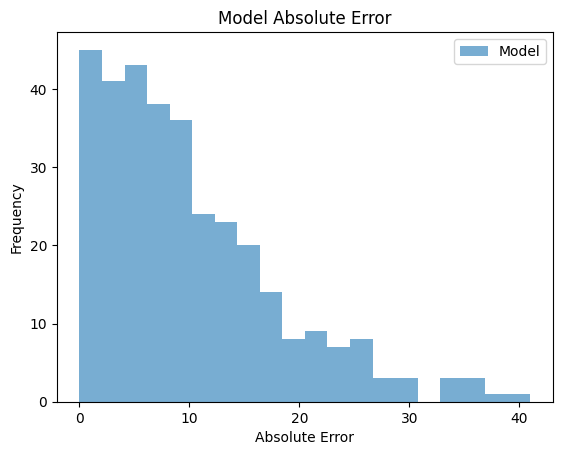

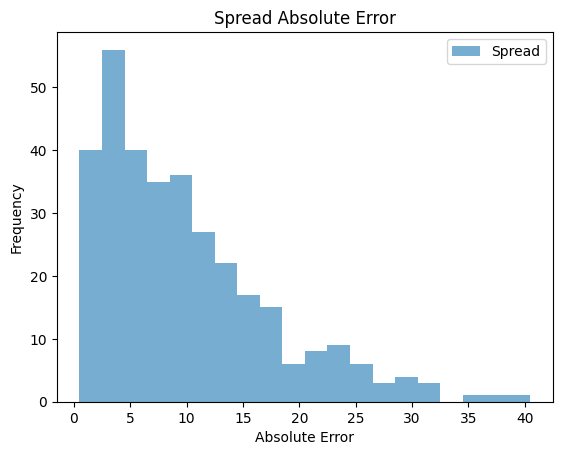




Substantial Differences: 
259



Most Important Value - True Bets - Model beat spread in 47.10% of the time





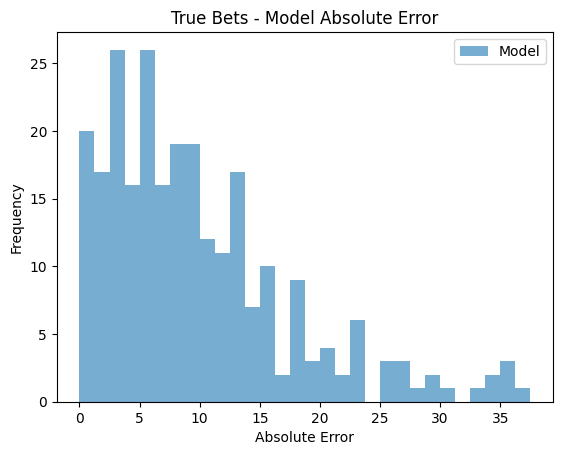

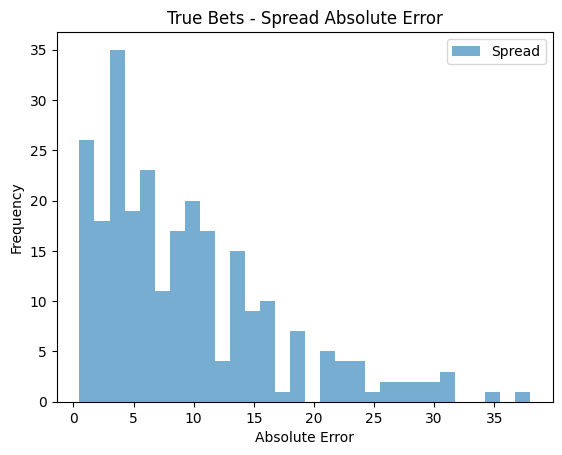




TRAIN MAE:
7.037697594501718



TRAIN R²:
0.5450376328950621



TEST MAE:
10.021765333333335



TEST R²:
0.14815897193372563








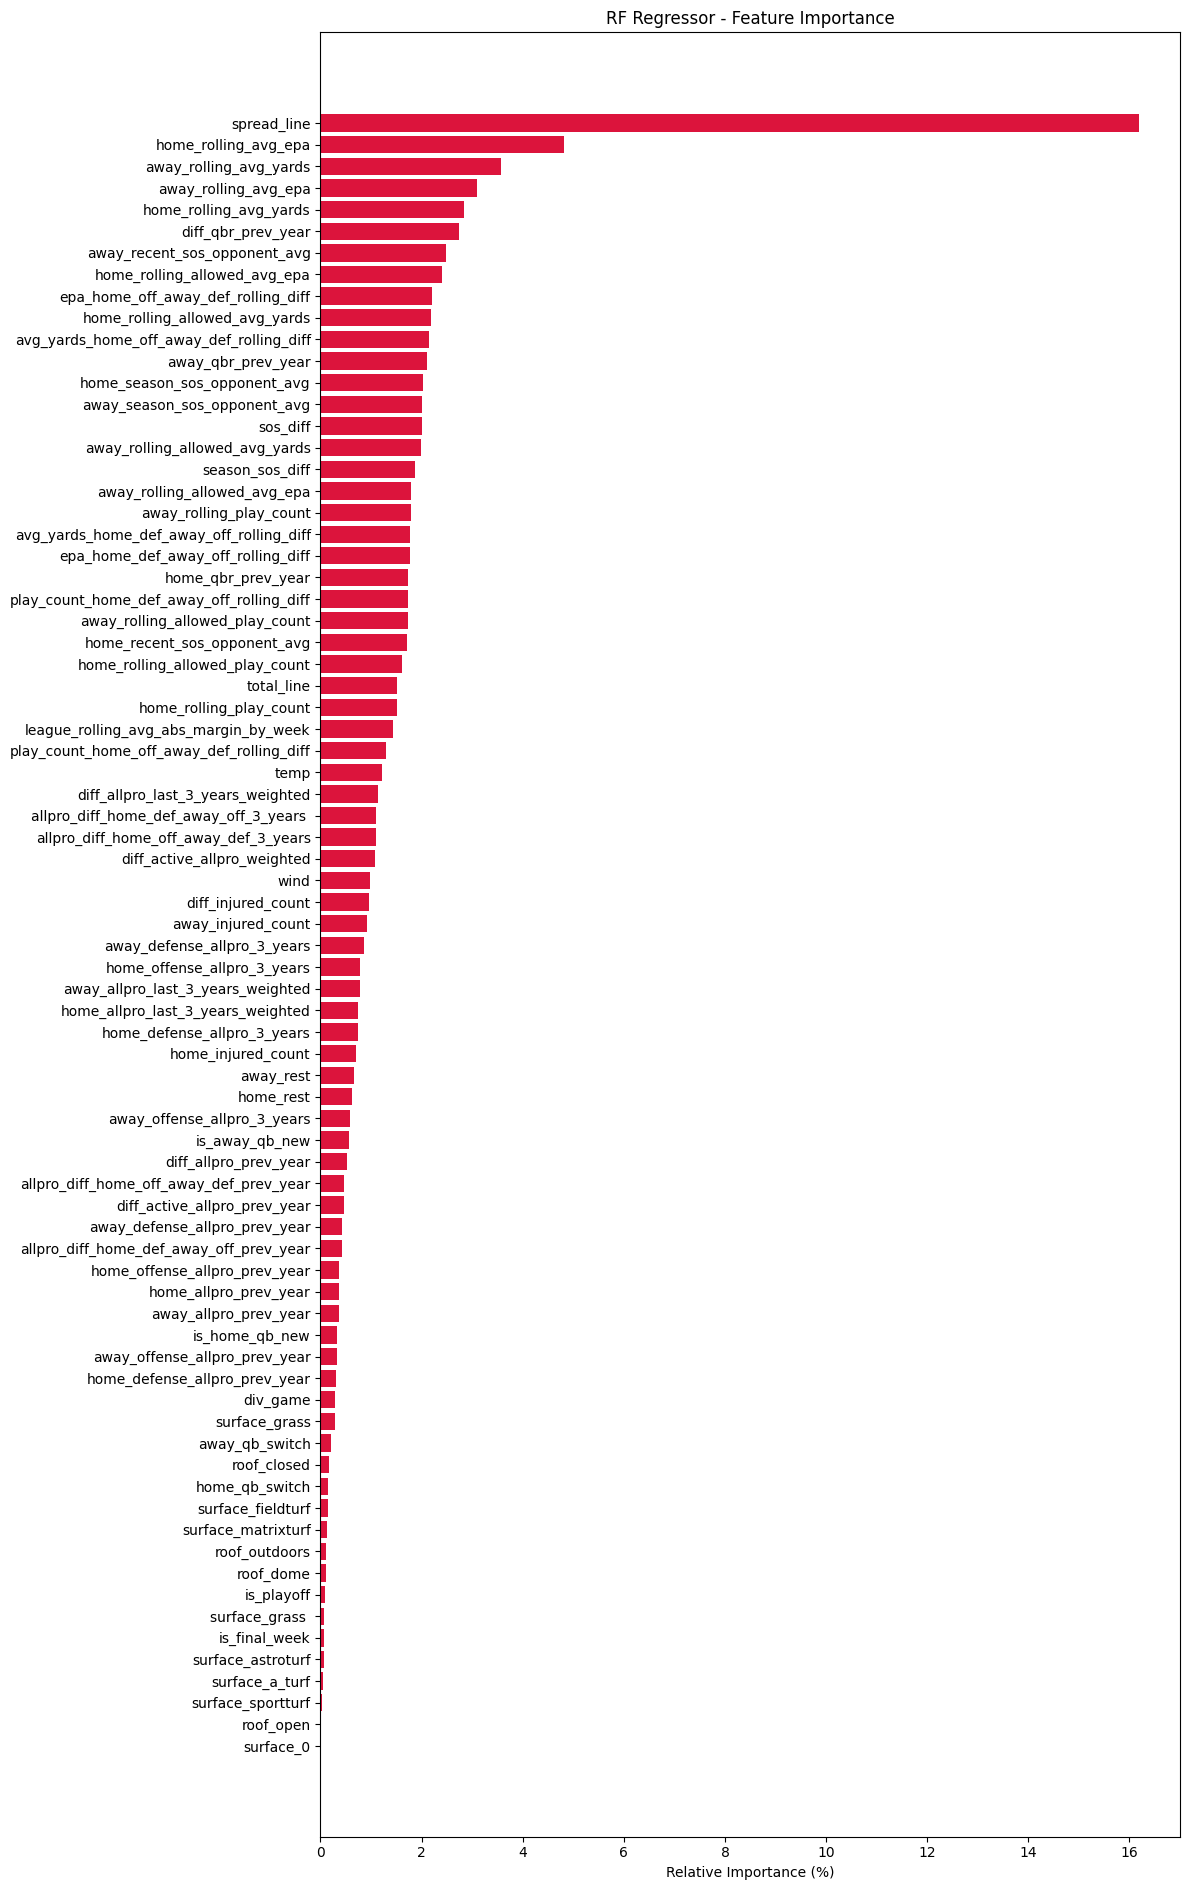

In [140]:
#same model as 5th iteration of RF regressor (best model) w/ only the last 5 seasons worth of data
recent_model, recent_eval = random_forest_regressor_v3_with_spread(recent_df)

In [141]:
recent_eval.head()

game_id  game_margin  model_prediction  spread  \
971   2023_18_NYJ_NE        -14.0               4.0     2.5   
374  2021_12_NYJ_HOU         -7.0              -0.5     3.0   
715   2022_18_TB_ATL         13.0               5.0     6.0   
808  2023_07_WAS_NYG          7.0              -2.0    -3.0   
986  2023_19_PIT_BUF         14.0               9.0    10.0   

     model_vs_spread_diff  model_error  spread_error  model_vs_spread  
971                   1.5         18.0          16.5            False  
374                   3.5          6.5          10.0             True  
715                   1.0          8.0           7.0            False  
808                   1.0          9.0          10.0             True  
986                   1.0          5.0           4.0            False

random forest regressor - There seems to be a slight decrease in performance. That is expected. Less data would make it worse at predicting, but was still interesting to see if that was the case.

Gabe's model -

##Evaluation Takeaways

Now we want to compare our model's to the spread line given to us in the dataset. The spread line is a value that shows what a sportsbook predicts the margin of victory will be (or at least what an even value is for the match).

Ex: if the patriots are supposed to win by 3 points over the colts then the spread would be patriots -3 which is equal to colts +3.

Lets say the end of game result is Patriots win 27-21. This means to win the bet we would've had to say (before the game starts) that the Patriots are going win by more than 3 points. That would qualify as a winning bet.

NOTE - it does not matter how much the Patriots win by as long as they win by more than 3 points. If they win by 50 points or 3 points we still win the bet.

NEEDS UPDATE AFTER FINAL FEATURES ADDED

***Random Forest Regressor Model Evaluation***

**1st Iteration (all features, no hyperparameter tuning):**

train MAE - 4.02
train r2 - 87%

test MAE - 11.00
test r2 - 8%

All bets winning percentage - 45.59%
Differential >=1 bets winning percentage - 43.77%

takeaway - clear overfitting

**2nd Iteration (removing redundant features, adding max depth):**

train MAE - 8.31
train r2 - 48%

test MAE - 11.27
test r2 - 5%

All bets winning percentage - 44.12%
Differential >=1 bets winning percentage - 42.74%

takeaway - decreased overfitting, slight loss of test performance

**3rd Iteration (removing features with less than 1% importance from 2nd iteration, using more hyperparameter tuning):**

train MAE - 10.55
train r2 - 11%

test MAE - 11.17
train r2 - 5%

All bets winning percentage - 44.25%
Differential >=1 bets winning percentage - 43.56%

takeaway - marginal overfitting (potential underfitting), Performance not as good as 1st iteration, but similar (or slightly better) than the model from iteration 2.

**4th Iteration (1st iteration model with hyperparameter tuning):**

train MAE - 7.68
train r2 - 50%

test MAE - 10.72
test r2 - 10.5%

All bets winning percentage - **47.91%**
Differential >= 1 bets winning percentage - 44.78%

takeaway - Hyperparameter tuning was critical to reduce overfitting. Keeping all features gives best results, unsurprisingly. Gain is still marginal, but every percent difference matters.

**5th Iteration (4th iteration model with spread line included):**

train MAE - 7.36
train r2 - 54%

test MAE - 10.42
test r2 - 15.5%

All bets winning percentage - **48.53%**
Differential >= bets winning percentage - 46.88%

takeaway - Adding the spread line as a feature improves are model slightly.

***XGBoost Model Evaluation***

**2nd Iteration:**

Iteration 2 - MAE: 10.24
Iteration 2 - R²: 0.19

Model beat spread in 46.94% of all games
True Bets (>=1pt diff): Model beat spread 45.77% of the time
Number of True Bets: 426

**Top 25 Features of Iteration 2:**

Reduced Feature Model - MAE: 10.23
Reduced Feature Model - R²: 0.19

Model beat spread in 46.94% of all games
True Bets (>=1pt diff): Model beat spread 45.77% of the time
Number of True Bets: 426

**Trimmed Model:**
Trimmed Model MAE: 10.24
Trimmed Model R²: 0.19

Model beat spread in 46.94% of all games
True Bets (>=1pt diff): Model beat spread 45.77% of the time
Number of True Bets: 426

**Trimmed w/ Reduced Features:**

Top 25 Trimmed Model MAE: 10.23
Top 25 Trimmed Model R²: 0.19

Model beat spread in 47.20% of all games
True Bets (>=1pt diff): Model beat spread 45.79% of the time
Number of True Bets: 463